## Data preparation

In [1]:
# Test text start at this position
TEST_SPLIT_POS = 407374

### Resource paths

In [2]:
PROJECT_ROOT_PATH = '../../../..'
TEMP_PATH = PROJECT_ROOT_PATH + '/tmp'
DATA_PATH  = TEMP_PATH + '/suggest/data'
MODEL_PATH = TEMP_PATH + '/suggest/model'
CAND_PATH = TEMP_PATH + '/suggest/cand'
LOG_PATH   = TEMP_PATH + '/suggest/log'

DETECT_TEST_WORDS_PATH = TEMP_PATH + '/detect/label/words.test.tsv'
GT_TOKEN_PATH = PROJECT_ROOT_PATH + '/ocrrect-experiment/src/main/resources/mibio-ocr/ocr.token.tsv'
GT_ERROR_PATH = PROJECT_ROOT_PATH + '/ocrrect-experiment/src/main/resources/mibio-ocr/error.gt.tsv'

TRAIN_TIME_LOG_PATH = LOG_PATH + '/time.model.train.log'

SUGGEST_TRAIN, SUGGEST_TEST = {}, {}
for top in [1, 3, 5, 10, 100]:
    train_paths = []
    for part in range(1, 14):
        path = 'suggest.train.top%d.part%02d.txt' % (top, part)
        train_paths.append(DATA_PATH + '/' + path)
    SUGGEST_TRAIN['top%d' % top] = train_paths
    test_paths = []
    for part in range(1, 5):
        path = 'suggest.test.top%d.part%02d.txt' % (top, part)
        test_paths.append(DATA_PATH + '/' + path)
    SUGGEST_TEST['top%d' % top] = test_paths

In [3]:
import os

# Ensure folders exists in the later experiments. Otherwise may cause abnormal cases.
for path in [DATA_PATH, MODEL_PATH, CAND_PATH, LOG_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

### Load Errors with Top Candidate Suggestions

In [4]:
import data

def load_dataset(part_list):
    dataset = None
    for path in part_list:
        data_part = data.Dataset.read(path)
        if not dataset:
            dataset = data_part
        else:
            for e in data_part.errors:
                dataset.errors.append(e)
    return dataset

In [5]:
TRAIN_TOP1_DATASET = load_dataset(SUGGEST_TRAIN['top1'])
TEST_TOP1_DATASET = load_dataset(SUGGEST_TEST['top1'])

In [6]:
TRAIN_TOP3_DATASET = load_dataset(SUGGEST_TRAIN['top3'])
TEST_TOP3_DATASET = load_dataset(SUGGEST_TEST['top3'])

In [7]:
TRAIN_TOP5_DATASET = load_dataset(SUGGEST_TRAIN['top5'])
TEST_TOP5_DATASET = load_dataset(SUGGEST_TEST['top5'])

In [8]:
TRAIN_TOP10_DATASET = load_dataset(SUGGEST_TRAIN['top10'])
TEST_TOP10_DATASET = load_dataset(SUGGEST_TEST['top10'])

In [9]:
TRAIN_TOP100_DATASET = load_dataset(SUGGEST_TRAIN['top100'])
TEST_TOP100_DATASET = load_dataset(SUGGEST_TEST['top100'])

In [10]:
print(len(TRAIN_TOP3_DATASET.errors))
print(len(TEST_TOP3_DATASET.errors))

12858
3006


### Identify the TP and FP errors

In [11]:
TP_ERROR_INDICE = []

def get_tp_error_indice(any_dataset):
    # Get a length value that covers all the error spans.
    last_err = any_dataset.errors[-1]
    text_len = last_err.position + len(last_err.name)
    # Get all the error span positions in the original (OCR) text.
    is_err = [False] * text_len
    with open(GT_ERROR_PATH, 'r') as f:
        for l in f:
            pos, err, _ = l.split('\t', 2)
            for i in range(int(pos), int(pos) + len(err)):
                is_err[i] = True

    tp_error_indice = []
    for eidx, err in enumerate(any_dataset.errors):
        for pos in range(err.position, err.position + len(err.name)):
            if is_err[pos]:
                tp_error_indice.append(eidx)
                break
    return tp_error_indice

def get_tp_fp_subset(dataset):
    tp_errors, fp_errors = [], [] 
    err_ids = get_tp_error_indice(dataset)
    for i in range(len(dataset.errors)):
        (tp_errors if i in err_ids else fp_errors).append(dataset.errors[i])
    print('tp, fp:', len(tp_errors), len(fp_errors))
    return data.Dataset(tp_errors, dataset.feature_registry), data.Dataset(fp_errors, dataset.feature_registry)

TEST_TOP1_TP_DATASET,  TEST_TOP1_FP_DATASET  = get_tp_fp_subset(TEST_TOP1_DATASET)
TEST_TOP3_TP_DATASET,  TEST_TOP3_FP_DATASET  = get_tp_fp_subset(TEST_TOP3_DATASET)
TEST_TOP5_TP_DATASET,  TEST_TOP5_FP_DATASET  = get_tp_fp_subset(TEST_TOP5_DATASET)
TEST_TOP10_TP_DATASET, TEST_TOP10_FP_DATASET = get_tp_fp_subset(TEST_TOP10_DATASET)
TEST_TOP100_TP_DATASET, TEST_TOP100_FP_DATASET = get_tp_fp_subset(TEST_TOP100_DATASET)

tp, fp: 631 2375
tp, fp: 631 2375
tp, fp: 631 2375
tp, fp: 631 2375
tp, fp: 631 2375


## Pruned Candidate Evaluation

### Detection Coverage Rate

In [12]:
import numpy as np

def detect_rate(dataset):
    corr = 0
    for err in dataset.errors:
        if sum(err.labels) > 0:
            corr += 1
    return corr / len(dataset.errors)

def avg_cand_size(dataset):
    total = sum(len(e.candidates) for e in dataset.errors)
    return total / len(dataset.errors)

def std_cand_size(dataset):
    size = [len(e.candidates) for e in dataset.errors]
    return np.std(size)

def apply(func, *datasets):
    return tuple(func(d) for d in datasets)

print('                   %6s  %6s  %6s  %6s  %6s' % ('top1', 'top3', 'top5', 'top10', 'top100'))
print('  train detect rate  %.4f  %.4f  %.4f  %.4f  %.4f' % (apply(detect_rate,   TRAIN_TOP1_DATASET, TRAIN_TOP3_DATASET, TRAIN_TOP5_DATASET, TRAIN_TOP10_DATASET, TRAIN_TOP100_DATASET)))
print('   test detect rate  %.4f  %.4f  %.4f  %.4f  %.4f' % (apply(detect_rate,   TEST_TOP1_DATASET, TEST_TOP3_DATASET, TEST_TOP5_DATASET, TEST_TOP10_DATASET, TEST_TOP100_DATASET)))
print('test TP detect rate  %.4f  %.4f  %.4f  %.4f  %.4f' % (apply(detect_rate,   TEST_TOP1_TP_DATASET, TEST_TOP3_TP_DATASET, TEST_TOP5_TP_DATASET, TEST_TOP10_TP_DATASET, TEST_TOP100_TP_DATASET)))
print('test FP detect rate  %.4f  %.4f  %.4f  %.4f  %.4f' % (apply(detect_rate,   TEST_TOP1_FP_DATASET, TEST_TOP3_FP_DATASET, TEST_TOP5_FP_DATASET, TEST_TOP10_FP_DATASET, TEST_TOP100_FP_DATASET)))
print('     avg candidates  %6d  %6d  %6d  %6d  %6d'      % (apply(avg_cand_size, TEST_TOP1_DATASET, TEST_TOP3_DATASET, TEST_TOP5_DATASET, TEST_TOP10_DATASET, TEST_TOP100_DATASET)))
print('     std candidates  %6d  %6d  %6d  %6d  %6d'      % (apply(std_cand_size, TEST_TOP1_DATASET, TEST_TOP3_DATASET, TEST_TOP5_DATASET, TEST_TOP10_DATASET, TEST_TOP100_DATASET)))

# TODO: Stats for the TP errors

                     top1    top3    top5   top10  top100
  train detect rate  0.8690  0.8882  0.8930  0.8980  0.9083
   test detect rate  0.8436  0.8659  0.8706  0.8736  0.8802
test TP detect rate  0.5388  0.6418  0.6640  0.6783  0.7100
test FP detect rate  0.9246  0.9255  0.9255  0.9255  0.9255
     avg candidates       7      23      38      72    3004
     std candidates       2       5       8      17    5248


### Detection Coverage on TP Errors 

In [13]:
# Print out TP errors

def lev(s1, s2):
    """ Levenshtein distance measure """
    if len(s1) < len(s2):
        return lev(s2, s1)
    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

true_label, false_label = ' ', 'x'
in_dset = lambda dset, eidx: true_label if sum(1 for c in dset.errors[eidx].candidates if c.label == 1) > 0 else false_label
in_dsets = lambda eidx: (in_dset(TEST_TOP1_DATASET, eidx),
                         in_dset(TEST_TOP3_DATASET, eidx),
                         in_dset(TEST_TOP5_DATASET, eidx),
                         in_dset(TEST_TOP10_DATASET, eidx),
                         in_dset(TEST_TOP100_DATASET, eidx),
                        )

tp_ids = get_tp_error_indice(TEST_TOP100_DATASET)
fmt = '%3s %30s (%30s)' + '  %5s' * 5
for i, e in enumerate(TEST_TOP100_DATASET.errors):
    if i in tp_ids:
        corrs = [c.name for c in e.candidates if c.label == 1]
        corr_str = ','.join(corrs)
        ed_str = str(lev(e.name, corrs[0])) if len(corrs) > 0 else ''
        print(fmt % (ed_str, e.name, corr_str, *in_dsets(i)))

  3                           niaj (                           may)      x                            
                                 ' (                              )      x      x      x      x      x
  1                             bv (                            by)                                   
  2                       llarting (                       Harting)      x      x      x              
  1                         Oologj (                        Oology)                                   
  0                              ' (                             ')                                   
  1                           1S64 (                          1864)                                   
  2                           tlie (                           the)                                   
  2                           l)ut (                           but)      x                            
  2                            l)y (                            by)      

  2                         smok}' (                         smoky)      x                            
  2                         whicli (                         which)                                   
  2                         sieuua (                        sienna)      x                            
  3                          ]\Iay (                           May)      x      x                     
  1                            Jul (                          July)      x                            
  0                              ' (                             ')                                   
                     niothcr-l)ird (                              )      x      x      x      x      x
  1                           soug (                          song)      x      x      x      x       
  2                       iisually (                       usually)      x                            
                                gd (                              )      

  3                       nnnibers (                       numbers)                                   
  3                       conntr}- (                       country)      x                            
  2                        groiind (                        ground)      x                            
  1                        wonnded (                       wounded)                                   
  3                        alwa3'S (                        always)                                   
  2                          the}' (                          they)      x                            
                             Gatke (                              )      x      x      x      x      x
  2                          ver}- (                          very)                                   
  2                      solitar}' (                      solitary)                                   
  3                   momeutaril}- (                   momentarily)      

In [140]:
tp_ids = get_tp_error_indice(TEST_TOP100_DATASET)
fmt = '%3s %30s (%30s)' + '  %5s' * 5
for i, e in enumerate(TEST_TOP100_DATASET.errors):
    if i in tp_ids:
        corrs = [c.name for c in e.candidates if c.label == 1]
        corr_str = ','.join(corrs)
        ed = lev(e.name, corrs[0]) if len(corrs) > 0 else -1
        ed_str = str(lev(e.name, corrs[0])) if len(corrs) > 0 else ''
        if ed > 3 or not len(corr_str):
            print(fmt % (ed_str, e.name, corr_str, *in_dsets(i)))

                                 ' (                              )      x      x      x      x      x
  5                        wliieli (                         which)      x                            
                          Lyveudeu (                              )      x      x      x      x      x
                Fa>,iilv-C0RJ7D.-E (                              )      x      x      x      x      x
                           iOfoiic (                              )      x      x      x      x      x
                             Gatke (                              )      x      x      x      x      x
                         cuIchicKs (                              )      x      x      x      x      x
                        /oi-qna/us (                              )      x      x      x      x      x
                 Familx-C0K]'I1K-E (                              )      x      x      x      x      x
  4                        Collins (                        Corvus)      

                    Sii/^/,u>n/\-S (                              )      x      x      x      x      x
                                 Z (                              )      x      x      x      x      x
                                 E (                              )      x      x      x      x      x
                        (^alcnimAs (                              )      x      x      x      x      x
                          TURDID.E (                              )      x      x      x      x      x
                    Siih/auiilySYL (                              )      x      x      x      x      x
                                 I (                              )      x      x      x      x      x
                              TURD (                              )      x      x      x      x      x
                                 ^ (                              )      x      x      x      x      x
                               SYL (                              )      

### Detection Coverage on FP Errors 

In [16]:
# Print out FP errors that have no correct candidates

tp_ids = get_tp_error_indice(TEST_TOP10_DATASET)
fmt = '%30s (%30s)' + '  %5s' * 5
for i, e in enumerate(TEST_TOP10_DATASET.errors):
    if i not in tp_ids:
        corr = ','.join(c.name for c in e.candidates if c.label == 1)
        print(fmt % (e.name, corr, *in_dsets(i)))

                   possibility (                   possibility)                                   
                           Mr. (                        Mr.,Mr)                                   
                           for (                           for)                                   
                             a (                             a)                                   
                        Ravens (                        Ravens)                                   
                         which (                         which)                                   
                         built (                         built)                                   
                          fern (                          fern)                                   
                          dead (                          dead)                                   
                            On (                            On)                                   
          

                        weakly (                        weakly)                                   
                          half (                          half)                                   
                             - (                             -)                                   
                           Mr. (                            Mr)                                   
                            V. (                              )      x      x      x      x      x
                         Aplin (                         Aplin)                                   
                     Zoologist (                     Zoologist)                                   
                             " (                             ")                                   
                        bridle (                        bridle)                                   
                          near (                          near)                                   
          

                           all (                           all)                                   
                  nidification (                  nidification)                                   
                            in (                            in)                                   
                       Ireland (                       Ireland)                                   
                           the (                           the)                                   
                           and (                           and)                                   
                     according (                     according)                                   
                          like (                          like)                                   
                           are (                           are)                                   
                           but (                           but)                                   
          

                     thirsting (                     thirsting)                                   
                      cylinder (                      cylinder)                                   
                       pointed (                       pointed)                                   
                         snare (                         snare)                                   
                      entangle (                      entangle)                                   
                          dear (                          dear)                                   
                       clamour (                       clamour)                                   
                            or (                            or)                                   
                         Robin (                         Robin)                                   
                        babies (                        babies)                                   
          

                     Excepting (                              )      x      x      x      x      x
                            of (                            of)                                   
                            it (                            it)                                   
                characteristic (                characteristic)                                   
                             . (                             .)                                   
                        always (                        always)                                   
                     commences (                     commences)                                   
                      hovering (                      hovering)                                   
                        action (                        action)                                   
                            at (                            at)                                   
          

                         below (                         below)                                   
                       spotted (                       spotted)                                   
                            On (                            On)                                   
                           Dr. (                            Dr)                                   
                           and (                           and)                                   
                       Lullula (                       Lullula)                                   
                             , (                             ,)                                   
                          Kaup (                          Kaup)                                   
                          Col. (                           Col)                                   
                            L. (                            L.)                                   
          

                      Tientsin (                      Tientsin)                                   
                          Lark (                          Lark)                                   
                      scolding (                      scolding)                                   
                            My (                            My)                                   
                 aviculturists (                 aviculturists)                                   
                         would (                         would)                                   
                        Rausch (                        Rausch)                                   
                            's (                            's)                                   
                           but (                           but)                                   
                        desire (                        desire)                                   
          

                      Everyone (                      Everyone)                                   
                            It (                            It)                                   
                            At (                            At)                                   
                          does (                          does)                                   
                          take (                          take)                                   
                            As (                            As)                                   
                         Larks (                         Larks)                                   
                        stones (                        stones)                                   
                     sometimes (                     sometimes)                                   
                     naturally (                     naturally)                                   
          

                             a (                             a)                                   
                          Sule (                          Sule)                                   
                    Lighthouse (                    Lighthouse)                                   
                          1902 (                              )      x      x      x      x      x
                           Two (                           Two)                                   
                        Willow (                        Willow)                                   
                            in (                            in)                                   
                             - (                             -)                                   
                             - (                             -)                                   
                        Rufous (                        Rufous)                                   
          

### Candidate Existence Evaluation

In [17]:
true_label, false_label = ' ', 'x'
in_dset = lambda dset, eidx: true_label if sum(1 for c in dset.errors[eidx].candidates if c.label == 1) > 0 else false_label
in_dsets = lambda eidx: (in_dset(TEST_TOP1_DATASET, eidx),
                         in_dset(TEST_TOP3_DATASET, eidx),
                         in_dset(TEST_TOP5_DATASET, eidx),
                         in_dset(TEST_TOP10_DATASET, eidx),
                         in_dset(TEST_TOP100_DATASET, eidx),
                        )

print(' ' * 63 + '  %5s' * 5 % ('top1', 'top3', 'top5', 'top10', 'top100'))
fmt = '%30s (%30s)' + '  %5s' * 5
for i, e in enumerate(TEST_TOP100_DATASET.errors):
    corr = ','.join(c.name for c in e.candidates if c.label == 1)
    print(fmt % (e.name, corr, *in_dsets(i)))

                                                                  top1   top3   top5  top10  top100
                   possibility (                   possibility)                                   
                          niaj (                           may)      x                            
                             ' (                              )      x      x      x      x      x
                            bv (                            by)                                   
                           Mr. (                        Mr,Mr.)                                   
                      llarting (                       Harting)      x      x      x              
                           for (                           for)                                   
                        Oologj (                        Oology)                                   
                             ' (                             ')                                   
         

                         leaps (                         leaps)                                   
                         wings (                         wings)                                   
                  nidification (                  nidification)                                   
                         Iwade (                         Iwade)                                   
                          near (                          near)                                   
                        Sheppy (                              )      x      x      x      x      x
                     consisted (                     consisted)                                   
                        tliree (                         three)                                   
                          full (                          full)                                   
                      yolkless (                      yolkless)                                   
          

                         snuiU (                         small)      x      x                     
                       species (                       species)                                   
                  nevertheless (                  nevertheless)                                   
                           all (                           all)                                   
                        Ital}' (                         Italy)                                   
                        during (                        during)                                   
                     migration (                     migration)                                   
                     scarcel}' (                      scarcely)                                   
                         equal (                         equal)                                   
                     destroyed (                     destroyed)                                   
          

                         still (                         still)                                   
                         breed (                         breed)                                   
                    connucuced (                              )      x      x      x      x      x
                            or (                            or)                                   
                      repaired (                      repaired)                                   
                            iu (                            in)                                   
                         March (                         March)                                   
                     unusualh- (                     unusually)                                   
                          mild (                          mild)                                   
                      building (                      building)                                   
          

                             . (                              )      x      x      x      x      x
                        Alauda (                        Alauda)                                   
                     iDVCiisis (                      arvensis)                                   
                             , (                             ,)                                   
                          LiNN (                              )      x      x      x      x      x
                             . (                             .)                                   
                         FOUND (                              )      x      x      x      x      x
                        during (                        during)                                   
                       nesting (                       nesting)                                   
                           70° (                          70.5)                                   
          

                            to (                            to)                                   
                            he (                            he)                                   
                          claw (                          claw)                                   
                    watercress (                    watercress)                                   
                            In (                            In)                                   
                             I (                             I)                                   
                      nestling (                      nestling)                                   
                           Sky (                           Sky)                                   
                         Larks (                         Larks)                                   
                       brought (                       brought)                                   
          

                            is (                            is)                                   
                  nevertheless (                  nevertheless)                                   
                    persevered (                    persevered)                                   
                            it (                            it)                                   
                           but (                           but)                                   
                           mj- (                            my)                                   
                           old (                           old)                                   
                      Grayling (                      Grayling)                                   
                 Sittiugbourne (                 Sittingbourne)                                   
                             ; (                             ;)                                   
          

                         horse (                         horse)                                   
                         Dixon (                         Dixon)                                   
                           sa3 (                          says)      x      x      x      x       
                            's (                            's)                                   
                     xA-lgeria (                       Algeria)                                   
                            he (                            he)                                   
                          soar (                          soar)                                   
                          iuto (                          into)                                   
                      warbling (                      warbling)                                   
                      Theobald (                      Theobald)                                   
          

                           Sky (                           Sky)                                   
                             - (                             -)                                   
                         Larks (                         Larks)                                   
                            In (                            In)                                   
                     colouring (                     colouring)                                   
                       whitish (                       whitish)                                   
                        freely (                        freely)                                   
                     sprinkled (                     sprinkled)                                   
                         smoky (                         smoky)                                   
                        greyer (                        greyer)                                   
          

                         Being (                         Being)                                   
                          both (                          both)                                   
                          tame (                          tame)                                   
                     beautiful (                     beautiful)                                   
                         caged (                         caged)                                   
                           and (                           and)                                   
                   frequentl}^ (                    frequently)                                   
                          bird (                          bird)                                   
                          Herr (                          Herr)                                   
                         Gatke (                              )      x      x      x      x      x
          

                            's (                            's)                                   
                          i8th (                          18th)      x                            
                          1902 (                              )      x      x      x      x      x
                           now (                           now)                                   
                         Ouzel (                         Ouzel)                                   
                        Family (                        Family)                                   
                            Ti (                              )      x      x      x      x      x
                             ' (                             ')                                   
                          RDID (                              )      x      x      x      x      x
                             . (                             .)                                   
          

                        Smeeth (                        Smeeth)                                   
                      believed (                      believed)                                   
                   Nightingale (                   Nightingale)                                   
                        nested (                        nested)                                   
                             A (                             A)                                   
                       Orphean (                       Orphean)                                   
                          1903 (                              )      x      x      x      x      x
                           6th (                              )      x      x      x      x      x
                          1905 (                              )      x      x      x      x      x
                    vSeptember (                     September)                                   
          

                          Sule (                          Sule)                                   
                    Lighthouse (                    Lighthouse)                                   
              Siitherlandshire (               Sutherlandshire)                                   
                          1902 (                              )      x      x      x      x      x
                           Two (                           Two)                                   
                      couiinou (                              )      x      x      x      x      x
                        Willow (                        Willow)                                   
                         fouud (                         found)                                   
                     Shetlauds (                     Shetlands)                                   
                            in (                            in)                                   
          

                      Warblers (                      Warblers)                                   
                          near (                          near)                                   
                            he (                            he)                                   
                     Melodious (                              )      x      x      x      x      x
                      Warblers (                      Warblers)                                   
                        nested (                        nested)                                   
                     Shetlands (                     Shetlands)                                   
                          1906 (                              )      x      x      x      x      x
                       Warbler (                       Warbler)                                   
                            Au (                            An)      x      x                     
          

## Suggested Candidates Evaluation

We analysis the __detected testing__ errors whether the top 10 suggested candidates include the ground truth correction.
There are 67.74% of the corrections are detected.

In [18]:
def detect_rate(dataset):
    corr = 0
    for err in dataset.errors:
        if sum(err.labels) > 0:
            corr += 1
    return corr / len(dataset.errors)
print('train detect rate:', detect_rate(TRAIN_DATASET))
print(' test detect rate:', detect_rate(TEST_DATASET))

NameError: name 'TRAIN_DATASET' is not defined

In [ ]:
for err in TEST_DATASET.errors:
    corr = [] 
    for cand, label in zip(err.candidates, err.labels):
        if label is 1:
            corr.append(cand)
    print('%-20s %s' % (err.name, '\t'.join([c.name for c in corr])))

## Ranking Evaluation

In [19]:
# Time logging utils

import os

def remove_log_file(path=TRAIN_TIME_LOG_PATH):
    os.remove(path)

def read_train_time(path=TRAIN_TIME_LOG_PATH):
    try:
        return dict(tuple(l.strip().split('\t')) for l in open(TRAIN_TIME_LOG_PATH, 'r'))
    except FileNotFoundError:
        return dict()

def update_train_time(name, time, path=TRAIN_TIME_LOG_PATH, read_func=read_train_time):
    timetable = read_func(path)
    timetable[name] = time
    with open(TRAIN_TIME_LOG_PATH, 'w') as log:
        log.write('\n'.join('%s\t%s' % (k, v) for k, v in timetable.items()))
    return timetable

In [68]:
def rank(err):
    """ Get the rank of the top ranked correction among candidates sorted by
    confidences in a descending order. The rank starts from 1.

    Returns:
        A integer indicates the rank of the top ranked correction.

    Raises:
        ConfidenceRankError: if there is no candidate exists in this error.
        ConfidenceUnsetError: if an unset confidence value exists in any of
            the candidates.
    """
    if len(err.confidences) == 0:
        raise data.ConfidenceRankError
    if min(err.confidences) == -1:
        raise ConfidenceUnsetError
    if sum(err.labels) == 0:
        return data.Error.CORRECTION_NONEXIST
    conf = max([c.confidence if c.label else 0 for c in err.candidates])
    ### Modify here
    if conf == 0:
        return data.Error.CORRECTION_NONEXIST
    pos = sum([1 if c.confidence > conf else 0 for c in err.candidates])
    return pos + 1

def precision_at(dataset, n=float('inf')):
    """ The percentage of correction ranked in top 'n' among all errors in
    this dataset.

    If there exists error object with no candidate in this dataset, this
    function counts such object as an 'out of top' instance.

    Args:
        n: a integer indicates the number of top candidates are used to
            search a correction. (default: infinity)

    Returns:
        The precision of the correction in top 'n' candidates. If the value
        of 'n' is infinity, returns the percentage of correction ever exists
        as candidates.

    Raises:
        ValueError: If 'n' is not positive.
        ConfidenceUnsetError: If any error confidence is unset.
        ConfidenceRankError: If there is not error objects in this dataset.
    """
    if len(dataset.errors) == 0:
        raise data.ConfidenceRankError
    if n <= 0:
        raise ValueError
    elif n == float('inf'):
        def exists_true_label(error): # check if a correct candidate exists 
            for c in error.candidates:
                if c.label == True:
                    return True
            return False
        count = sum([1 if exists_true_label(e) else 0 for e in dataset.errors])
    else:
        def get_rank_savely(err):
            try:
                ### Modify here
                return rank(err)
            except data.ConfidenceRankError:
                return float('inf')
        count = sum([1 if get_rank_savely(e) <= n else 0 for e in dataset.errors])
    return count / float(len(dataset.errors))

In [138]:
import time
import os

def get_pkl_path(model_name):
    """ Get the pathname to the serialized model file. """
    return '%s/%s.pkl' % (MODEL_PATH, model_name)

def get_cand_path(model_name):
    """ Get the pathname to the output candidates list file. """
    return '%s/%s.tsv' % (CAND_PATH, model_name)

def get_train_data(top_type):
    return {'top1':  TRAIN_TOP1_DATASET,
            'top3':  TRAIN_TOP3_DATASET,
            'top5':  TRAIN_TOP5_DATASET,
            'top10': TRAIN_TOP10_DATASET,
           }.get(top_type, None)

def get_test_data(top_type):
    return {'top1':  [TEST_TOP1_DATASET, TEST_TOP1_TP_DATASET, TEST_TOP1_FP_DATASET],
            'top3':  [TEST_TOP3_DATASET, TEST_TOP3_TP_DATASET, TEST_TOP3_FP_DATASET],
            'top5':  [TEST_TOP5_DATASET, TEST_TOP5_TP_DATASET, TEST_TOP5_FP_DATASET],
            'top10': [TEST_TOP10_DATASET, TEST_TOP10_TP_DATASET, TEST_TOP10_FP_DATASET]
           }.get(top_type, None)

def train(models, prefix=None):
    for name, (md, top_type, balanced, search_grid) in models.items():
        
        # Collect parameters
        kwargs = {'weighted': balanced, 'pkl_path': get_pkl_path(name)}
        if search_grid: kwargs['param_grid'] = search_grid
            
        # Train model
        if not os.path.exists(get_pkl_path(name)):
            t_str = time.time()
            md(get_train_data(top_type), **kwargs)
            t_end = time.time()
            update_train_time(name, '%.2f' % (t_end - t_str))
            
    time_dict = read_train_time()
    for name, sec in sorted(time_dict.items()):
        if not prefix or prefix in name:
            print('%-30s %10s second' % (name, sec))
        
# Debug the precision_at function

def print_test_head(float_len=5):
    head_fmt = '%-37s' + ('  %' + str(float_len + 2) + 's') * 5
    print(head_fmt % ('', 'P@1', 'P@3', 'P@5', 'P@10', 'P@A'))
    
def print_sep(name=''):
    print('-' * 82)
    if len(name) > 0:
        print(name)
        print('-' * 82)
        
def get_mean_std_cands(dataset):
    cands = [sum(1 for c in e.candidates if c.confidence > 0) for e in dataset.errors]
    return np.mean(cands), np.std(cands)
    
def eval_model(name, top_type, pred_data, float_len=5):
    fmt = '%-30s %6s' + ('  %.' + str(float_len) + 'f') * 5 + ' %f %f'
    print(fmt % (name, top_type, pred_data.precision_at(1), pred_data.precision_at(3),
                 pred_data.precision_at(5), pred_data.precision_at(10), pred_data.precision_at(),
                 *get_mean_std_cands(pred_data)
                ))
    
def eval_model_no_zero(name, top_type, pred_data, float_len=5):
    fmt = '%-30s %6s' + ('  %.' + str(float_len) + 'f') * 5 + ' %f %f'
    print(fmt % (name, top_type, precision_at(pred_data, 1), precision_at(pred_data, 3),
                 precision_at(pred_data, 5), precision_at(pred_data, 10), precision_at(pred_data),
                 *get_mean_std_cands(pred_data)
                ))
    
def test(models, print_func=print_test_model):
    print_test_head()
    for tidx, tname in enumerate(['All errors', 'TP errors', 'FP errors']):
        print_sep(tname)
        ed_based_prediction('ED', 'top1',  get_test_data('top1')[tidx])
        ed_based_prediction('ED', 'top3',  get_test_data('top3')[tidx])
        ed_based_prediction('ED', 'top5',  get_test_data('top5')[tidx])
        print_sep()
        for name, (md, top_type, _, _) in models.items():
            lm = md(get_train_data(top_type), pkl_path=get_pkl_path(name))
            test_data = get_test_data(top_type)
            lm.predict(test_data[tidx])
            print_func(name, top_type, test_data[tidx])
            if tidx == 0: # only write the entire correction
                write_pred(test_data[tidx], get_cand_path(name))
        
def report_pred(predicted_data):
    for e in predicted_data.errors:
        print('%15s %8d %3s (%d)' % (e.name, e.position,  str(e.rank), len(e.candidates)))
        for c in sorted(e.candidates, key=lambda c: c.confidence, reverse=True):
            print('\t%15s %.4f' % (c.name, c.confidence))
        print()

def write_pred(predicted_data, out_path):
    with open(out_path, 'w') as f:
        for e in predicted_data.errors:
            cands = sorted(e.candidates, key=lambda c: c.confidence, reverse=True)
            corrs = [c.name for c in cands if c.confidence > 0]
            f.write('\t'.join(corrs) + '\n')
        
def report(models, name, only_tp_errors=False):
    """ Report the TP error correction states. """
    md, top_type, balanced, search_grid = models[name]
    if only_tp_errors:
        dataset = get_test_data(top_type)[2]
    else:
        dataset = get_test_data(top_type)[1]
    lm = md(dataset, pkl_path=get_pkl_path(name))
    lm.predict(dataset)
    report_pred(dataset)

### Baseline: Edit Distance Based Ranking

In [103]:
def ed_based_prediction(name, top_type, test_data):
    """ Use Levenstein distance value as feature confidence. """
    fidx = test_data.feature_registry.get('DistanceFeature$Levenstein')
    for e in test_data.errors:
        for c in e.candidates:
            c.confidence = c.feature_values[fidx]
    print_test_model(name, top_type, test_data)
    
print_test_head()
print_sep('All errors')
ed_based_prediction('ed', 'top1',  TEST_TOP1_DATASET)
ed_based_prediction('ed', 'top3',  TEST_TOP3_DATASET)
ed_based_prediction('ed', 'top5',  TEST_TOP5_DATASET)
ed_based_prediction('ed', 'top10', TEST_TOP10_DATASET)
ed_based_prediction('ed', 'top100', TEST_TOP100_DATASET)
print_sep('TP errors')
ed_based_prediction('ed', 'top1',  TEST_TOP1_TP_DATASET)
ed_based_prediction('ed', 'top3',  TEST_TOP3_TP_DATASET)
ed_based_prediction('ed', 'top5',  TEST_TOP5_TP_DATASET)
ed_based_prediction('ed', 'top10', TEST_TOP10_TP_DATASET)
ed_based_prediction('ed', 'top100', TEST_TOP100_TP_DATASET)
print_sep('FP errors')
ed_based_prediction('ed', 'top1',  TEST_TOP1_FP_DATASET)
ed_based_prediction('ed', 'top3',  TEST_TOP3_FP_DATASET)
ed_based_prediction('ed', 'top5',  TEST_TOP5_FP_DATASET)
ed_based_prediction('ed', 'top10', TEST_TOP10_FP_DATASET)
ed_based_prediction('ed', 'top100', TEST_TOP100_FP_DATASET)

                                           P@1      P@3      P@5     P@10      P@A
----------------------------------------------------------------------------------
All errors
----------------------------------------------------------------------------------
ed                               top1  0.82468  0.83899  0.84265  0.84365  0.84365
ed                               top3  0.83666  0.84897  0.85396  0.86194  0.86593
ed                               top5  0.83832  0.85196  0.85529  0.86128  0.87059
ed                              top10  0.83866  0.85263  0.85629  0.85995  0.87359
ed                             top100  0.83932  0.85429  0.85862  0.86294  0.88024
----------------------------------------------------------------------------------
TP errors
----------------------------------------------------------------------------------
ed                               top1  0.44849  0.51664  0.53407  0.53883  0.53883
ed                               top3  0.50555  0.56418  0.58796  

In [27]:
ed_based_prediction('ed', 'top1',  TEST_TOP1_TP_DATASET)
report_pred(TEST_TOP1_TP_DATASET)

ed                               top1  0.44849  0.51664  0.53407  0.53883  0.53883
           niaj   407429 inf (9)
	           niaj 1.0000
	           name 0.0000
	             'm 0.0000
	          began 0.0000
	           </S> 0.0000
	              a 0.0000
	              , 0.0000
	              \ 0.0000
	            cia 0.0000

              '   407433 inf (7)
	              a 1.0000
	              ± 1.0000
	              , 1.0000
	             us 0.8889
	           </S> 0.0000
	            not 0.0000
	            the 0.0000

             bv   407472   2 (8)
	             bv 1.0000
	             by 0.9167
	              , 0.8333
	              a 0.8333
	              . 0.8333
	            the 0.0000
	             us 0.0000
	           </S> 0.0000

       llarting   407485 inf (9)
	       clarting 1.0000
	       learning 0.9167
	              : 0.0000
	      latrating 0.0000
	           </S> 0.0000
	              A 0.0000
	              , 0.0000
	          llarg 0.0000
	             

	              a 0.6000
	            not 0.0000
	           both 0.0000
	      otherwise 0.0000

            b}'   423582   1 (8)
	             bb 1.0000
	             by 1.0000
	           </S> 0.0000
	              a 0.0000
	              , 0.0000
	            the 0.0000
	             to 0.0000
	             us 0.0000

           da\-   423586   1 (9)
	             da 1.0000
	            day 1.0000
	            dad 1.0000
	              , 0.0000
	              a 0.0000
	            the 0.0000
	           </S> 0.0000
	          blogs 0.0000
	           lava 0.0000

          Gatke   423596 inf (11)
	          Gatka 1.0000
	           Gate 1.0000
	           make 0.9231
	              , 0.0000
	            the 0.0000
	           </S> 0.0000
	             he 0.0000
	              a 0.0000
	        Gataket 0.0000
	            she 0.0000
	     warranties 0.0000

      scarcel}^   423988   1 (10)
	       scarcely 1.0000
	      scarselle 0.8889
	         search 0.6667
	              a 0.000

	              , 0.4000
	              a 0.0000
	              s 0.0000

      vSannders   437770 inf (13)
	       vianders 1.0000
	        vanders 1.0000
	        Sanders 1.0000
	         anders 0.9000
	            the 0.0000
	           </S> 0.0000
	            are 0.0000
	           Dean 0.0000
	              a 0.0000
	           very 0.0000
	             us 0.0000
	         person 0.0000
	              , 0.0000

         phiccd   437784 inf (15)
	         phocid 1.0000
	          piccy 1.0000
	         priced 1.0000
	          price 0.8889
	            phi 0.8889
	          ophic 0.0000
	        phichqa 0.0000
	           </S> 0.0000
	        chicchi 0.0000
	           been 0.0000
	              , 0.0000
	       informed 0.0000
	              a 0.0000
	           made 0.0000
	           done 0.0000

       faniil_y   437796   2 (14)
	        fancily 1.0000
	         family 0.8889
	         fanihy 0.8889
	       fanmilyi 0.8889
	         fanilo 0.8889
	         fainly 0.8889
	      

	           Itay 0.0000
	             us 0.0000
	           </S> 0.0000

            Jul   445742 inf (7)
	            Jul 1.0000
	             us 0.9130
	            Jan 0.9130
	              , 0.0000
	              a 0.0000
	            the 0.0000
	           </S> 0.0000

              '   445746   1 (7)
	              ' 1.0000
	              ) 0.9444
	              . 0.9444
	              , 0.9444
	             us 0.8889
	           </S> 0.0000
	            the 0.0000

  niothcr-l)ird   446052 inf (10)
	          third 1.0000
	          ninth 0.8000
	           word 0.6000
	    information 0.6000
	         better 0.4000
	           </S> 0.0000
	    traditional 0.0000
	              , 0.0000
	          flock 0.0000
	              a 0.0000

           soug   446329 inf (13)
	            sou 1.0000
	           soul 1.0000
	          sough 1.0000
	           some 0.8889
	            the 0.0000
	     Zappos.com 0.0000
	           </S> 0.0000
	              , 0.0000
	           head 0.000

	             us 0.0000
	              a 0.0000
	            the 0.0000

          man}^   457855   1 (8)
	            man 1.0000
	           mana 1.0000
	           many 1.0000
	              . 0.0000
	           </S> 0.0000
	          major 0.0000
	              , 0.0000
	              a 0.0000

     certaiul}'   457927   1 (7)
	      certainly 1.0000
	          could 0.4286
	         really 0.4286
	             is 0.1429
	              a 0.1429
	           </S> 0.0000
	              , 0.0000

            mj-   458369   3 (10)
	            mjw 1.0000
	             mj 1.0000
	             my 0.9167
	           </S> 0.0000
	              , 0.0000
	             us 0.0000
	             an 0.0000
	            the 0.0000
	           your 0.0000
	              a 0.0000

  Sittiugbourne   458406   1 (8)
	  Sittingbourne 1.0000
	         course 0.4667
	        Service 0.4000
	            the 0.3333
	              , 0.0000
	           </S> 0.0000
	              a 0.0000
	             us 0.0000

	      configure 0.5000
	              a 0.5000
	              n 0.5000
	              , 0.0000
	           </S> 0.0000

          geuus   470594   1 (10)
	         genuus 1.0000
	          genus 1.0000
	           geus 1.0000
	            geu 0.0000
	          world 0.0000
	           </S> 0.0000
	          rufus 0.0000
	            get 0.0000
	           same 0.0000
	              , 0.0000

    Calandrclla   470600   1 (7)
	    Calandrella 1.0000
	       Calandra 0.8000
	          place 0.3000
	              a 0.1000
	             of 0.0000
	              , 0.0000
	           </S> 0.0000

        Alaiida   470795   1 (15)
	        Algaida 1.0000
	          Alaid 1.0000
	         Alauda 1.0000
	        Alaimia 1.0000
	        Adalida 1.0000
	            out 0.0000
	           Alai 0.0000
	              a 0.0000
	           </S> 0.0000
	             is 0.0000
	           said 0.0000
	           that 0.0000
	              , 0.0000
	              . 0.0000
	        maiidae 0.0000

     xA

	              a 0.0000
	           </S> 0.0000
	         tailed 0.0000
	              s 0.0000

    Cxa)icciila   488873 inf (8)
	          Click 1.0000
	        Comella 1.0000
	              ) 0.3333
	           </S> 0.0000
	              / 0.0000
	              I 0.0000
	              " 0.0000
	              , 0.0000

        u'i>l/l   488885 inf (7)
	          uaill 1.0000
	           uill 1.0000
	          build 0.8182
	           </S> 0.7273
	              a 0.6364
	              , 0.6364
	      configure 0.0000

            ist   489026 inf (10)
	            ist 1.0000
	              , 0.0000
	             11 0.0000
	              1 0.0000
	             iu 0.0000
	           </S> 0.0000
	              a 0.0000
	           2005 0.0000
	            its 0.0000
	             30 0.0000

        TURDID^   489256 inf (12)
	         TURYID 1.0000
	           TURI 0.9333
	            The 0.7333
	              a 0.6667
	           </S> 0.6667
	              , 0.6667
	             to 0.666

	              A 0.0000

  vulauoccphala   495540 inf (9)
	  Aulacocephala 1.0000
	      Motacilla 0.4545
	     particular 0.3636
	          flava 0.3636
	           alba 0.2727
	              a 0.1818
	              , 0.0000
	      configure 0.0000
	           </S> 0.0000

           Ma}-   495599   1 (8)
	            May 1.0000
	             Ma 1.0000
	           </S> 0.0000
	              a 0.0000
	              , 0.0000
	            Maa 0.0000
	           lava 0.0000
	            the 0.0000

          ijtli   495604 inf (11)
	          ixtli 1.0000
	           Atli 0.8571
	           ijlt 0.8571
	            ijl 0.8571
	             18 0.0000
	           site 0.0000
	              a 0.0000
	              , 0.0000
	           into 0.0000
	           </S> 0.0000
	        Cejtlin 0.0000

         flaz'a   495641   1 (13)
	          flava 1.0000
	           faza 1.0000
	          fazla 1.0000
	              , 0.0000
	    information 0.0000
	              . 0.0000
	          <UNK> 0.000

### Random Forest

In [136]:
import model_mod

RF_MODELS = {
  # name:                              model,                   data type, balanced, customized grid)
    'RF-top1.t3.balanced':            (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[3])),
    'RF-top1.t5.balanced':            (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[5])),
    'RF-top1.t15.balanced':           (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[15])),
    'RF-top1.t20.balanced':           (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[20])),
    'RF-top1.t10':                    (model_mod.RandomForestModel, 'top1',    False,    dict(n_estimators=[10])),
    'RF-top1.t10.balanced':           (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[10])),
    'RF-top1.t10.balanced.d3':        (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[10], max_depth=[3])),
    'RF-top1.t10.balanced.d4':        (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[10], max_depth=[4])),
    'RF-top1.t10.balanced.d5':        (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[10], max_depth=[5])),
    'RF-top1.t10.balanced.d6':        (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[10], max_depth=[6])),
    'RF-top1.t10.balanced.feat-sqrt': (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[10], max_features=['sqrt'])),
    'RF-top1.t10.sp2':                (model_mod.RandomForestModel, 'top1',    False,    dict(n_estimators=[10], min_samples_split=[2])),
    'RF-top1.t20':                    (model_mod.RandomForestModel, 'top1',    False,    dict(n_estimators=[20])),
    'RF-top1.t20.balanced':           (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[20])),
    'RF-top1.t50':                    (model_mod.RandomForestModel, 'top1',    False,    dict(n_estimators=[50])),
    'RF-top1.t100':                   (model_mod.RandomForestModel, 'top1',    False,    dict(n_estimators=[100])),
    'RF-top1.t100.balanced':          (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[100])),
    'RF-top1.t100.bw2':               (model_mod.RandomForestModel, 'top1',    2,        dict(n_estimators=[100])),
    'RF-top1.t200':                   (model.RandomForestModel,     'top1',    False,    dict(n_estimators=[200])),
    'RF-top1.t200.balanced':          (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[200])),
    'RF-top1.t200.bw2':               (model_mod.RandomForestModel, 'top1',    2,        dict(n_estimators=[200])),
    'RF-top1.t300':                   (model.RandomForestModel,     'top1',    False,    dict(n_estimators=[300])),
    'RF-top1.t300.balanced':          (model_mod.RandomForestModel, 'top1',    True,     dict(n_estimators=[300])),
    
    'RF-top3.t5.balanced':            (model_mod.RandomForestModel, 'top3',    True,     dict(n_estimators=[5])),
    'RF-top3.t10':                    (model_mod.RandomForestModel, 'top3',    False,    dict(n_estimators=[10])),
    'RF-top3.t10.balanced':           (model_mod.RandomForestModel, 'top3',    True,     dict(n_estimators=[10])),
    'RF-top3.t20.balanced':           (model_mod.RandomForestModel, 'top3',    True,     dict(n_estimators=[20])),
    'RF-top3.t30.balanced':           (model_mod.RandomForestModel, 'top3',    True,     dict(n_estimators=[30])),
    
    'RF-top10.t10.balanced':          (model_mod.RandomForestModel, 'top10',   True,     dict(n_estimators=[10])),
    'RF-top10.t20.balanced':          (model_mod.RandomForestModel, 'top10',   True,     dict(n_estimators=[20])),
    'RF-top10.t30.balanced':          (model_mod.RandomForestModel, 'top10',   True,     dict(n_estimators=[30])),
    'RF-top10.t100':                  (model.RandomForestModel,     'top10',   False,    dict(n_estimators=[100])),
    'RF-top10.t200':                  (model.RandomForestModel,     'top10',   False,    dict(n_estimators=[200])),
}
train(RF_MODELS, prefix='RF')

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7ffa42f3e6f0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/raid6/user/jmei/miniconda3/lib/python3.6/site-p...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/raid6/user/.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7ffa42f3e6f0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/raid6/user/jmei/miniconda3/lib/python3.6/site-p...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/raid6/user/.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "import model_mod\n\nRF_MODELS = {\n  # name:       ...timators=[200])),\n}\ntrain(RF_MODELS, prefix='RF')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 9, 6, 21, 20, 40, 923623, tzinfo=datetime.timezone.utc), 'msg_id': '6803C677FB8A4597A6D6E58E51CFD742', 'msg_type': 'execute_request', 'session': 'BDCF4B79C230468D8AD9C1635B4E067F', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6803C677FB8A4597A6D6E58E51CFD742', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'BDCF4B79C230468D8AD9C1635B4E067F']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "import model_mod\n\nRF_MODELS = {\n  # name:       ...timators=[200])),\n}\ntrain(RF_MODELS, prefix='RF')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 9, 6, 21, 20, 40, 923623, tzinfo=datetime.timezone.utc), 'msg_id': '6803C677FB8A4597A6D6E58E51CFD742', 'msg_type': 'execute_request', 'session': 'BDCF4B79C230468D8AD9C1635B4E067F', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6803C677FB8A4597A6D6E58E51CFD742', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'BDCF4B79C230468D8AD9C1635B4E067F'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "import model_mod\n\nRF_MODELS = {\n  # name:       ...timators=[200])),\n}\ntrain(RF_MODELS, prefix='RF')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 9, 6, 21, 20, 40, 923623, tzinfo=datetime.timezone.utc), 'msg_id': '6803C677FB8A4597A6D6E58E51CFD742', 'msg_type': 'execute_request', 'session': 'BDCF4B79C230468D8AD9C1635B4E067F', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6803C677FB8A4597A6D6E58E51CFD742', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="import model_mod\n\nRF_MODELS = {\n  # name:       ...timators=[200])),\n}\ntrain(RF_MODELS, prefix='RF')", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "import model_mod\n\nRF_MODELS = {\n  # name:       ...timators=[200])),\n}\ntrain(RF_MODELS, prefix='RF')"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("import model_mod\n\nRF_MODELS = {\n  # name:       ...timators=[200])),\n}\ntrain(RF_MODELS, prefix='RF')",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("import model_mod\n\nRF_MODELS = {\n  # name:       ...timators=[200])),\n}\ntrain(RF_MODELS, prefix='RF')",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="import model_mod\n\nRF_MODELS = {\n  # name:       ...timators=[200])),\n}\ntrain(RF_MODELS, prefix='RF')", store_history=True, silent=False, shell_futures=True)
   2678                 self.displayhook.exec_result = result
   2679 
   2680                 # Execute the user code
   2681                 interactivity = "none" if silent else self.ast_node_interactivity
   2682                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2683                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2684                 
   2685                 self.last_execution_succeeded = not has_raised
   2686 
   2687                 # Reset this so later displayed values do not modify the

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Import object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-136-f4c42661a5ac>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7ff92b8de860, executi..._before_exec=None error_in_exec=None result=None>)
   2788                     return True
   2789 
   2790             for i, node in enumerate(to_run_interactive):
   2791                 mod = ast.Interactive([node])
   2792                 code = compiler(mod, cell_name, "single")
-> 2793                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7ff92b425930, file "<ipython-input-136-f4c42661a5ac>", line 41>
        result = <ExecutionResult object at 7ff92b8de860, executi..._before_exec=None error_in_exec=None result=None>
   2794                     return True
   2795 
   2796             # Flush softspace
   2797             if softspace(sys.stdout, 0):

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7ff92b425930, file "<ipython-input-136-f4c42661a5ac>", line 41>, result=<ExecutionResult object at 7ff92b8de860, executi..._before_exec=None error_in_exec=None result=None>)
   2842         outflag = True  # happens in more places, so it's easier as default
   2843         try:
   2844             try:
   2845                 self.hooks.pre_run_code_hook()
   2846                 #rprint('Running code', repr(code_obj)) # dbg
-> 2847                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7ff92b425930, file "<ipython-input-136-f4c42661a5ac>", line 41>
        self.user_global_ns = {'AB_MODELS': {'AB-top1.t10': (<class 'model.AdaBoostModel'>, 'top1', False, {'n_estimators': [10]}), 'AB-top1.t10.balanced': (<class 'model.AdaBoostModel'>, 'top1', True, {'n_estimators': [10]}), 'AB-top1.t10.lr5E-1, balanced': (<class 'model.AdaBoostModel'>, 'top1', True, {'learning_rate': [0.5], 'n_estimators': [10]}), 'AB-top1.t100': (<class 'model.AdaBoostModel'>, 'top1', False, {'n_estimators': [100]}), 'AB-top1.t100.balanced': (<class 'model.AdaBoostModel'>, 'top1', True, {'n_estimators': [100]}), 'AB-top1.t50': (<class 'model.AdaBoostModel'>, 'top1', False, {'n_estimators': [50]}), 'AB-top1.t50.balanced': (<class 'model.AdaBoostModel'>, 'top1', True, {'n_estimators': [50]}), 'AB-top3.t10': (<class 'model.AdaBoostModel'>, 'top3', False, {'n_estimators': [10]}), 'AB-top3.t10.balanced': (<class 'model.AdaBoostModel'>, 'top3', True, {'n_estimators': [10]}), 'AB-top3.t100.balanced': (<class 'model.AdaBoostModel'>, 'top3', True, {'n_estimators': [100]})}, 'CAND_PATH': '../../../../tmp/suggest/cand', 'CORRECTION_NONEXIST': inf, 'Correction': <class '__main__.Correction'>, 'DATA_PATH': '../../../../tmp/suggest/data', 'DETECT_TEST_WORDS_PATH': '../../../../tmp/detect/label/words.test.tsv', 'ET_MODELS': {'ET-top1.t10': (<class 'model.ExtraTreesModel'>, 'top1', False, {'n_estimators': [10]}), 'ET-top1.t10.balanced': (<class 'model.ExtraTreesModel'>, 'top1', True, {'n_estimators': [10]}), 'ET-top1.t100': (<class 'model.ExtraTreesModel'>, 'top1', False, {'n_estimators': [100]}), 'ET-top1.t100.balanced': (<class 'model.ExtraTreesModel'>, 'top1', True, {'n_estimators': [100]}), 'ET-top1.t20.balanced': (<class 'model.ExtraTreesModel'>, 'top1', True, {'n_estimators': [20]}), 'ET-top1.t50': (<class 'model.ExtraTreesModel'>, 'top1', False, {'n_estimators': [50]}), 'ET-top1.t50.balanced': (<class 'model.ExtraTreesModel'>, 'top1', True, {'n_estimators': [50]}), 'ET-top10.t10.balanced': (<class 'model.ExtraTreesModel'>, 'top10', True, {'n_estimators': [10]}), 'ET-top3.t10': (<class 'model.ExtraTreesModel'>, 'top3', False, {'n_estimators': [10]}), 'ET-top3.t10.balanced': (<class 'model.ExtraTreesModel'>, 'top3', True, {'n_estimators': [10]}), ...}, 'FEATS': ['ContextCoherenceFeature$Bigram', 'ContextCoherenceFeature$Trigram', 'ContextCoherenceFeature$Fourgram', 'ContextCoherenceFeature$Fivegram', 'ApproximateContextCoherenceFeature$Bigram', 'ApproximateContextCoherenceFeature$Trigram', 'ApproximateContextCoherenceFeature$Fourgram', 'ApproximateContextCoherenceFeature$Fivegram', 'DistanceFeature$Levenstein', 'DistanceFeature$Damerau-Levnstein', 'DistanceFeature$LCS', 'DistanceFeature$Optimal-StringAlign', 'DistanceFeature$Jaro-Winkler', 'DistanceFeature$ngram-Jaccard-unigram', 'DistanceFeature$ngram-Jaccard-bigram', 'DistanceFeature$ngram-Jaccard-trigram', 'DistanceFeature$ngram-Jaccard-fourgram', 'DistanceFeature$ngram-Jaccard-fivegram', 'DistanceFeature$qgram-bigram', 'DistanceFeature$qgram-trigram', ...], 'GB_MODELS': {'GB-top1.t10': (<class 'model.GradientBoostingModel'>, 'top1', False, {'n_estimators': [10]}), 'GB-top1.t10.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'n_estimators': [10]}), 'GB-top1.t100': (<class 'model.GradientBoostingModel'>, 'top1', False, {'n_estimators': [100]}), 'GB-top1.t100.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'n_estimators': [100]}), 'GB-top1.t200': (<class 'model.GradientBoostingModel'>, 'top1', False, {'n_estimators': [200]}), 'GB-top1.t200.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'n_estimators': [200]}), 'GB-top1.t200.d4.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'max_depth': [4], 'n_estimators': [200]}), 'GB-top1.t200.d5.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'max_depth': [5], 'n_estimators': [200]}), 'GB-top1.t200.d6.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'max_depth': [6], 'n_estimators': [200]}), 'GB-top1.t300': (<class 'model.GradientBoostingModel'>, 'top1', False, {'n_estimators': [300]}), ...}, 'GT_ERRORS': [{'corr': 'ORIOLIDAE', 'name': 'ORIOLID^', 'str': 61}, {'corr': 'family', 'name': 'famil}^', 'str': 77}, {'corr': 'which', 'name': 'whicli', 'str': 144}, {'corr': 'Icteridae', 'name': 'IdcridcE', 'str': 401}, {'corr': 'Corvinae', 'name': 'Corvince', 'str': 687}, {'corr': 'in', 'name': 'iu', 'str': 1143}, {'corr': 'greyish', 'name': 'greyisli', 'str': 1576}, {'corr': 'Corvidae', 'name': 'Corvidcr', 'str': 1786}, {'corr': 'Family', 'name': 'Familx', 'str': 1951}, {'corr': 'ORIOLIDAE', 'name': 'ORIOL ID^E', 'str': 1959}, {'corr': 'galbula', 'name': 'ga/bula', 'str': 2000}, {'corr': 'in', 'name': 'iu', 'str': 2920}, {'corr': 'nest', 'name': 'uest', 'str': 2949}, {'corr': 'May', 'name': 'Maj^', 'str': 3148}, {'corr': ',', 'name': '', 'str': 3152}, {'corr': 'Feilden', 'name': 'Feildeu', 'str': 3173}, {'corr': 'yellowish', 'name': 'j^ellowish', 'str': 3682}, {'corr': 'just', 'name': 'j ust', 'str': 5473}, {'corr': 'usually', 'name': 'nsually', 'str': 5607}, {'corr': 'fine', 'name': 'fii:e', 'str': 5994}, ...], ...}
        self.user_ns = {'AB_MODELS': {'AB-top1.t10': (<class 'model.AdaBoostModel'>, 'top1', False, {'n_estimators': [10]}), 'AB-top1.t10.balanced': (<class 'model.AdaBoostModel'>, 'top1', True, {'n_estimators': [10]}), 'AB-top1.t10.lr5E-1, balanced': (<class 'model.AdaBoostModel'>, 'top1', True, {'learning_rate': [0.5], 'n_estimators': [10]}), 'AB-top1.t100': (<class 'model.AdaBoostModel'>, 'top1', False, {'n_estimators': [100]}), 'AB-top1.t100.balanced': (<class 'model.AdaBoostModel'>, 'top1', True, {'n_estimators': [100]}), 'AB-top1.t50': (<class 'model.AdaBoostModel'>, 'top1', False, {'n_estimators': [50]}), 'AB-top1.t50.balanced': (<class 'model.AdaBoostModel'>, 'top1', True, {'n_estimators': [50]}), 'AB-top3.t10': (<class 'model.AdaBoostModel'>, 'top3', False, {'n_estimators': [10]}), 'AB-top3.t10.balanced': (<class 'model.AdaBoostModel'>, 'top3', True, {'n_estimators': [10]}), 'AB-top3.t100.balanced': (<class 'model.AdaBoostModel'>, 'top3', True, {'n_estimators': [100]})}, 'CAND_PATH': '../../../../tmp/suggest/cand', 'CORRECTION_NONEXIST': inf, 'Correction': <class '__main__.Correction'>, 'DATA_PATH': '../../../../tmp/suggest/data', 'DETECT_TEST_WORDS_PATH': '../../../../tmp/detect/label/words.test.tsv', 'ET_MODELS': {'ET-top1.t10': (<class 'model.ExtraTreesModel'>, 'top1', False, {'n_estimators': [10]}), 'ET-top1.t10.balanced': (<class 'model.ExtraTreesModel'>, 'top1', True, {'n_estimators': [10]}), 'ET-top1.t100': (<class 'model.ExtraTreesModel'>, 'top1', False, {'n_estimators': [100]}), 'ET-top1.t100.balanced': (<class 'model.ExtraTreesModel'>, 'top1', True, {'n_estimators': [100]}), 'ET-top1.t20.balanced': (<class 'model.ExtraTreesModel'>, 'top1', True, {'n_estimators': [20]}), 'ET-top1.t50': (<class 'model.ExtraTreesModel'>, 'top1', False, {'n_estimators': [50]}), 'ET-top1.t50.balanced': (<class 'model.ExtraTreesModel'>, 'top1', True, {'n_estimators': [50]}), 'ET-top10.t10.balanced': (<class 'model.ExtraTreesModel'>, 'top10', True, {'n_estimators': [10]}), 'ET-top3.t10': (<class 'model.ExtraTreesModel'>, 'top3', False, {'n_estimators': [10]}), 'ET-top3.t10.balanced': (<class 'model.ExtraTreesModel'>, 'top3', True, {'n_estimators': [10]}), ...}, 'FEATS': ['ContextCoherenceFeature$Bigram', 'ContextCoherenceFeature$Trigram', 'ContextCoherenceFeature$Fourgram', 'ContextCoherenceFeature$Fivegram', 'ApproximateContextCoherenceFeature$Bigram', 'ApproximateContextCoherenceFeature$Trigram', 'ApproximateContextCoherenceFeature$Fourgram', 'ApproximateContextCoherenceFeature$Fivegram', 'DistanceFeature$Levenstein', 'DistanceFeature$Damerau-Levnstein', 'DistanceFeature$LCS', 'DistanceFeature$Optimal-StringAlign', 'DistanceFeature$Jaro-Winkler', 'DistanceFeature$ngram-Jaccard-unigram', 'DistanceFeature$ngram-Jaccard-bigram', 'DistanceFeature$ngram-Jaccard-trigram', 'DistanceFeature$ngram-Jaccard-fourgram', 'DistanceFeature$ngram-Jaccard-fivegram', 'DistanceFeature$qgram-bigram', 'DistanceFeature$qgram-trigram', ...], 'GB_MODELS': {'GB-top1.t10': (<class 'model.GradientBoostingModel'>, 'top1', False, {'n_estimators': [10]}), 'GB-top1.t10.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'n_estimators': [10]}), 'GB-top1.t100': (<class 'model.GradientBoostingModel'>, 'top1', False, {'n_estimators': [100]}), 'GB-top1.t100.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'n_estimators': [100]}), 'GB-top1.t200': (<class 'model.GradientBoostingModel'>, 'top1', False, {'n_estimators': [200]}), 'GB-top1.t200.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'n_estimators': [200]}), 'GB-top1.t200.d4.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'max_depth': [4], 'n_estimators': [200]}), 'GB-top1.t200.d5.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'max_depth': [5], 'n_estimators': [200]}), 'GB-top1.t200.d6.balanced': (<class 'model.GradientBoostingModel'>, 'top1', True, {'max_depth': [6], 'n_estimators': [200]}), 'GB-top1.t300': (<class 'model.GradientBoostingModel'>, 'top1', False, {'n_estimators': [300]}), ...}, 'GT_ERRORS': [{'corr': 'ORIOLIDAE', 'name': 'ORIOLID^', 'str': 61}, {'corr': 'family', 'name': 'famil}^', 'str': 77}, {'corr': 'which', 'name': 'whicli', 'str': 144}, {'corr': 'Icteridae', 'name': 'IdcridcE', 'str': 401}, {'corr': 'Corvinae', 'name': 'Corvince', 'str': 687}, {'corr': 'in', 'name': 'iu', 'str': 1143}, {'corr': 'greyish', 'name': 'greyisli', 'str': 1576}, {'corr': 'Corvidae', 'name': 'Corvidcr', 'str': 1786}, {'corr': 'Family', 'name': 'Familx', 'str': 1951}, {'corr': 'ORIOLIDAE', 'name': 'ORIOL ID^E', 'str': 1959}, {'corr': 'galbula', 'name': 'ga/bula', 'str': 2000}, {'corr': 'in', 'name': 'iu', 'str': 2920}, {'corr': 'nest', 'name': 'uest', 'str': 2949}, {'corr': 'May', 'name': 'Maj^', 'str': 3148}, {'corr': ',', 'name': '', 'str': 3152}, {'corr': 'Feilden', 'name': 'Feildeu', 'str': 3173}, {'corr': 'yellowish', 'name': 'j^ellowish', 'str': 3682}, {'corr': 'just', 'name': 'j ust', 'str': 5473}, {'corr': 'usually', 'name': 'nsually', 'str': 5607}, {'corr': 'fine', 'name': 'fii:e', 'str': 5994}, ...], ...}
   2848             finally:
   2849                 # Reset our crash handler in place
   2850                 sys.excepthook = old_excepthook
   2851         except SystemExit as e:

...........................................................................
/raid6/user/jmei/OCRrect/ocrrect-experiment/src/main/python/<ipython-input-136-f4c42661a5ac> in <module>()
     36     'RF-top10.t20.balanced':          (model_mod.RandomForestModel, 'top10',   True,     dict(n_estimators=[20])),
     37     'RF-top10.t30.balanced':          (model_mod.RandomForestModel, 'top10',   True,     dict(n_estimators=[30])),
     38     'RF-top10.t100':                  (model_mod.RandomForestModel, 'top10',   False,     dict(n_estimators=[100])),
     39     'RF-top10.t200':                  (model_mod.RandomForestModel, 'top10',   False,     dict(n_estimators=[200])),
     40 }
---> 41 train(RF_MODELS, prefix='RF')
     42 
     43 
     44 
     45 

...........................................................................
/raid6/user/jmei/OCRrect/ocrrect-experiment/src/main/python/<ipython-input-114-96baf2b9165a> in train(models={'RF-top1.t10': (<class 'model_mod.RandomForestModel'>, 'top1', False, {'n_estimators': [10]}), 'RF-top1.t10.balanced': (<class 'model_mod.RandomForestModel'>, 'top1', True, {'n_estimators': [10]}), 'RF-top1.t10.balanced.d3': (<class 'model_mod.RandomForestModel'>, 'top1', True, {'max_depth': [3], 'n_estimators': [10]}), 'RF-top1.t10.balanced.d4': (<class 'model_mod.RandomForestModel'>, 'top1', True, {'max_depth': [4], 'n_estimators': [10]}), 'RF-top1.t10.balanced.d5': (<class 'model_mod.RandomForestModel'>, 'top1', True, {'max_depth': [5], 'n_estimators': [10]}), 'RF-top1.t10.balanced.d6': (<class 'model_mod.RandomForestModel'>, 'top1', True, {'max_depth': [6], 'n_estimators': [10]}), 'RF-top1.t10.balanced.feat-sqrt': (<class 'model_mod.RandomForestModel'>, 'top1', True, {'max_features': ['sqrt'], 'n_estimators': [10]}), 'RF-top1.t10.sp2': (<class 'model_mod.RandomForestModel'>, 'top1', False, {'min_samples_split': [2], 'n_estimators': [10]}), 'RF-top1.t100': (<class 'model_mod.RandomForestModel'>, 'top1', False, {'n_estimators': [100]}), 'RF-top1.t100.balanced': (<class 'model_mod.RandomForestModel'>, 'top1', True, {'n_estimators': [100]}), ...}, prefix='RF')
     31         if search_grid: kwargs['param_grid'] = search_grid
     32             
     33         # Train model
     34         if not os.path.exists(get_pkl_path(name)):
     35             t_str = time.time()
---> 36             md(get_train_data(top_type), **kwargs)
     37             t_end = time.time()
     38             update_train_time(name, '%.2f' % (t_end - t_str))
     39             
     40     time_dict = read_train_time()

...........................................................................
/raid6/user/jmei/OCRrect/ocrrect-experiment/src/main/python/model_mod.py in __init__(self=<model_mod.RandomForestModel object>, train_data=<data.Dataset object>, **kwargs={'pkl_path': '../../../../tmp/suggest/model/RF-top10.t100.pkl', 'weighted': False})
    171                 RandomForestModel.DEFAULT_PARAM_GRID)
    172         super(RandomForestModel, self).__init__( \
    173                 RandomForestModel.ESTIMATOR,
    174                 param_grid,
    175                 train_data,
--> 176                 **kwargs
        kwargs = {'pkl_path': '../../../../tmp/suggest/model/RF-top10.t100.pkl', 'weighted': False}
    177                 )
    178 
    179 
    180 class KernelRidgeModel(SKLModel):

...........................................................................
/raid6/user/jmei/OCRrect/ocrrect-experiment/src/main/python/model_mod.py in __init__(self=<model_mod.RandomForestModel object>, estimator=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), param_grid={'n_estimators': [100]}, train_data=<data.Dataset object>, **kwargs={'pkl_path': '../../../../tmp/suggest/model/RF-top10.t100.pkl', 'weighted': False})
     94                     fit_params=fit_weights,
     95                     n_jobs=-1,
     96                     cv=cv,
     97                     )
     98             self._gs.fit(np.array(train_data.feature_values_sub(self.features)),
---> 99                     np.array(train_data.labels))
        train_data.labels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]
    100             if pkl_path != None:
    101                 self.write(pkl_path)
    102 
    103 

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=10, error_score='raise',
       ...train_score=True,
       scoring=None, verbose=0), X=array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
    ...0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.]]), y=array([0, 0, 0, ..., 0, 0, 0]), groups=None)
    940 
    941         groups : array-like, with shape (n_samples,), optional
    942             Group labels for the samples used while splitting the dataset into
    943             train/test set.
    944         """
--> 945         return self._fit(X, y, groups, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...rain_score=True,
       scoring=None, verbose=0)>
        X = array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
    ...0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.]])
        y = array([0, 0, 0, ..., 0, 0, 0])
        groups = None
        self.param_grid = {'n_estimators': [100]}
    946 
    947 
    948 class RandomizedSearchCV(BaseSearchCV):
    949     """Randomized search on hyper parameters.

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in _fit(self=GridSearchCV(cv=10, error_score='raise',
       ...train_score=True,
       scoring=None, verbose=0), X=array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
    ...0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.]]), y=array([0, 0, 0, ..., 0, 0, 0]), groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterGrid object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterGrid object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Sep  6 18:28:26 2017
PID: 5069              Python 3.6.1: /raid6/user/jmei/miniconda3/bin/python
...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), memmap([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
   ...0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.]]), memmap([0, 0, 0, ..., 0, 0, 0]), <function _passthrough_scorer>, memmap([ 94303,  94304,  94305, ..., 943018, 943019, 943020]), array([    0,     1,     2, ..., 94300, 94301, 94302]), 0, {'n_estimators': 100}), {'error_score': 'raise', 'fit_params': {'sample_weight': memmap([ 0.,  0.,  0., ...,  0.,  0.,  0.])}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), memmap([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
   ...0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.]]), memmap([0, 0, 0, ..., 0, 0, 0]), <function _passthrough_scorer>, memmap([ 94303,  94304,  94305, ..., 943018, 943019, 943020]), array([    0,     1,     2, ..., 94300, 94301, 94302]), 0, {'n_estimators': 100})
        kwargs = {'error_score': 'raise', 'fit_params': {'sample_weight': memmap([ 0.,  0.,  0., ...,  0.,  0.,  0.])}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), X=memmap([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
   ...0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.]]), y=memmap([0, 0, 0, ..., 0, 0, 0]), scorer=<function _passthrough_scorer>, train=memmap([ 94303,  94304,  94305, ..., 943018, 943019, 943020]), test=array([    0,     1,     2, ..., 94300, 94301, 94302]), verbose=0, parameters={'n_estimators': 100}, fit_params={'sample_weight': memmap([ 0.,  0.,  0., ...,  0.,  0.,  0.])}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False)
        X_test = memmap([[ 0.        ,  0.        ,  0.        , ...  0.        ,
         0.        ,  0.        ]])
        y_test = memmap([0, 0, 0, ..., 0, 0, 0])
        scorer = <function _passthrough_scorer>
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _score(estimator=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), X_test=memmap([[ 0.        ,  0.        ,  0.        , ...  0.        ,
         0.        ,  0.        ]]), y_test=memmap([0, 0, 0, ..., 0, 0, 0]), scorer=<function _passthrough_scorer>)
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = <function _passthrough_scorer>
        estimator = RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False)
        X_test = memmap([[ 0.        ,  0.        ,  0.        , ...  0.        ,
         0.        ,  0.        ]])
        y_test = memmap([0, 0, 0, ..., 0, 0, 0])
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py in _passthrough_scorer(estimator=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), *args=(memmap([[ 0.        ,  0.        ,  0.        , ...  0.        ,
         0.        ,  0.        ]]), memmap([0, 0, 0, ..., 0, 0, 0])), **kwargs={})
    214     return scorer
    215 
    216 
    217 def _passthrough_scorer(estimator, *args, **kwargs):
    218     """Function that wraps estimator.score"""
--> 219     return estimator.score(*args, **kwargs)
        estimator.score = <bound method RegressorMixin.score of RandomFore...te=None,
           verbose=0, warm_start=False)>
        args = (memmap([[ 0.        ,  0.        ,  0.        , ...  0.        ,
         0.        ,  0.        ]]), memmap([0, 0, 0, ..., 0, 0, 0]))
        kwargs = {}
    220 
    221 
    222 def check_scoring(estimator, scoring=None, allow_none=False):
    223     """Determine scorer from user options.

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/base.py in score(self=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), X=memmap([[ 0.        ,  0.        ,  0.        , ...  0.        ,
         0.        ,  0.        ]]), y=memmap([0, 0, 0, ..., 0, 0, 0]), sample_weight=None)
    382             R^2 of self.predict(X) wrt. y.
    383         """
    384 
    385         from .metrics import r2_score
    386         return r2_score(y, self.predict(X), sample_weight=sample_weight,
--> 387                         multioutput='variance_weighted')
    388 
    389 
    390 ###############################################################################
    391 class ClusterMixin(object):

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py in r2_score(y_true=memmap([0, 0, 0, ..., 0, 0, 0]), y_pred=array([ nan,  nan,  nan, ...,  nan,  nan,  nan]), sample_weight=None, multioutput='variance_weighted')
    450     >>> y_pred = [3,2,1]
    451     >>> r2_score(y_true, y_pred)
    452     -3.0
    453     """
    454     y_type, y_true, y_pred, multioutput = _check_reg_targets(
--> 455         y_true, y_pred, multioutput)
        y_true = memmap([0, 0, 0, ..., 0, 0, 0])
        y_pred = array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
        multioutput = 'variance_weighted'
    456 
    457     if sample_weight is not None:
    458         sample_weight = column_or_1d(sample_weight)
    459         weight = sample_weight[:, np.newaxis]

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py in _check_reg_targets(y_true=array([0, 0, 0, ..., 0, 0, 0]), y_pred=array([ nan,  nan,  nan, ...,  nan,  nan,  nan]), multioutput='variance_weighted')
     71         correct keyword.
     72 
     73     """
     74     check_consistent_length(y_true, y_pred)
     75     y_true = check_array(y_true, ensure_2d=False)
---> 76     y_pred = check_array(y_pred, ensure_2d=False)
        y_pred = array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
     77 
     78     if y_true.ndim == 1:
     79         y_true = y_true.reshape((-1, 1))
     80 

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=array([ nan,  nan,  nan, ...,  nan,  nan,  nan]), accept_sparse=None, dtype=None, order=None, copy=False, force_all_finite=True, ensure_2d=False, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    402             array = array.astype(np.float64)
    403         if not allow_nd and array.ndim >= 3:
    404             raise ValueError("Found array with dim %d. %s expected <= 2."
    405                              % (array.ndim, estimator_name))
    406         if force_all_finite:
--> 407             _assert_all_finite(array)
        array = array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
    408 
    409     shape_repr = _shape_repr(array.shape)
    410     if ensure_min_samples > 0:
    411         n_samples = _num_samples(array)

...........................................................................
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py in _assert_all_finite(X=array([ nan,  nan,  nan, ...,  nan,  nan,  nan]))
     53     # everything is finite; fall back to O(n) space np.isfinite to prevent
     54     # false positives from overflow in sum method.
     55     if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
     56             and not np.isfinite(X).all()):
     57         raise ValueError("Input contains NaN, infinity"
---> 58                          " or a value too large for %r." % X.dtype)
        X.dtype = dtype('float64')
     59 
     60 
     61 def assert_all_finite(X):
     62     """Throw a ValueError if X contains NaN or infinity.

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
___________________________________________________________________________

In [115]:
test(RF_MODELS, print_func=eval_model_no_zero)

                                           P@1      P@3      P@5     P@10      P@A
----------------------------------------------------------------------------------
All errors
----------------------------------------------------------------------------------
ED                               top1  0.82468  0.83899  0.84265  0.84365  0.84365
ED                               top3  0.83666  0.84897  0.85396  0.86194  0.86593
ED                               top5  0.83832  0.85196  0.85529  0.86128  0.87059
----------------------------------------------------------------------------------
RF-top1.t3.balanced              top1  0.81903  0.82036  0.82036  0.82036  0.84365 0.930472 0.399796
RF-top1.t5.balanced              top1  0.82701  0.83001  0.83001  0.83001  0.84365 0.968729 0.415542
RF-top1.t15.balanced             top1  0.82934  0.83500  0.83500  0.83500  0.84365 1.066534 0.505687
RF-top1.t20.balanced             top1  0.83034  0.83500  0.83500  0.83500  0.84365 1.109448 0.550507
RF-t

RF-top1.t10.balanced.d3          top1  0.92253  0.92463  0.92463  0.92463  0.92463 7.621474 1.820897
RF-top1.t10.balanced.d4          top1  0.92379  0.92463  0.92463  0.92463  0.92463 7.621474 1.820897
RF-top1.t10.balanced.d5          top1  0.92211  0.92463  0.92463  0.92463  0.92463 7.621474 1.820897
RF-top1.t10.balanced.d6          top1  0.92337  0.92463  0.92463  0.92463  0.92463 7.621474 1.820897
RF-top1.t10.balanced.feat-sqrt   top1  0.92421  0.92421  0.92421  0.92421  0.92463 1.018947 0.317985
RF-top1.t10.sp2                  top1  0.92337  0.92379  0.92379  0.92379  0.92463 1.012632 0.331898
RF-top1.t20                      top1  0.92421  0.92421  0.92421  0.92421  0.92463 1.046737 0.378258
RF-top1.t50                      top1  0.92463  0.92463  0.92463  0.92463  0.92463 1.086737 0.448686
RF-top1.t100                     top1  0.92421  0.92421  0.92421  0.92421  0.92463 1.120000 0.504631
RF-top1.t100.balanced            top1  0.92421  0.92421  0.92421  0.92421  0.92463 1.133895

In [98]:
report(RF_MODELS, 'RF-top1.t200')

           niaj   407429 inf (9)
	           niaj 0.7956
	           name 0.0000
	             'm 0.0000
	          began 0.0000
	           </S> 0.0000
	              a 0.0000
	              , 0.0000
	              \ 0.0000
	            cia 0.0000

              '   407433 inf (7)
	              ± 0.0150
	           </S> 0.0000
	              a 0.0000
	            not 0.0000
	              , 0.0000
	            the 0.0000
	             us 0.0000

             bv   407472   1 (8)
	             by 0.9700
	             bv 0.0958
	              a 0.0050
	            the 0.0000
	              , 0.0000
	             us 0.0000
	           </S> 0.0000
	              . 0.0000

       llarting   407485 inf (9)
	       clarting 0.2100
	              : 0.0000
	      latrating 0.0000
	           </S> 0.0000
	              A 0.0000
	       learning 0.0000
	              , 0.0000
	          llarg 0.0000
	              s 0.0000

         Oologj   407522   1 (11)
	         Oology 0.4400
	        Beatl

	      scarselle 0.0000
	              , 0.0000
	            not 0.0000

simultaneous!}'   424481   1 (10)
	 simultaneously 0.8000
	   simultaneous 0.6700
	         photos 0.0000
	            the 0.0000
	            and 0.0000
	              " 0.0000
	           </S> 0.0000
	              a 0.0000
	              , 0.0000
	         should 0.0000

          Gatke   424758 inf (10)
	           Gate 0.0350
	          Gatka 0.0000
	              " 0.0000
	          Games 0.0000
	        Gataket 0.0000
	              , 0.0000
	              a 0.0000
	           then 0.0000
	             M. 0.0000
	           </S> 0.0000

       econom_v   425240   1 (12)
	        economy 0.9900
	       economic 0.9400
	        econome 0.6250
	           </S> 0.0000
	            use 0.0000
	              , 0.0000
	           case 0.0000
	            end 0.0000
	           same 0.0000
	         School 0.0000
	          state 0.0000
	      oeconomus 0.0000

    Evcr\'where   425260   1 (8)
	     Everywhere 0.14

	           says 0.9900
	           said 0.1050
	            was 0.0350
	            sas 0.0050
	           sass 0.0050
	           sala 0.0000
	           </S> 0.0000
	             sa 0.0000
	             as 0.0000
	              a 0.0000
	              , 0.0000

      majorit}-   438867   1 (10)
	       majority 1.0000
	            top 0.0050
	       majorait 0.0050
	            use 0.0000
	              a 0.0000
	        members 0.0000
	              , 0.0000
	              . 0.0000
	           more 0.0000
	           </S> 0.0000

    Alaiiiiidic   438937 inf (13)
	           land 0.1850
	    medications 0.0400
	     individual 0.0400
	       American 0.0250
	          child 0.0250
	        listing 0.0100
	              , 0.0000
	              . 0.0000
	           page 0.0000
	           </S> 0.0000
	              a 0.0000
	          major 0.0000
	          world 0.0000

     Coii'ida''   438957 inf (12)
	        Company 0.1750
	       original 0.1000
	          Board 0.0150
	      

	        Maiorca 0.0000

           LlNN   452632 inf (10)
	             pp 0.0000
	           LLNL 0.0000
	              i 0.0000
	            yes 0.0000
	           LMNN 0.0000
	            LNN 0.0000
	           List 0.0000
	            the 0.0000
	             Ll 0.0000
	           alba 0.0000

              "   452639 inf (6)
	              " 0.1650
	              , 0.0000
	            the 0.0000
	              / 0.0000
	             us 0.0000
	           </S> 0.0000

              T   452641 inf (8)
	             To 0.0200
	             TT 0.0100
	             IT 0.0050
	              , 0.0000
	              ) 0.0000
	            the 0.0000
	             us 0.0000
	           </S> 0.0000

              N   452643 inf (8)
	             No 0.0200
	              " 0.0050
	             us 0.0000
	             IN 0.0000
	              , 0.0000
	            the 0.0000
	           </S> 0.0000
	             NN 0.0000

             "^   453153   1 (6)
	              " 0.0600
	            


          wlien   465006   2 (15)
	           lien 0.1500
	           when 0.1300
	         racing 0.0000
	          Alien 0.0000
	            sex 0.0000
	     technician 0.0000
	           look 0.0000
	           cock 0.0000
	              , 0.0000
	              a 0.0000
	           wien 0.0000
	           </S> 0.0000
	        ewlieni 0.0000
	         willen 0.0000
	             of 0.0000

     generall}'   465142   1 (7)
	      generally 1.0000
	       generall 0.0350
	           </S> 0.0000
	              a 0.0000
	         really 0.0000
	              , 0.0000
	            not 0.0000

            (U-   465166   3 (10)
	             US 0.0467
	             EU 0.0150
	            the 0.0000
	           </S> 0.0000
	             us 0.0000
	              - 0.0000
	             or 0.0000
	            and 0.0000
	              a 0.0000
	        working 0.0000

             iu   465170   1 (5)
	             in 0.8400
	              a 0.0000
	             iu 0.0000
	           </S> 0.000

	              a 0.0000

        wonnded   475959   1 (17)
	        wounded 0.7200
	         wonned 0.0550
	        wondend 0.0300
	           wonn 0.0000
	              , 0.0000
	         wonden 0.0000
	           </S> 0.0000
	              a 0.0000
	          other 0.0000
	        Sonndeg 0.0000
	             of 0.0000
	            the 0.0000
	           guns 0.0000
	              . 0.0000
	          wonde 0.0000
	             us 0.0000
	          would 0.0000

        alwa3'S   476069   1 (7)
	         always 0.9500
	          alway 0.2950
	            not 0.0150
	          often 0.0000
	              , 0.0000
	              a 0.0000
	           </S> 0.0000

          the}'   476194 inf (8)
	          their 0.4800
	           thee 0.0800
	            the 0.0200
	           </S> 0.0000
	             M. 0.0000
	              a 0.0000
	         sister 0.0000
	              , 0.0000

          Gatke   476606 inf (9)
	          Games 0.0000
	          Gatka 0.0000
	           Gate 0.0000

	              - 0.0000
	       Compiled 0.0000

            Maj   488309 inf (8)
	            Maj 0.9800
	              a 0.0400
	             My 0.0400
	           </S> 0.0000
	            cia 0.0000
	              , 0.0000
	          stock 0.0000
	            the 0.0000

              '   488312   1 (8)
	              ' 0.8850
	          world 0.0000
	           </S> 0.0000
	              , 0.0000
	             us 0.0000
	            the 0.0000
	              - 0.0000
	            Gen 0.0000

        ]\Iarch   488589 inf (9)
	         Search 0.2700
	           arch 0.1150
	        Isearch 0.0100
	          harch 0.0000
	           </S> 0.0000
	          major 0.0000
	             of 0.0000
	              , 0.0000
	              a 0.0000

       TURDID.^   488808 inf (11)
	         TURYID 0.2500
	            rev 0.0000
	              s 0.0000
	              , 0.0000
	           side 0.0000
	             to 0.0000
	              a 0.0000
	           </S> 0.0000
	              p 0.0000

	              a 0.0000
	      configure 0.0000
	           </S> 0.0000
	         Cettia 0.0000

           Ma}'   492617   1 (9)
	            May 0.9950
	             Ma 0.0050
	              a 0.0000
	            the 0.0000
	              , 0.0000
	           lava 0.0000
	            Maa 0.0000
	        January 0.0000
	           </S> 0.0000

        TURDID^   493057 inf (12)
	         TURYID 0.1300
	            rev 0.0000
	           TURI 0.0000
	           side 0.0000
	              s 0.0000
	              a 0.0000
	            The 0.0000
	           </S> 0.0000
	              p 0.0000
	            Vol 0.0000
	              , 0.0000
	             to 0.0000

            SYL   493078 inf (6)
	            SYL 0.2044
	            See 0.0000
	             us 0.0000
	              a 0.0000
	              , 0.0000
	           </S> 0.0000

          VIIN^   493082 inf (8)
	           VIII 0.3150
	            VII 0.1200
	              , 0.0000
	           </S> 0.0000
	          canal 0.0000

In [31]:
report(RF_MODELS, 'RF-top3.t10')

           niaj   407429   3 (32)
	           niaj 0.7921
	            say 0.1000
	           have 0.0000
	           said 0.0000
	            may 0.0000
	              . 0.0000
	              a 0.0000
	          niajn 0.0000
	           Pica 0.0000
	           nias 0.0000
	              - 0.0000
	            new 0.0000
	              J 0.0000
	           nian 0.0000
	            the 0.0000
	           nija 0.0000
	            was 0.0000
	          began 0.0000
	          oniaj 0.0000
	           </S> 0.0000
	             am 0.0000
	              , 0.0000
	              I 0.0000
	              \ 0.0000
	            and 0.0000
	            not 0.0000
	           name 0.0000
	             iu 0.0000
	             'm 0.0000
	            nia 0.0000
	          nikaj 0.0000
	            cia 0.0000

              '   407433 inf (18)
	           </S> 0.0000
	              a 0.0000
	            and 0.0000
	              ± 0.0000
	             to 0.0000
	           only 0.0000
	             us 0.

	       Frasconi 0.0000
	              A 0.0000
	          pages 0.0000
	           </S> 0.0000
	              , 0.0000
	       Domingos 0.0000
	           your 0.0000
	       Krishnan 0.0000
	             on 0.0000
	             is 0.0000
	          Diddy 0.0000
	           Moin 0.0000
	           time 0.0000
	              I 0.0000
	     aeruginosa 0.0000
	    surrondings 0.0000
	            use 0.0000
	           name 0.0000
	        Journal 0.0000
	         amarus 0.0000
	          <UNK> 0.0000
	            and 0.0000
	          Smith 0.0000
	        contact 0.0000
	             M. 0.0000
	       Raghavan 0.0000
	             J. 0.0000
	              ( 0.0000
	              . 0.0000
	              a 0.0000

    vtrsicoloi-   413666   1 (29)
	     versicolor 0.3000
	    versicolori 0.1000
	   versicoloris 0.0000
	          Diddy 0.0000
	           like 0.0000
	           </S> 0.0000
	          Price 0.0000
	     falciparum 0.0000
	              , 0.0000
	    versicolour 0.0000
	    

	             je 0.0000
	           fees 0.0000
	             Dj 0.0000

              -   422233   1 (16)
	              - 0.9000
	           hear 0.0000
	              , 0.0000
	             -- 0.0000
	            the 0.0000
	       behaving 0.0000
	            cia 0.0000
	             iu 0.0000
	              . 0.0000
	             of 0.0000
	             -1 0.0000
	             us 0.0000
	              = 0.0000
	              ) 0.0000
	            and 0.0000
	           </S> 0.0000

           ears   422234   1 (32)
	           ears 1.0000
	           lava 0.0000
	              . 0.0000
	              ) 0.0000
	           time 0.0000
	            out 0.0000
	            ear 0.0000
	              s 0.0000
	             to 0.0000
	        sending 0.0000
	          years 0.0000
	            arz 0.0000
	              - 0.0000
	           each 0.0000
	          sears 0.0000
	           eBay 0.0000
	           earl 0.0000
	              A 0.0000
	           earn 0.0000
	           side 0

	              p 0.0000
	            and 0.0000
	          major 0.0000

         Mail}-   427880 inf (25)
	          Maile 0.1000
	         Mailto 0.0000
	            the 0.0000
	              a 0.0000
	           said 0.0000
	              , 0.0000
	              ] 0.0000
	           Mail 0.0000
	              ) 0.0000
	          <UNK> 0.0000
	          Maila 0.0000
	            The 0.0000
	          Maili 0.0000
	             by 0.0000
	           </S> 0.0000
	         Mailer 0.0000
	              I 0.0000
	              - 0.0000
	             in 0.0000
	           mail 0.0000
	              . 0.0000
	         Mailla 0.0000
	             he 0.0000
	           will 0.0000
	              A 0.0000

          willi   427943   5 (27)
	           will 0.6000
	         willis 0.1000
	         willie 0.1000
	         willin 0.1000
	             of 0.0000
	           well 0.0000
	            and 0.0000
	          wolfi 0.0000
	              a 0.0000
	              : 0.0000
	              . 0

	             or 0.0000
	            and 0.0000
	          their 0.0000
	              - 0.0000
	          <UNK> 0.0000
	           </S> 0.0000
	          thete 0.0000

       accuracv   435173   1 (27)
	       accuracy 0.2000
	     accuracies 0.1000
	       accurate 0.1000
	     University 0.0000
	              * 0.0000
	        purpose 0.0000
	              - 0.0000
	              a 0.0000
	       contents 0.0000
	      following 0.0000
	          <UNK> 0.0000
	            are 0.0000
	         accura 0.0000
	       accurrar 0.0000
	    information 0.0000
	        accurat 0.0000
	        content 0.0000
	         course 0.0000
	           </S> 0.0000
	      accuratus 0.0000
	              . 0.0000
	       accuravi 0.0000
	          first 0.0000
	         number 0.0000
	       accurata 0.0000
	              , 0.0000
	        address 0.0000

         hungiy   435714   1 (30)
	         hungry 0.2000
	           this 0.0000
	              , 0.0000
	       hungrify 0.0000
	    information 0

	           city 0.0000
	     University 0.0000
	          world 0.0000
	              - 0.0000
	            GNU 0.0000
	              . 0.0000
	           page 0.0000
	           year 0.0000
	            top 0.0000
	           </S> 0.0000
	         Senate 0.0000
	              a 0.0000
	          major 0.0000
	            Act 0.0000

     Coii'ida''   438957 inf (30)
	       original 0.1000
	        Company 0.0000
	           date 0.0000
	            the 0.0000
	         United 0.0000
	        company 0.0000
	          media 0.0000
	     Commission 0.0000
	              a 0.0000
	           rest 0.0000
	          first 0.0000
	          other 0.0000
	            day 0.0000
	           City 0.0000
	     government 0.0000
	           user 0.0000
	        Council 0.0000
	            old 0.0000
	           </S> 0.0000
	          Board 0.0000
	       American 0.0000
	              . 0.0000
	          board 0.0000
	        student 0.0000
	              ' 0.0000
	           same 0.0000
	    

	          below 0.0000
	             se 0.0000

            b}-   442821   1 (19)
	             by 0.4000
	              . 0.0000
	            the 0.0000
	             in 0.0000
	             bb 0.0000
	        message 0.0000
	              - 0.0000
	              a 0.0000
	              , 0.0000
	            but 0.0000
	             be 0.0000
	            cia 0.0000
	             iu 0.0000
	              I 0.0000
	              e 0.0000
	             br 0.0000
	           </S> 0.0000
	             to 0.0000
	             us 0.0000

    plantatious   443203   1 (33)
	    plantations 1.0000
	     plantation 0.4000
	    plantationi 0.1000
	              z 0.0000
	         others 0.0000
	       plantati 0.0000
	      plantatus 0.0000
	           said 0.0000
	       services 0.0000
	       children 0.0000
	          other 0.0000
	            the 0.0000
	              a 0.0000
	              . 0.0000
	 retransmission 0.0000
	           that 0.0000
	        servile 0.0000
	      plantatio 0

	              a 0.0000
	            the 0.0000
	          there 0.0000
	              , 0.0000
	            and 0.0000
	           them 0.0000
	              . 0.0000
	             or 0.0000
	              - 0.0000
	              i 0.0000

  subsequentl}'   448259   1 (20)
	   subsequently 1.0000
	              J 0.0000
	           just 0.0000
	           </S> 0.0000
	   subsequentes 0.0000
	           sent 0.0000
	             am 0.0000
	              I 0.0000
	      currently 0.0000
	            see 0.0000
	              . 0.0000
	    subsequente 0.0000
	             'm 0.0000
	              , 0.0000
	     subsequent 0.0000
	       recently 0.0000
	              - 0.0000
	           have 0.0000
	  subsequential 0.0000
	            've 0.0000

         3'oung   448285   1 (28)
	          young 1.0000
	          goung 0.0000
	         amoung 0.0000
	          <UNK> 0.0000
	          Sound 0.0000
	           year 0.0000
	         ground 0.0000
	          white 0.0000
	          small 0

	          Ivalo 0.0000
	            Ilu 0.0000
	              " 0.0000
	            Ivu 0.0000
	              x 0.0000
	           team 0.0000
	           </S> 0.0000

          Irb}'   455436   2 (31)
	            Irb 0.1000
	              . 0.0000
	              L 0.0000
	        However 0.0000
	            Ibr 0.0000
	           Iraq 0.0000
	           Thus 0.0000
	           </S> 0.0000
	         Foster 0.0000
	           Iran 0.0000
	          Moore 0.0000
	         Claver 0.0000
	          Irrrb 0.0000
	             J. 0.0000
	             .. 0.0000
	          Wedel 0.0000
	            Jr. 0.0000
	              A 0.0000
	              , 0.0000
	              - 0.0000
	             M. 0.0000
	           Irby 0.0000
	        Bertini 0.0000
	              M 0.0000
	          <UNK> 0.0000
	             A. 0.0000
	           Irob 0.0000
	          Irbil 0.0000
	          Irbid 0.0000
	             Ir 0.0000
	          Irish 0.0000

          sa3'S   455494 inf (29)
	           said 0

	           </S> 0.0000
	      ChangeLog 0.0000
	           UUID 0.0000
	              ) 0.0000
	           UDDI 0.0000
	             US 0.0000
	             Us 0.0000
	            UDD 0.0000
	          GUDID 0.0000
	              g 0.0000

              E   460982 inf (24)
	          <UNK> 0.0000
	           </S> 0.0000
	             of 0.0000
	             us 0.0000
	             RE 0.0000
	             ME 0.0000
	             DE 0.0000
	             EU 0.0000
	             EE 0.0000
	            cia 0.0000
	             iu 0.0000
	              ) 0.0000
	             Ed 0.0000
	              " 0.0000
	              - 0.0000
	              . 0.0000
	             El 0.0000
	            the 0.0000
	              / 0.0000
	              ] 0.0000
	              \ 0.0000
	              , 0.0000
	            and 0.0000
	            EEE 0.0000

         Alanda   461005   1 (28)
	         Alauda 0.9000
	          Aland 0.1000
	              ) 0.0000
	         Aaland 0.0000
	              ] 0

         sandj^   464868   2 (18)
	         sandja 0.2000
	              a 0.0000
	              . 0.0000
	           </S> 0.0000
	              - 0.0000
	         sadnja 0.0000
	           this 0.0000
	           many 0.0000
	            the 0.0000
	        sandjan 0.0000
	          sandy 0.0000
	              , 0.0000
	            and 0.0000
	           said 0.0000
	       insandja 0.0000
	              I 0.0000
	          sands 0.0000
	           sand 0.0000

      rapidit}'   464946   1 (28)
	       rapidity 0.9000
	       rapidito 0.4000
	            and 0.1000
	          deals 0.0000
	           care 0.0000
	           beer 0.0000
	              I 0.0000
	              , 0.0000
	           rate 0.0000
	           deal 0.0000
	        success 0.0000
	          other 0.0000
	             on 0.0000
	              . 0.0000
	       children 0.0000
	           read 0.0000
	         rapidi 0.0000
	         prices 0.0000
	        results 0.0000
	       addition 0.0000
	        leaping 0.

	         Jerdon 0.5000
	         Judges 0.0000
	           </S> 0.0000
	         Jersey 0.0000
	         herdou 0.0000
	          cerdo 0.0000
	          today 0.0000
	          Jerud 0.0000
	              J 0.0000
	        Jeddore 0.0000
	          Aedon 0.0000
	         Jordan 0.0000
	          Jerzu 0.0000
	          Jerry 0.0000
	             it 0.0000
	              A 0.0000
	              - 0.0000
	         Jerrod 0.0000
	            the 0.0000
	           what 0.0000
	              a 0.0000
	         Jordon 0.0000
	              . 0.0000
	           Jero 0.0000
	           Jeru 0.0000
	        Ferdous 0.0000
	              , 0.0000

          the}'   468160   1 (19)
	           they 1.0000
	          there 0.3000
	           </S> 0.0000
	              - 0.0000
	          their 0.0000
	          thete 0.0000
	             we 0.0000
	            the 0.0000
	              i 0.0000
	            you 0.0000
	              ( 0.0000
	           them 0.0000
	              I 0.0000
	    

	           list 0.0000
	        weather 0.0000
	           </S> 0.0000
	              . 0.0000
	           club 0.0000
	      following 0.0000
	          first 0.0000

       tameuess   472994   1 (35)
	        tahmeus 0.0000
	          teues 0.0000
	          meues 0.0000
	              . 0.0000
	        tagetes 0.0000
	       interior 0.0000
	          there 0.0000
	         effect 0.0000
	    composition 0.0000
	        ameutes 0.0000
	          tames 0.0000
	          major 0.0000
	        address 0.0000
	            the 0.0000
	          value 0.0000
	              , 0.0000
	          amess 0.0000
	           time 0.0000
	        content 0.0000
	              I 0.0000
	           </S> 0.0000
	       tameness 0.0000
	     affiliates 0.0000
	            own 0.0000
	              a 0.0000
	      condition 0.0000
	       timeless 0.0000
	        ameutas 0.0000
	            use 0.0000
	           head 0.0000
	              - 0.0000
	       tameless 0.0000
	         nature 0.0000
	    

	              , 0.0000
	          blond 0.0000
	              . 0.0000
	              T 0.0000
	          bjond 0.0000
	              - 0.0000
	             of 0.0000
	         bendon 0.0000
	              C 0.0000
	           beon 0.0000
	             to 0.0000

         vShore   480080   1 (37)
	          Shore 0.6000
	           Shor 0.0000
	            two 0.0000
	           long 0.0000
	           hore 0.0000
	              e 0.0000
	           </S> 0.0000
	         griots 0.0000
	           well 0.0000
	          <UNK> 0.0000
	         valore 0.0000
	            mid 0.0000
	          three 0.0000
	            cgi 0.0000
	           same 0.0000
	         Shrove 0.0000
	         Shover 0.0000
	         Shores 0.0000
	          first 0.0000
	         Schore 0.0000
	              x 0.0000
	         Shorey 0.0000
	           More 0.0000
	           vore 0.0000
	           more 0.0000
	              ' 0.0000
	           park 0.0000
	         Sehore 0.0000
	      following 0.0000
	    

	         debris 0.0000
	        submits 0.0000
	          dubii 0.0000
	          dubis 0.0000
	vareSelskap.cgi 0.0000
	              n 0.0000
	         rubiis 0.0000
	              I 0.0000
	      configure 0.0000

             NE   487067 inf (25)
	             NE 0.4743
	           This 0.0000
	              ] 0.0000
	              " 0.0000
	            Now 0.0000
	            New 0.0000
	              A 0.0000
	             EN 0.0000
	              - 0.0000
	              . 0.0000
	           </S> 0.0000
	             iu 0.0000
	            cia 0.0000
	             us 0.0000
	          <UNK> 0.0000
	            NEW 0.0000
	            NET 0.0000
	             NY 0.0000
	            NEE 0.0000
	              I 0.0000
	              ) 0.0000
	              / 0.0000
	             No 0.0000
	              , 0.0000
	            NNE 0.0000

     Stornowa}-   487198   1 (27)
	      Stornoway 0.3000
	          beach 0.0000
	       Broadway 0.0000
	         Sunday 0.0000
	       Saturday 0

	              . 0.0000
	              / 0.0000
	        Comella 0.0000
	              " 0.0000
	              ] 0.0000
	          While 0.0000
	              A 0.0000

        u'i>l/l   488885 inf (18)
	      configure 0.0000
	              a 0.0000
	            usr 0.0000
	              - 0.0000
	              ' 0.0000
	          Mills 0.0000
	              I 0.0000
	              n 0.0000
	           uill 0.0000
	              , 0.0000
	              ) 0.0000
	          <UNK> 0.0000
	vareSelskap.cgi 0.0000
	          uaill 0.0000
	              . 0.0000
	           Gill 0.0000
	           </S> 0.0000
	          build 0.0000

            ist   489026 inf (25)
	            ist 0.9000
	              1 0.0000
	             in 0.0000
	            its 0.0000
	             us 0.0000
	             is 0.0000
	             11 0.0000
	            iso 0.0000
	             iu 0.0000
	           </S> 0.0000
	           isto 0.0000
	           isti 0.0000
	           iste 0.0000
	           2005 0

	           read 0.0000

        Tnlloch   491308   1 (26)
	        Tulloch 0.2000
	       Benlloch 0.2000
	            and 0.0000
	              . 0.0000
	         enlloc 0.0000
	         Taylor 0.0000
	             C. 0.0000
	              A 0.0000
	              , 0.0000
	           </S> 0.0000
	              ( 0.0000
	           loch 0.0000
	       Trilloch 0.0000
	              - 0.0000
	       Tolloche 0.0000
	           Toll 0.0000
	              ) 0.0000
	            The 0.0000
	              I 0.0000
	              a 0.0000
	        Tillich 0.0000
	         Tenoch 0.0000
	        Tullich 0.0000
	          <UNK> 0.0000
	       Kavulich 0.0000
	          Grant 0.0000

           Ma}^   491335   1 (21)
	            May 0.9000
	            Mar 0.4000
	            Map 0.1000
	              I 0.0000
	              . 0.0000
	           More 0.0000
	             My 0.0000
	              a 0.0000
	            the 0.0000
	        October 0.0000
	             Ma 0.0000
	           lava 0

	             II 0.0000
	            the 0.0000
	              , 0.0000

          IIN^E   492188   1 (22)
	             am 0.0000
	          think 0.0000
	           INEE 0.0000
	            INT 0.0000
	           said 0.0000
	            IIE 0.0000
	             do 0.0000
	              - 0.0000
	             II 0.0000
	            INE 0.0000
	           INEI 0.0000
	              , 0.0000
	            III 0.0000
	           IINS 0.0000
	           IINM 0.0000
	              J 0.0000
	              . 0.0000
	           </S> 0.0000
	             'm 0.0000
	            IIN 0.0000
	             IN 0.0000
	           have 0.0000

         Acdoii   492222   2 (33)
	            doi 0.1000
	              I 0.0000
	              ] 0.0000
	           coii 0.0000
	         Acilii 0.0000
	            Acd 0.0000
	          Ascii 0.0000
	          Audio 0.0000
	              ) 0.0000
	          Aedon 0.0000
	           Acii 0.0000
	              - 0.0000
	              " 0.0000
	              / 0

	             St 0.0000
	          Dewey 0.0000
	         County 0.0000
	            CIL 0.0000
	            ILL 0.0000
	              - 0.0000
	              , 0.0000
	         DILLIC 0.0000
	            CID 0.0000
	         Canada 0.0000
	           </S> 0.0000
	         CILCIA 0.0000
	              L 0.0000
	           City 0.0000
	              ) 0.0000
	             's 0.0000

              .   495112   1 (11)
	              . 1.0000
	            the 0.0000
	          <UNK> 0.0000
	              - 0.0000
	              , 0.0000
	             us 0.0000
	            and 0.0000
	           </S> 0.0000
	            cia 0.0000
	             iu 0.0000
	             of 0.0000

             -E   495114 inf (22)
	              : 0.0000
	              ] 0.0000
	             RE 0.0000
	          <UNK> 0.0000
	             of 0.0000
	              A 0.0000
	              - 0.0000
	              I 0.0000
	           </S> 0.0000
	             iu 0.0000
	            cia 0.0000
	             EE 0

	         Scille 0.7000
	         Scilla 0.7000
	         Scicli 0.0000
	          early 0.0000
	              a 0.0000
	           will 0.0000
	           this 0.0000
	              - 0.0000
	              x 0.0000
	            all 0.0000
	           your 0.0000
	           late 0.0000
	            the 0.0000
	           </S> 0.0000
	              , 0.0000
	             us 0.0000
	              I 0.0000
	              . 0.0000
	          which 0.0000
	        Scillus 0.0000



### AdaBoost

In [149]:
import model

AB_MODELS = {
  # name:                            model,               data type, balanced, customized grid)
    'AB-top1.t10':                  (model.AdaBoostModel, 'top1',    False,    dict(n_estimators=[10])),
    'AB-top1.t10.balanced':         (model.AdaBoostModel, 'top1',    True,     dict(n_estimators=[10])),
    'AB-top1.t10.lr5E-1, balanced': (model.AdaBoostModel, 'top1',    True,     dict(n_estimators=[10], learning_rate=[0.5])),
    'AB-top1.t50':                  (model.AdaBoostModel, 'top1',    False,    dict(n_estimators=[50])),
    'AB-top1.t50.balanced':         (model.AdaBoostModel, 'top1',    True,     dict(n_estimators=[50])),
    'AB-top1.t100':                 (model.AdaBoostModel, 'top1',    False,    dict(n_estimators=[100])),
    'AB-top1.t100.balanced':        (model.AdaBoostModel, 'top1',    True,     dict(n_estimators=[100])),
    
    'AB-top3.t10':                  (model.AdaBoostModel, 'top3',    False,    dict(n_estimators=[10])),
    'AB-top3.t10.balanced':         (model.AdaBoostModel, 'top3',    True,     dict(n_estimators=[10])),
    'AB-top3.t100.balanced':        (model.AdaBoostModel, 'top3',    True,     dict(n_estimators=[100])),
    
    'AB-top10.t100':                (model.AdaBoostModel, 'top10',   True,     dict(n_estimators=[100])),
    'AB-top10.t100.balanced':       (model.AdaBoostModel, 'top10',   False,    dict(n_estimators=[100])),
    'AB-top10.t200':                (model.AdaBoostModel, 'top10',   True,     dict(n_estimators=[200])),
    'AB-top10.t200.balanced':       (model.AdaBoostModel, 'top10',   False,    dict(n_estimators=[200])),
}
train(AB_MODELS, prefix='AB')

AB-top1.t10                        102.30 second
AB-top1.t10.balanced               115.03 second
AB-top1.t10.lr5E-1, balanced       132.81 second
AB-top1.t100                       123.47 second
AB-top1.t100.balanced              130.58 second
AB-top1.t50                        115.34 second
AB-top1.t50.balanced               130.97 second
AB-top10.t100                      803.66 second
AB-top10.t100.balanced             588.79 second
AB-top10.t200                      746.01 second
AB-top10.t200.balanced             742.99 second
AB-top3.t10                        181.54 second
AB-top3.t10.balanced               222.86 second
AB-top3.t100.balanced              272.99 second


In [153]:
test(AB_MODELS, print_func=eval_model_no_zero)

                                           P@1      P@3      P@5     P@10      P@A
----------------------------------------------------------------------------------
All errors
----------------------------------------------------------------------------------
ED                               top1  0.82468  0.83899  0.84265  0.84365  0.84365
ED                               top3  0.83666  0.84897  0.85396  0.86194  0.86593
ED                               top5  0.83832  0.85196  0.85529  0.86128  0.87059
----------------------------------------------------------------------------------
AB-top1.t10                      top1  0.82402  0.83866  0.84198  0.84365  0.84365 7.990020 2.031333
AB-top1.t10.balanced             top1  0.82601  0.83965  0.84265  0.84365  0.84365 7.990353 2.031253
AB-top1.t10.lr5E-1, balanced     top1  0.82302  0.84065  0.84198  0.84365  0.84365 7.990353 2.031253
AB-top1.t50                      top1  0.82568  0.83999  0.84232  0.84365  0.84365 7.990353 2.031253
AB-t

In [34]:
report(AB_MODELS, 'AB-top1.t10.balanced')

           niaj   407429 inf (9)
	           niaj 0.7238
	           name 0.0286
	          began 0.0286
	            cia 0.0286
	             'm 0.0034
	           </S> 0.0034
	              a 0.0034
	              , 0.0034
	              \ 0.0034

              '   407433 inf (7)
	              ± 0.1733
	              a 0.1611
	              , 0.1611
	             us 0.1611
	           </S> 0.0034
	            not 0.0034
	            the 0.0034

             bv   407472   1 (8)
	             by 0.7133
	             bv 0.4874
	              , 0.0443
	              a 0.0443
	              . 0.0443
	             us 0.0286
	            the 0.0034
	           </S> 0.0034

       llarting   407485 inf (9)
	       clarting 0.4814
	       learning 0.2803
	      latrating 0.0286
	              : 0.0034
	           </S> 0.0034
	              A 0.0034
	              , 0.0034
	          llarg 0.0034
	              s 0.0034

         Oologj   407522   1 (11)
	         Oology 0.4814
	        Beatl


          Gatke   424758 inf (10)
	          Gatka 0.4814
	           Gate 0.3701
	          Games 0.0286
	        Gataket 0.0286
	           then 0.0286
	              " 0.0034
	              , 0.0034
	              a 0.0034
	             M. 0.0034
	           </S> 0.0034

       econom_v   425240   1 (12)
	       economic 0.8077
	        economy 0.8077
	        econome 0.8077
	      oeconomus 0.2803
	          state 0.1168
	           case 0.0286
	           same 0.0286
	         School 0.0286
	           </S> 0.0034
	            use 0.0034
	              , 0.0034
	            end 0.0034

    Evcr\'where   425260   1 (8)
	     Everywhere 0.4458
	          where 0.2625
	            and 0.0034
	              " 0.0034
	           </S> 0.0034
	              , 0.0034
	             us 0.0034
	              a 0.0034

      altliough   425421   1 (8)
	       although 0.7116
	           with 0.6120
	         though 0.2625
	        through 0.2625
	              I 0.0034
	           </S> 0.003

	        because 0.8077
	          becan 0.4814
	         becase 0.4458
	         secans 0.1733
	           that 0.0286
	          think 0.0286
	        bacanes 0.0286
	              . 0.0034
	            the 0.0034
	           </S> 0.0034
	             of 0.0034
	             be 0.0034
	              , 0.0034
	              a 0.0034

       Sannders   438798 inf (9)
	        Sanders 0.8077
	         anders 0.3701
	         Server 0.0286
	           Dean 0.0286
	           </S> 0.0034
	              , 0.0034
	             A. 0.0034
	              a 0.0034
	             is 0.0034

          sa3-s   438842   1 (11)
	           says 0.7475
	           said 0.6120
	            sas 0.4458
	           sass 0.4458
	           sala 0.0286
	             sa 0.0286
	           </S> 0.0034
	             as 0.0034
	            was 0.0034
	              a 0.0034
	              , 0.0034

      majorit}-   438867   1 (10)
	       majority 0.8077
	       majorait 0.3701
	        members 0.2085
	       

	              , 0.0034

        canar}'   450718   1 (10)
	          canar 0.4814
	         canary 0.4814
	         Canada 0.0286
	           time 0.0286
	            ink 0.0034
	              a 0.0034
	             us 0.0034
	            the 0.0034
	           </S> 0.0034
	              , 0.0034

          3'our   451363   1 (9)
	           your 0.7133
	            our 0.7116
	           down 0.0286
	             us 0.0034
	              a 0.0034
	           </S> 0.0034
	              , 0.0034
	             to 0.0034
	            not 0.0034

      i-eturned   451448   1 (12)
	       returned 0.7475
	       inturned 0.3701
	           came 0.0443
	          tried 0.0286
	          wants 0.0286
	        whether 0.0286
	            was 0.0034
	              a 0.0034
	           </S> 0.0034
	             as 0.0034
	            had 0.0034
	              , 0.0034

          Gatke   451832 inf (8)
	          Gatka 0.4814
	           Gate 0.3701
	          Games 0.0286
	        Gataket 0.028

	              - 0.9699
	              , 0.1611
	              . 0.1611
	           name 0.0286
	           </S> 0.0034
	            the 0.0034
	             us 0.0034

       luargius   462177 inf (10)
	        largius 0.4814
	           list 0.0286
	        sources 0.0286
	              - 0.0034
	           </S> 0.0034
	              s 0.0034
	              , 0.0034
	             .. 0.0034
	              " 0.0034
	              a 0.0034

         whicli   462219   1 (10)
	          which 0.8077
	         whilie 0.3701
	        Chiclid 0.1733
	           that 0.0286
	          wires 0.0286
	         chwili 0.0286
	              . 0.0034
	              , 0.0034
	           </S> 0.0034
	              a 0.0034

          sandv   462296   2 (13)
	           sand 0.7238
	          sandy 0.6839
	       sandvitx 0.2085
	           said 0.1733
	            non 0.0286
	          built 0.0286
	          vands 0.0286
	           sala 0.0286
	           </S> 0.0034
	            two 0.0034
	      

	            and 0.1733
	           alba 0.0286
	           part 0.0286
	           some 0.0286
	            the 0.0034
	              , 0.0034
	              I 0.0034
	           </S> 0.0034

        sliglit   472740   1 (11)
	         slight 0.7116
	         Piglit 0.4814
	        seligit 0.3701
	          light 0.1733
	         stigli 0.1733
	          sigli 0.1733
	        stiglio 0.1733
	          major 0.0286
	           </S> 0.0034
	              , 0.0034
	              a 0.0034

          l)ird   472829 inf (11)
	          laird 0.4874
	           Bird 0.3701
	            one 0.0286
	           like 0.0286
	           dirl 0.0286
	             of 0.0034
	              , 0.0034
	              - 0.0034
	            man 0.0034
	           </S> 0.0034
	              a 0.0034

          liird   472898 inf (10)
	          liira 0.4814
	           liir 0.4814
	         beauty 0.0286
	        weather 0.0286
	           same 0.0286
	           like 0.0286
	           dirl 0.0286
	      

	              . 0.0034
	           </S> 0.0034
	              , 0.0034
	             of 0.0034
	              a 0.0034

   occidoitalis   487971   1 (12)
	   occidentalis 0.4814
	    occipitalis 0.4814
	      occiditis 0.4458
	       torquata 0.0286
	     individual 0.0286
	          whole 0.0286
	       Saxicola 0.0286
	             as 0.0034
	              , 0.0034
	             is 0.0034
	           </S> 0.0034
	              a 0.0034

         daerti   488025   3 (12)
	         Haerti 0.4814
	         dzerti 0.4300
	        deserti 0.3701
	          darti 0.3701
	         derati 0.2085
	       torquata 0.0286
	        rubetra 0.0286
	          maura 0.0286
	          death 0.0286
	              a 0.0034
	           </S> 0.0034
	              , 0.0034

           TURD   488112 inf (12)
	            TUR 0.4814
	           TURN 0.4814
	          DUART 0.0286
	           mail 0.0286
	       friendly 0.0286
	            The 0.0286
	       Friendly 0.0286
	             to 0.0034
	      


              I   492528 inf (7)
	             II 0.4458
	             MI 0.3701
	             In 0.3701
	              , 0.1611
	           </S> 0.0034
	            the 0.0034
	             us 0.0034

              '   492530 inf (5)
	             'm 0.6839
	             us 0.1611
	              , 0.1611
	           </S> 0.0034
	            the 0.0034

           ILWF   492531 inf (11)
	           ILWU 0.4814
	            ILW 0.4814
	           IWFL 0.0286
	             In 0.0286
	              a 0.0034
	              ) 0.0034
	            not 0.0034
	             it 0.0034
	           </S> 0.0034
	              , 0.0034
	              s 0.0034

       Cetti'vS   492538 inf (8)
	          Cetti 0.4814
	         Cettia 0.4814
	        Settiva 0.3701
	              / 0.0034
	              I 0.0034
	              " 0.0034
	           </S> 0.0034
	              , 0.0034

        Warrlkr   492547 inf (8)
	        Warrior 0.4814
	           Warr 0.4458
	         Warral 0.4300
	          <U

In [151]:
report(AB_MODELS, 'AB-top10.t200')

           niaj   407429  18 (85)
	           niaj 0.9896
	          niajn 0.2135
	           nian 0.2135
	          oniaj 0.2135
	            naj 0.2135
	           nias 0.2135
	           niat 0.2135
	           niao 0.2135
	           niar 0.2135
	           niau 0.2135
	           niai 0.2135
	            iaj 0.2135
	           niej 0.2135
	            nia 0.2135
	          nikaj 0.2135
	            nij 0.2135
	          began 0.1513
	             to 0.1090
	            don 0.1090
	              : 0.1090
	              . 0.1090
	              a 0.1090
	           jina 0.1090
	          nanji 0.1090
	          najin 0.1090
	           Pica 0.1090
	          <UNK> 0.1090
	          ninja 0.1090
	         neniaj 0.1090
	           inaj 0.1090
	              ) 0.1090
	           that 0.1090
	              J 0.1090
	           with 0.1090
	             no 0.1090
	         oniajn 0.1090
	              $ 0.1090
	            the 0.1090
	             do 0.1090
	           will 0.1090
	     

	        writing 0.1090
	              t 0.1090
	              p 0.1090
	        liliali 0.1090
	        Alipili 0.1090
	        alibili 0.1090
	             we 0.1090
	        windows 0.1090
	        weifele 0.1090
	            but 0.1090
	              v 0.1090
	              " 0.1090
	             so 0.1090
	              Ã 0.1090
	           like 0.1090
	          Bears 0.1090
	              i 0.1090
	              { 0.1090
	             of 0.1090
	           that 0.1090
	              x 0.1090
	           with 0.1090
	            and 0.1090
	            too 0.1090
	           when 0.1090
	        ewlieni 0.1090
	          would 0.1090
	          20-16 0.1090
	              e 0.1090
	        Magpies 0.1090
	         lielie 0.1090
	            the 0.1090
	         yellow 0.1090
	            for 0.1090
	         photos 0.1090
	       Alibeili 0.1090
	           then 0.1090
	           work 0.1090
	            you 0.1090
	          <UNK> 0.1090
	      including 0.1090
	             in

	             's 0.1090
	           site 0.1090
	             of 0.1090
	            the 0.1090
	              / 0.1090
	       Heritage 0.1090
	        Science 0.1090
	          world 0.1090
	           York 0.1090
	         before 0.1090

       ajipears   412534   1 (96)
	        appears 0.6897
	          ajars 0.3743
	         spears 0.3724
	        apearas 0.3724
	         piears 0.3724
	          iears 0.3724
	          jears 0.3724
	         Spears 0.3724
	       compears 0.3724
	          pears 0.3724
	         abears 0.3724
	         anears 0.3724
	         afears 0.3724
	        apeares 0.3724
	        arrears 0.3724
	      clipearis 0.3724
	        Appears 0.3724
	       upspears 0.3724
	         pipers 0.3010
	          jipes 0.3010
	       axillars 0.3010
	          apeas 0.3010
	        appeals 0.3010
	         aspers 0.3010
	          apers 0.3010
	         apeais 0.3010
	          apars 0.3010
	       airearas 0.2135
	       alineare 0.2135
	       alineara 0.2135
	    

	              a 0.1090
	            get 0.1090
	            for 0.1090
	         nearly 0.1090
	           come 0.1090
	           only 0.1090
	           city 0.1090
	           site 0.1090
	           know 0.1090
	            cpi 0.1090
	           more 0.1090
	     altogether 0.1090
	       intended 0.1090
	        ceppite 0.1090
	          citie 0.1090
	              " 0.1090
	             to 0.1090
	         really 0.1090
	            pii 0.1090
	           need 0.1090
	           just 0.1090
	         capiet 0.1090
	         cupiet 0.1090
	             of 0.1090
	             be 0.1090
	              ! 0.1090
	            all 0.1090
	          White 0.1090
	           care 0.1090
	         cepiti 0.1090
	              $ 0.1090
	       entirely 0.1090
	        scipite 0.1090
	            ite 0.1090
	             is 0.1090
	          apite 0.1090
	         capita 0.1090
	     completely 0.1090
	          cipie 0.1090
	        totally 0.1090
	           want 0.1090
	           been

	     possession 0.1090
	            age 0.1090
	           site 0.1090
	         jejuni 0.1090
	          minds 0.1090
	            oun 0.1090
	              " 0.1090
	         Dojung 0.1090
	              . 0.1090
	            use 0.1090

Familx-C0K]'I1K-E   419777 inf (57)
	           tall 0.8261
	          basis 0.8261
	           will 0.7657
	           file 0.7657
	           said 0.6656
	           Hair 0.3724
	       diameter 0.3680
	           </S> 0.2909
	              - 0.2109
	              x 0.2109
	              a 0.2109
	              C 0.2109
	            The 0.1632
	              A 0.1632
	            the 0.1632
	              " 0.1632
	              / 0.1632
	            For 0.1632
	            was 0.1632
	              I 0.1632
	              ) 0.1632
	          <UNK> 0.1632
	           This 0.1632
	           with 0.1632
	              , 0.1632
	            has 0.1632
	            and 0.1632
	             to 0.1632
	              . 0.1632
	              ( 0.1632
	  

	      carnivora 0.1090
	      carnivoor 0.1090
	             to 0.1090
	           more 0.1090
	          <UNK> 0.1090
	            can 0.1090
	       Services 0.1090
	        support 0.1090
	        related 0.1090
	              i 0.1090
	        hostile 0.1090
	             we 0.1090
	              a 0.1090
	              I 0.1090
	      carnivore 0.1090
	        special 0.1090
	           </S> 0.1090
	       services 0.1090
	      carnivori 0.1090
	  materialistic 0.1090
	           that 0.1090
	           much 0.1090
	              " 0.1090
	             of 0.1090
	         family 0.1090
	              / 0.1090
	              ( 0.1090
	          other 0.1090
	  carnivorously 0.1090
	           evil 0.1090
	            are 0.1090
	             in 0.1090
	          moral 0.1090
	     carnivorum 0.1090
	        Privacy 0.1090
	              - 0.1090
	     ranivorous 0.1090
	      carnivory 0.1090
	       marginal 0.1090
	         online 0.1090
	        service 0.1090
	        natural

	             to 0.1090
	           were 0.1090
	             do 0.1090
	              , 0.1090
	          water 0.1090
	          those 0.1090
	          there 0.1090
	           just 0.1090
	          other 0.1090
	              I 0.1090
	            and 0.1090
	              " 0.1090
	            the 0.1090
	             is 0.1090
	           deer 0.1090
	           they 0.1090
	           </S> 0.1090
	          goats 0.1090
	           more 0.1090
	            one 0.1090
	          minor 0.1090
	       services 0.1090
	              ( 0.1090
	           even 0.1090
	              - 0.1090
	         should 0.1090
	           from 0.1090
	              : 0.1090
	              / 0.1090
	              . 0.1090
	          <UNK> 0.1090
	              ) 0.1090

        osprc}'   423187   1 (70)
	         ospray 0.7568
	         osprey 0.7568
	        ospreys 0.5035
	        osprays 0.5035
	         ospice 0.3724
	        ospiciu 0.3724
	         sprcha 0.3010
	            not 0.1513
	    

	           fall 0.1090
	           help 0.1090
	             of 0.1090
	            and 0.1090
	             go 0.1090
	           that 0.1090
	          leave 0.1090
	             is 0.1090
	            not 0.1090
	           soon 0.1090
	             to 0.1090
	            you 0.1090
	              I 0.1090
	        roughly 0.1090
	  approximately 0.1090
	              - 0.1090
	            say 0.1090
	            she 0.1090
	           take 0.1090
	              ( 0.1090
	         change 0.1090
	             it 0.1090
	          still 0.1090
	        exactly 0.1090
	              . 0.1090
	              " 0.1090
	            see 0.1090
	           make 0.1090
	              / 0.1090
	           have 0.1090
	           lead 0.1090
	           </S> 0.1090
	           some 0.1090
	              : 0.1090
	         result 0.1090
	           also 0.1090
	         should 0.1090
	              , 0.1090
	         nearly 0.1090
	         almost 0.1090
	              ) 0.1090
	         really

           saj-   427628   1 (97)
	            say 0.8261
	            saj 0.6270
	           same 0.4957
	           said 0.4957
	           saja 0.3724
	           sajt 0.3724
	           saje 0.3724
	           saji 0.3724
	           saju 0.3724
	           sajo 0.3724
	           sajf 0.3724
	            saw 0.3010
	           sala 0.3010
	             sa 0.3010
	             aj 0.1593
	            pay 0.1513
	           vote 0.1513
	         search 0.1513
	             do 0.1090
	          saaja 0.1090
	         topics 0.1090
	           soon 0.1090
	          reply 0.1090
	            set 0.1090
	           ajas 0.1090
	           aasj 0.1090
	           Baya 0.1090
	            asp 0.1090
	          sajna 0.1090
	             be 0.1090
	          allow 0.1090
	            usa 0.1090
	            arz 0.1090
	            all 0.1090
	            get 0.1090
	             se 0.1090
	           make 0.1090
	             am 0.1090
	           this 0.1090
	            six 0.1090
	     

	         Tillie 0.1090
	              I 0.1090
	             of 0.1090
	              : 0.1090
	              " 0.1090
	            all 0.1090
	              / 0.1090
	          Tille 0.1090
	          Tilel 0.1090
	         Toliet 0.1090
	         Talien 0.1090
	         Tollie 0.1090
	              A 0.1090
	           this 0.1090
	              | 0.1090
	           Teil 0.1090
	            and 0.1090
	              - 0.1090
	              ] 0.1090
	              * 0.1090
	              , 0.1090
	           Teli 0.1090
	           </S> 0.1090
	             '' 0.1090
	          white 0.1090
	          <UNK> 0.1090
	           Tili 0.1090

           Tlie   429951   3 (75)
	            Tli 0.5993
	            lie 0.5035
	           like 0.3803
	            The 0.3803
	           This 0.3803
	           Trie 0.3724
	           Teie 0.3724
	           Tgie 0.3724
	            Tie 0.3724
	           plie 0.3724
	           alie 0.3724
	           Ilie 0.3724
	           Tlia 0.3724
	    

	      Februarie 0.5035
	      Februaron 0.5035
	      Februaroj 0.5035
	       Februare 0.5035
	       Februaro 0.5035
	       Februars 0.5035
	         Februa 0.3724
	       Februoar 0.3724
	      februaria 0.2135
	          which 0.1513
	           just 0.1090
	              , 0.1090
	              " 0.1090
	            and 0.1090
	        through 0.1090
	              . 0.1090
	          means 0.1090
	           some 0.1090
	              | 0.1090
	          <UNK> 0.1090
	          their 0.1090
	              I 0.1090
	          about 0.1090
	           have 0.1090
	         buying 0.1090
	            for 0.1090
	          March 0.1090
	             to 0.1090
	           </S> 0.1090
	              ) 0.1090
	              a 0.1090
	           were 0.1090
	        America 0.1090
	             as 0.1090
	           only 0.1090
	              - 0.1090
	             on 0.1090
	          April 0.1090
	           such 0.1090
	          order 0.1090
	        between 0.1090
	            was

	           date 0.2135
	         appear 0.1513
	              ) 0.1090
	           have 0.1090
	           that 0.1090
	         cavata 0.1090
	         vacata 0.1090
	        acatava 0.1090
	            cia 0.1090
	           sala 0.1090
	           Baya 0.1090
	          parva 0.1090
	            arz 0.1090
	           acat 0.1090
	            you 0.1090
	           cvat 0.1090
	            now 0.1090
	             to 0.1090
	              ! 0.1090
	              . 0.1090
	         cative 0.1090
	         cativo 0.1090
	             us 0.1090
	             's 0.1090
	              i 0.1090
	         cativa 0.1090
	             is 0.1090
	          again 0.1090
	             of 0.1090
	         rather 0.1090
	    counselling 0.1090
	              a 0.1090
	        cattivo 0.1090
	    importantly 0.1090
	           </S> 0.1090
	             do 0.1090
	          serve 0.1090
	         simple 0.1090
	            not 0.1090
	             me 0.1090
	          cavat 0.1090
	          vacat

	              , 0.1090
	        Michael 0.1090
	             C. 0.1090
	              ( 0.1090
	          Ships 0.1090
	         Shapar 0.1090
	              A 0.1090
	              O 0.1090
	       Gridlock 0.1090
	        William 0.1090
	          Shops 0.1090
	      Sharpcast 0.1090
	          Short 0.1090
	          Salem 0.1090
	          Kyger 0.1090
	          <UNK> 0.1090
	       Vesoulis 0.1090
	         Search 0.1090
	           King 0.1090
	        Johnson 0.1090
	              - 0.1090
	          Smart 0.1090
	              ) 0.1090
	            har 0.1090
	        Whitman 0.1090
	         Saraph 0.1090
	         Schapp 0.1090
	        Shahpar 0.1090
	       McDonald 0.1090
	              J 0.1090
	           hard 0.1090
	              & 0.1090
	             J. 0.1090
	           Star 0.1090
	     Ousterhout 0.1090
	              " 0.1090
	             M. 0.1090
	          Stars 0.1090
	           Mark 0.1090
	          David 0.1090
	             No 0.1090
	           John

	          Stern 0.1090
	              ) 0.1090
	             is 0.1090
	           </S> 0.1090
	            was 0.1090
	            can 0.1090
	     Sandancers 0.1090
	           Dean 0.1090
	            and 0.1090
	         Sandra 0.1090
	       Sannites 0.1090
	             be 0.1090
	             M. 0.1090
	             J. 0.1090
	      Sanderson 0.1090
	           want 0.1090
	          needs 0.1090
	          Sands 0.1090
	             's 0.1090
	         Sender 0.1090
	        Sandnes 0.1090
	     University 0.1090
	              L 0.1090
	             L. 0.1090
	          <UNK> 0.1090
	             to 0.1090
	            the 0.1090
	              I 0.1090
	         Enders 0.1090
	         unders 0.1090
	         enders 0.1090
	         Inders 0.1090
	         Server 0.1090
	         Street 0.1090
	              , 0.1090
	              a 0.1090
	           have 0.1090
	         Snyder 0.1090
	         Miller 0.1090
	          their 0.1090
	              ( 0.1090
	        Sandner

	       property 0.1090
	          value 0.1090
	          whole 0.1090
	              " 0.1090
	         latter 0.1090
	            day 0.1090
	           more 0.1090
	           time 0.1090
	           next 0.1090
	       iludidas 0.1090
	           best 0.1090
	           unit 0.1090
	         entire 0.1090
	          video 0.1090
	          first 0.1090
	           user 0.1090

         fainih   440204 inf (94)
	          faini 0.7568
	       faintish 0.3724
	        faining 0.3680
	         fairie 0.3010
	        fannish 0.2135
	         fajnie 0.2135
	         farnie 0.2135
	          fanin 0.2135
	           fini 0.2135
	         finish 0.2135
	         farini 0.2135
	         famini 0.2135
	         favini 0.2135
	         kainin 0.2135
	          Saini 0.2135
	          Maini 0.2135
	          Naini 0.2135
	         faints 0.1593
	           fain 0.1593
	         fained 0.1593
	          fains 0.1593
	         fainty 0.1593
	         fainer 0.1593
	          faint 0.1593
	    

	         Garvin 0.1090
	              . 0.1090
	           Tesi 0.1090
	             as 0.1090
	          First 0.1090
	              I 0.1090
	         Martin 0.1090
	              ) 0.1090
	         Miller 0.1090
	         course 0.1090
	          Smith 0.1090
	              A 0.1090
	            and 0.1090
	          <UNK> 0.1090
	            the 0.1090
	          Malis 0.1090
	       Alvarado 0.1090
	           this 0.1090
	             to 0.1090
	             of 0.1090
	        Edinger 0.1090
	              " 0.1090
	       Balluchi 0.1090
	             it 0.1090
	         Harris 0.1090
	            its 0.1090
	              , 0.1090
	         Bicchi 0.1090
	         Jacobs 0.1090
	      Rivadossi 0.1090
	          Evans 0.1090
	    Castiglioni 0.1090
	          Davis 0.1090
	       Gonzales 0.1090
	              | 0.1090
	         Willis 0.1090
	            The 0.1090
	        Johnson 0.1090
	             in 0.1090
	          Brown 0.1090
	       Schaffer 0.1090
	          Again

	              a 0.1090
	           jess 0.1090
	           jesh 0.1090
	           jeso 0.1090
	           jesz 0.1090
	            are 0.1090
	           jest 0.1090
	          <UNK> 0.1090
	              i 0.1090
	             do 0.1090
	        desejes 0.1090
	         dasjes 0.1090
	            der 0.1090
	          Games 0.1090
	          could 0.1090
	              / 0.1090
	              . 0.1090
	          other 0.1090
	          dejos 0.1090
	          esjes 0.1090
	              : 0.1090
	              " 0.1090
	            not 0.1090
	         dopjes 0.1090
	         dakjes 0.1090
	         dokjes 0.1090
	           have 0.1090
	         eedjes 0.1090
	           most 0.1090
	          jedes 0.1090
	           jees 0.1090
	              - 0.1090
	         djelis 0.1090
	           that 0.1090
	            you 0.1090
	          shall 0.1090
	           jese 0.1090
	            was 0.1090
	             is 0.1090
	             we 0.1090
	              ) 0.1090
	           they

	              1 0.1090
	             in 0.1090
	              ] 0.1090
	             no 0.1090
	             of 0.1090
	          vehet 0.1090
	          hvete 0.1090
	         evehet 0.1090
	          Other 0.1090
	            you 0.1090
	              i 0.1090
	              ' 0.1090
	        however 0.1090
	          moral 0.1090
	         thieve 0.1090
	       products 0.1090
	             L. 0.1090
	            sir 0.1090
	          tvare 0.1090
	      Helvetica 0.1090
	         though 0.1090
	          hvite 0.1090
	           with 0.1090
	             it 0.1090
	            for 0.1090
	           well 0.1090
	              e 0.1090
	         please 0.1090
	              $ 0.1090
	          thave 0.1090
	             so 0.1090
	          <UNK> 0.1090
	            and 0.1090
	             to 0.1090
	          athee 0.1090
	              0 0.1090
	         theave 0.1090
	          their 0.1090
	              ) 0.1090
	          those 0.1090
	             or 0.1090
	           Inc.

	       distally 0.2135
	       dismally 0.2135
	       fiscally 0.2135
	        misally 0.2135
	        disally 0.2135
	        visuall 0.2135
	       issuably 0.2135
	              / 0.1090
	          sully 0.1090
	      insularly 0.1090
	         Dually 0.1090
	             is 0.1090
	           star 0.1090
	      visuality 0.1090
	              I 0.1090
	         dually 0.1090
	            and 0.1090
	            all 0.1090
	             in 0.1090
	              - 0.1090
	            gay 0.1090
	           were 0.1090
	          <UNK> 0.1090
	         Visual 0.1090
	         visual 0.1090
	              " 0.1090
	         should 0.1090
	              | 0.1090
	      sensually 0.1090
	              ( 0.1090
	            the 0.1090
	           </S> 0.1090
	        squally 0.1090
	             to 0.1090
	      unusually 0.1090
	              a 0.1090
	         female 0.1090
	              , 0.1090
	           that 0.1090
	              s 0.1090
	           also 0.1090
	        include

	          <UNK> 0.1090
	              ' 0.1090
	          small 0.1090
	          short 0.1090
	      defective 0.1090
	            one 0.1090
	           home 0.1090
	            ong 0.1090
	            new 0.1090
	           user 0.1090
	            gay 0.1090
	            few 0.1090
	         second 0.1090
	         little 0.1090
	            Kit 0.1090
	           very 0.1090
	              ) 0.1090
	       separate 0.1090
	              ( 0.1090
	           </S> 0.1090
	         senior 0.1090
	           goun 0.1090
	          phone 0.1090
	           time 0.1090
	        typical 0.1090
	         honung 0.1090

         fl\ing   448604   2 (100)
	          fling 0.6270
	        flowing 0.5035
	        flaming 0.5035
	        fleeing 0.5035
	         flying 0.5035
	        fluting 0.5035
	        flaring 0.5035
	        flaking 0.5035
	        fleming 0.5035
	        flexing 0.5035
	         filing 0.3724
	         firing 0.3724
	         facing 0.3724
	           ling 0.3724
	   

	            USA 0.1090
	              E 0.1090
	              B 0.1090
	         SEQRES 0.1090
	           UDDS 0.1090
	            IDU 0.1090
	            DIU 0.1090
	             UK 0.1090
	            URL 0.1090
	           Used 0.1090
	              N 0.1090
	              ( 0.1090
	             Us 0.1090
	              / 0.1090
	            IDI 0.1090
	              " 0.1090
	           UDDI 0.1090
	            and 0.1090
	              , 0.1090
	             Up 0.1090
	              T 0.1090
	              A 0.1090
	            Use 0.1090
	            DUI 0.1090
	             HA 0.1090
	              F 0.1090
	            ALA 0.1090
	           IUID 0.1090
	              - 0.1090
	           </S> 0.1090
	              M 0.1090
	             to 0.1090
	              D 0.1090
	           User 0.1090
	              C 0.1090
	           DUID 0.1090
	              H 0.1090
	              I 0.1090
	           DIDO 0.1090
	              | 0.1090
	              : 0.1090
	             CA

	           Skee 0.3724
	            Skl 0.3724
	            Sku 0.3724
	           most 0.2909
	           best 0.2909
	           time 0.2909
	           last 0.2909
	           same 0.2909
	           </S> 0.2909
	              " 0.2909
	            two 0.2909
	              - 0.2909
	          world 0.2135
	         United 0.2135
	          first 0.2135
	      following 0.2135
	          State 0.2135
	          right 0.2135
	          South 0.2135
	          <UNK> 0.2135
	          other 0.2135
	            the 0.1632
	              D 0.1593
	             on 0.1593
	              2 0.1593
	              4 0.1593
	             in 0.1593
	              N 0.1593
	              T 0.1593
	              A 0.1593
	              C 0.1593
	              B 0.1593
	              E 0.1593
	              3 0.1593
	             so 0.1593
	              1 0.1593
	              . 0.1593
	              e 0.1593
	              X 0.1593
	              , 0.1593
	              x 0.1593
	             of

	        company 0.1090
	        Company 0.1090
	         holder 0.1090
	            ... 0.1090
	             UK 0.1090
	           task 0.1090
	           year 0.1090
	            one 0.1090
	         lowest 0.1090
	           item 0.1090
	         church 0.1090
	           past 0.1090
	              ' 0.1090
	        largest 0.1090
	           next 0.1090
	            son 0.1090
	           best 0.1090
	          owner 0.1090
	             SU 0.1090
	         person 0.1090
	          <UNK> 0.1090
	           City 0.1090
	              t 0.1090
	           word 0.1090
	            way 0.1090
	            day 0.1090
	            law 0.1090
	           same 0.1090
	           case 0.1090
	              - 0.1090
	              " 0.1090
	           time 0.1090

       vSpanish   455806   2 (85)
	        spanish 0.8261
	        Spanish 0.7624
	       Espanish 0.3724
	         vanish 0.3724
	       Spanisch 0.3724
	       Spainish 0.3010
	         public 0.1513
	          State 0.1513
	    

	           pore 0.5035
	           pare 0.5035
	           here 0.4246
	            one 0.4246
	           More 0.3803
	          Genre 0.3724
	           pyre 0.3724
	           pere 0.3724
	           pire 0.3724
	          genre 0.3724
	           pine 0.3724
	           were 0.2909
	           more 0.2909
	            are 0.2909
	           page 0.2909
	            per 0.2135
	           part 0.2135
	           prev 0.2135
	           Here 0.2135
	           pneu 0.2044
	             nr 0.1593
	              ! 0.1090
	           pern 0.1090
	              - 0.1090
	             to 0.1090
	          pener 0.1090
	          perne 0.1090
	          preen 0.1090
	         penner 0.1090
	         perenn 0.1090
	          nepre 0.1090
	         perene 0.1090
	          parva 0.1090
	            arz 0.1090
	              ) 0.1090
	         opnare 0.1090
	              a 0.1090
	       accurate 0.1090
	      beautiful 0.1090
	              " 0.1090
	          Anren 0.1090
	          unred

	           less 0.1090
	         better 0.1090
	             to 0.1090
	            and 0.1090
	            one 0.1090
	         offset 0.1090
	        limited 0.1090
	          <UNK> 0.1090
	        lacking 0.1090
	             an 0.1090
	              , 0.1090
	             up 0.1090
	            her 0.1090
	           them 0.1090
	     surprising 0.1090
	           that 0.1090
	              ! 0.1090
	     misleading 0.1090
	              " 0.1090
	             us 0.1090
	           like 0.1090
	          again 0.1090

              '   460879 inf (54)
	             to 0.7657
	             on 0.7657
	             is 0.7657
	             by 0.7657
	             we 0.7657
	             he 0.7657
	             no 0.7657
	             of 0.7657
	             it 0.7657
	             in 0.7657
	             's 0.7624
	              , 0.6656
	              : 0.6656
	              . 0.6656
	              a 0.6656
	              " 0.6656
	              I 0.6656
	              - 0.6656
	    

	           Iron 0.3724
	           Iran 0.2135
	          IGrow 0.2135
	           Iowa 0.2135
	           Ijon 0.1566
	          green 0.1513
	              . 0.1090
	            and 0.1090
	              : 0.1090
	           that 0.1090
	             or 0.1090
	           room 0.1090
	           from 0.1090
	           eyes 0.1090
	            red 0.1090
	         winner 0.1090
	            now 0.1090
	            the 0.1090
	        however 0.1090
	            not 0.1090
	            you 0.1090
	              / 0.1090
	           Iorn 0.1090
	           </S> 0.1090
	              " 0.1090
	             us 0.1090
	           Inro 0.1090
	           Iwon 0.1090
	           wron 0.1090
	              , 0.1090
	         matter 0.1090
	            for 0.1090
	      chocolate 0.1090
	           grey 0.1090
	      available 0.1090
	           blue 0.1090
	        current 0.1090
	           hair 0.1090
	          small 0.1090
	         person 0.1090
	            man 0.1090
	           side

	              ' 0.1090
	         onlies 0.1090
	          order 0.1090
	              2 0.1090
	            how 0.1090
	           ongl 0.1090

      Curiiicit   463486 inf (79)
	        Curiini 0.4130
	        reiicit 0.3724
	       Curicica 0.3724
	        Curacit 0.3724
	        Curtici 0.3010
	      aurificii 0.2135
	      purificat 0.2135
	      purificet 0.2135
	         Christ 0.2135
	      aurificia 0.2135
	      publicity 0.2135
	       purinici 0.2135
	       aurifici 0.2135
	       Durinici 0.2135
	      purifiait 0.2135
	      aurificio 0.2135
	      aurificis 0.2135
	           them 0.1513
	        service 0.1090
	              : 0.1090
	            our 0.1090
	       American 0.1090
	              " 0.1090
	           that 0.1090
	     California 0.1090
	          minor 0.1090
	            war 0.1090
	         person 0.1090
	          Jesus 0.1090
	        product 0.1090
	      solicitor 0.1090
	       business 0.1090
	            the 0.1090
	              , 0.1090
	    

	              ( 0.1090
	              . 0.1090

            (U-   465166  14 (76)
	              - 0.6656
	             UP 0.3010
	             UN 0.3010
	             UT 0.3010
	            BUY 0.3010
	            OUR 0.3010
	            OUT 0.3010
	            ZUS 0.3010
	            BUT 0.3010
	            DUI 0.3010
	            GUI 0.3010
	            AUD 0.3010
	            EUR 0.3010
	           </S> 0.1632
	             in 0.1632
	          which 0.1632
	          <UNK> 0.1632
	             we 0.1632
	             so 0.1632
	            you 0.1632
	           with 0.1632
	             of 0.1632
	            for 0.1632
	            the 0.1632
	             to 0.1632
	           that 0.1632
	             us 0.1632
	             or 0.1632
	            and 0.1632
	             is 0.1632
	            but 0.1632
	            not 0.1632
	             it 0.1632
	           they 0.1632
	            The 0.1632
	              a 0.1593
	             US 0.1593
	              I 0.1593
	    

	              " 0.1090
	        percent 0.1090
	       thaliana 0.1090
	             go 0.1090
	          cause 0.1090
	           gift 0.1090
	              m 0.1090
	            are 0.1090
	              B 0.1090
	            The 0.1090
	            all 0.1090
	      pratensis 0.1090
	              x 0.1090
	           </S> 0.1090
	              I 0.1090
	            All 0.1090
	           that 0.1090
	           This 0.1090
	       Williams 0.1090
	            was 0.1090
	          would 0.1090
	           make 0.1090
	              ) 0.1090
	              ( 0.1090
	         single 0.1090
	         Miller 0.1090
	         advice 0.1090
	            and 0.1090
	            can 0.1090
	        testate 0.1090
	             In 0.1090
	             .. 0.1090
	              ; 0.1090
	      fumigatus 0.1090
	           with 0.1090
	              / 0.1090
	             by 0.1090
	         Philip 0.1090
	        billion 0.1090
	              , 0.1090
	             of 0.1090
	           like

	           with 0.1090
	        studies 0.1090
	             my 0.1090
	         use.We 0.1090
	              $ 0.1090
	        clicchi 0.1090
	       patients 0.1090
	         people 0.1090
	            ich 0.1090
	          place 0.1090
	              " 0.1090
	            lii 0.1090
	              1 0.1090
	          Glick 0.1090
	             to 0.1090
	           time 0.1090
	        Zwilich 0.1090
	            who 0.1090
	          <UNK> 0.1090
	              u 0.1090
	              a 0.1090
	            Use 0.1090
	           will 0.1090
	          welch 0.1090
	             we 0.1090
	            our 0.1090
	            its 0.1090
	            all 0.1090
	            his 0.1090
	            the 0.1090
	           </S> 0.1090
	              ' 0.1090
	          lichi 0.1090
	       wielkich 0.1090
	          Click 0.1090
	        systems 0.1090
	          Alice 0.1090
	          their 0.1090
	       whatever 0.1090
	              / 0.1090
	              - 0.1090
	              2

	           time 0.1632
	           will 0.1632
	           like 0.1632
	              $ 0.1632
	              1 0.1632
	             up 0.1632
	           Help 0.1632
	              - 0.1632
	              ( 0.1632
	            and 0.1632
	           year 0.1632
	           2005 0.1632
	            the 0.1632
	           only 0.1632
	            The 0.1632
	             to 0.1632
	             in 0.1632
	           </S> 0.1632
	              > 0.1632
	              I 0.1593
	              . 0.1593
	              C 0.1593
	              x 0.1593
	             L. 0.1593
	              ) 0.1593
	              £ 0.1593
	              " 0.1593
	              © 0.1593
	              s 0.1593
	              , 0.1593
	             of 0.1593
	              a 0.1593
	              | 0.1593
	              A 0.1566
	            Vol 0.1513
	             rw 0.1090
	           term 0.1090
	           Prom 0.1090
	         Incest 0.1090
	         August 0.1090
	          round 0.1090
	            Jul

	             of 0.1593
	              I 0.1593
	           alba 0.1090
	           part 0.1090
	            arz 0.1090
	    combination 0.1090
	            age 0.1090
	        another 0.1090
	           area 0.1090
	             al 0.1090
	            uau 0.1090
	          maura 0.1090
	             ua 0.1090
	        general 0.1090
	            ass 0.1090
	             iu 0.1090
	     connection 0.1090
	       treating 0.1090
	       multiple 0.1090

        sliglit   472740   1 (82)
	         slight 0.6656
	         Piglit 0.5035
	        Sniglit 0.5035
	           slig 0.3743
	        sliplet 0.3724
	        slighty 0.3724
	         saglit 0.3724
	           slit 0.3724
	        slights 0.3724
	        sluggit 0.3724
	         slitit 0.3724
	        sniglet 0.3724
	         siglis 0.3724
	         sillit 0.3724
	         slagit 0.3724
	         slinit 0.3724
	          Gigli 0.2135
	         stigli 0.2135
	          sigli 0.2135
	         Giglio 0.2135
	         flight 0.2135
	    

	           fing 0.1632
	            wet 0.1513
	            the 0.1090
	        flavina 0.1090
	         online 0.1090
	             we 0.1090
	         making 0.1090
	              , 0.1090
	         flingy 0.1090
	           ljin 0.1090
	           long 0.1090
	            for 0.1090
	              . 0.1090
	              u 0.1090
	           </S> 0.1090
	          using 0.1090
	         things 0.1090
	              a 0.1090
	        posting 0.1090
	      traveling 0.1090
	          asked 0.1090
	             of 0.1090
	             in 0.1090
	             to 0.1090
	             he 0.1090
	              I 0.1090
	    appropriate 0.1090
	              ) 0.1090
	       flamingo 0.1090
	        working 0.1090
	           full 0.1090
	         fusing 0.1090
	         minute 0.1090
	          <UNK> 0.1090
	          there 0.1090
	       possible 0.1090
	              ( 0.1090
	           they 0.1090
	            you 0.1090
	            and 0.1090
	            new 0.1090
	           mode

	           Skua 0.3724
	         friend 0.1632
	            the 0.1632
	            and 0.1632
	              $ 0.1632
	           good 0.1632
	            few 0.1632
	            new 0.1632
	           </S> 0.1632
	            two 0.1632
	           week 0.1632
	           year 0.1632
	           very 0.1632
	              " 0.1632
	          small 0.1632
	         little 0.1632
	            New 0.1632
	              ) 0.1632
	          <UNK> 0.1632
	           free 0.1632
	          great 0.1632
	              - 0.1632
	           time 0.1632
	           real 0.1632
	              ' 0.1632
	            one 0.1632
	         second 0.1632
	           more 0.1632
	              . 0.1593
	              3 0.1593
	              , 0.1593
	              2 0.1593
	              1 0.1593
	        regular 0.1090
	         decade 0.1090
	         minute 0.1090
	       separate 0.1090
	            Skl 0.1090
	         single 0.1090
	        similar 0.1090
	       specific 0.1090
	          month

	        Isnashi 0.1090
	              " 0.1090
	           Isin 0.1090
	           insh 0.1090
	             us 0.1090
	          stone 0.1090
	           bush 0.1090
	           Info 0.1090
	          great 0.1090
	              ) 0.1090
	       Inishark 0.1090
	       Inisheer 0.1090
	           girl 0.1090
	          <UNK> 0.1090
	            the 0.1090
	           this 0.1090
	        Ingrish 0.1090
	         refund 0.1090
	       Ingonish 0.1090
	           with 0.1090
	              , 0.1090
	           year 0.1090
	             of 0.1090
	           List 0.1090
	              : 0.1090
	          nishi 0.1090
	          woman 0.1090
	        service 0.1090
	           rock 0.1090
	          major 0.1090
	         flower 0.1090
	         report 0.1090
	           This 0.1090
	          group 0.1090
	         little 0.1090
	           good 0.1090
	        parties 0.1090
	          which 0.1090
	          while 0.1090
	          house 0.1090
	          topic 0.1090
	         sunset

	           </S> 0.1090
	            for 0.1090
	            +1- 0.1090
	             iu 0.1090
	            arz 0.1090
	            Pyi 0.1090
	            The 0.1090
	            cia 0.1090
	            and 0.1090
	            the 0.1090
	           that 0.1090
	           loop 0.1090
	           when 0.1090
	          <UNK> 0.1090
	             th 0.1090

            ear   483725   1 (107)
	            ear 0.9896
	           year 0.7657
	           ears 0.2135
	            eas 0.2135
	            eac 0.2135
	            eat 0.2135
	            eam 0.2135
	            eau 0.2135
	           earn 0.2135
	            ead 0.2135
	            eae 0.2135
	           eare 0.2135
	            eal 0.2135
	             ea 0.2135
	           rear 0.2135
	           earl 0.2135
	            ean 0.2135
	           eart 0.2135
	        student 0.1513
	           lava 0.1090
	      invariant 0.1090
	             us 0.1090
	              ( 0.1090
	            cia 0.1090
	             in 0.1090
	   

	         surdis 0.3724
	        Turnips 0.3724
	         Turgis 0.3724
	         Burdis 0.3724
	         murdis 0.3724
	         hurdis 0.3724
	         Turdas 0.3724
	        Turgeis 0.3724
	         Turris 0.3724
	        sardiis 0.3724
	        Turdoid 0.3724
	          urdis 0.3724
	       Turritis 0.3724
	        Turdiev 0.3724
	        Kurdish 0.2135
	        Turbine 0.2135
	          Turin 0.2135
	        Tardies 0.2135
	         Turpin 0.2135
	          uriis 0.2135
	         Tardis 0.2135
	         Tordis 0.2135
	        Turning 0.2135
	         Curtis 0.2135
	         Travis 0.2135
	       Turdidae 0.2044
	             '' 0.1090
	            The 0.1090
	            and 0.1090
	           Turd 0.1090
	          Turid 0.1090
	           </S> 0.1090
	         Turnip 0.1090
	       Taridius 0.1090
	              ] 0.1090
	        Taurids 0.1090
	              ( 0.1090
	       Turgidus 0.1090
	              . 0.1090
	             In 0.1090
	              A 0.1090
	        Tardieu

	              2 0.5522
	             DE 0.3724
	             WE 0.3724
	             NE 0.3724
	             ME 0.3724
	             RE 0.3724
	             BE 0.3724
	             SE 0.3724
	             CE 0.3724
	             IE 0.3724
	             PE 0.3724
	              ) 0.2909
	              ] 0.2909
	              ( 0.2909
	              - 0.2909
	              " 0.2909
	              * 0.2909
	              } 0.2135
	             EE 0.2044
	             us 0.1632
	             by 0.1593
	              4 0.1593
	             to 0.1593
	              I 0.1593
	              , 0.1593
	              > 0.1593
	             is 0.1593
	             on 0.1593
	              : 0.1593
	             or 0.1593
	             of 0.1593
	              3 0.1593
	              | 0.1593
	             in 0.1593
	             -- 0.1593
	              . 0.1593
	             Ed 0.1566
	             EA 0.1566
	             EN 0.1566
	             ET 0.1566
	             EF 0.1566
	             EC

	              - 0.2909
	              , 0.2909
	              | 0.2909
	             J. 0.2135
	             M. 0.2135
	             in 0.1593
	             of 0.1593
	             to 0.1593
	             us 0.1593
	              a 0.1593
	             by 0.1593
	             on 0.1593
	             US 0.1593
	          world 0.1090
	           area 0.1090
	          <UNK> 0.1090
	            '06 0.1090
	             iu 0.1090
	            arz 0.1090
	            Pyi 0.1090
	         future 0.1090
	           that 0.1090
	         United 0.1090
	           past 0.1090
	           </S> 0.1090
	           same 0.1090
	            the 0.1090
	           with 0.1090
	           case 0.1090
	        General 0.1090
	            for 0.1090
	            The 0.1090
	           USAF 0.1090
	           Juni 0.1090
	            cia 0.1090
	            way 0.1090
	            Jun 0.1090
	            Gen 0.1090
	        country 0.1090
	          cases 0.1090
	           York 0.1090
	         Seward

	           Fail 0.3743
	           Falx 0.3743
	         mawilo 0.3724
	           Fwix 0.3724
	        Fazilet 0.3724
	          wawil 0.3724
	         Famila 0.3724
	         Favila 0.3724
	         Fadili 0.3724
	         Farila 0.3724
	          Tawil 0.3724
	         Mawile 0.3724
	        Familly 0.3724
	        Faxilen 0.3724
	        zawilec 0.3724
	        Fazilka 0.3724
	         Fawley 0.3724
	        Fanilow 0.3724
	         Flawil 0.3724
	          Rawil 0.3724
	          Lawil 0.3724
	          Facil 0.3724
	          Fadil 0.3724
	          Fazil 0.3724
	          Fasil 0.3724
	          Faulx 0.3724
	        Zawilka 0.3724
	         Fawler 0.3724
	         Facile 0.3724
	        Fawsley 0.3724
	         Bawili 0.3724
	          Faile 0.3724
	         Failli 0.3724
	          Fiwix 0.2135
	            The 0.1090
	              I 0.1090
	             '' 0.1090
	           </S> 0.1090
	              C 0.1090
	              : 0.1090
	              / 0.1090
	              *

	            CAN 0.1090
	            Med 0.1090
	           AIIA 0.1090
	           IAAI 0.1090
	           AAIA 0.1090
	            ZIP 0.1090
	            VAT 0.1090
	           TIME 0.1090
	           AIAI 0.1090
	           IAAA 0.1090
	           Clin 0.1090
	          Gallo 0.1090
	           AIDS 0.1090
	            CAD 0.1090
	           SITE 0.1090
	            AIM 0.1090

             E.   491038   1 (56)
	              E 0.6270
	             Ed 0.5035
	             EC 0.5035
	             EU 0.5035
	             EA 0.5035
	             El 0.5035
	             ES 0.5035
	             EN 0.5035
	             Ex 0.5035
	             EE 0.5035
	             ET 0.5035
	              . 0.5035
	            ... 0.2909
	              R 0.1632
	              L 0.1632
	              B 0.1632
	              T 0.1632
	              N 0.1632
	              D 0.1632
	              M 0.1632
	              S 0.1632
	             on 0.1593
	             is 0.1593
	             by 0.1593
	    

	            Vol 0.1513
	     crests.com 0.1090
	       Centered 0.1090
	       oriented 0.1090
	             rw 0.1090
	              t 0.1090
	           wide 0.1090
	       Friendly 0.1090
	         shirts 0.1090
	    Content.com 0.1090
	         August 0.1090
	            rev 0.1090
	          owned 0.1090
	              p 0.1090
	   Research.com 0.1090
	           side 0.1090
	   Planning.biz 0.1090
	           Prom 0.1090
	         eStore 0.1090
	           term 0.1090
	         Center 0.1090
	       friendly 0.1090
	              o 0.1090
	          shirt 0.1090
	          round 0.1090
	      sponsored 0.1090
	            ups 0.1090
	           mail 0.1090

            SYL   491574 inf (69)
	            SYL 0.9896
	            See 0.2909
	            SYS 0.2135
	            She 0.2135
	           SCYL 0.2135
	           SPYL 0.2135
	           SYLK 0.2135
	           SYLT 0.2135
	           SYLD 0.2135
	             So 0.2135
	           SYAL 0.2135
	             SL 0.2135
	    

	              ; 0.1090
	            DRI 0.1090
	              " 0.1090
	       Ventures 0.1090
	            IDI 0.1090
	           </S> 0.1090
	             is 0.1090

              .   492003   1 (31)
	              . 0.9896
	             on 0.1593
	             of 0.1593
	             to 0.1593
	              ) 0.1593
	              ( 0.1593
	             by 0.1593
	              | 0.1593
	              I 0.1593
	              : 0.1593
	              " 0.1593
	              , 0.1593
	              a 0.1593
	             in 0.1593
	              - 0.1593
	             us 0.1593
	             is 0.1593
	              / 0.1593
	            The 0.1090
	           </S> 0.1090
	            cia 0.1090
	             iu 0.1090
	            arz 0.1090
	            Pyi 0.1090
	            for 0.1090
	           male 0.1090
	            the 0.1090
	        Scheetz 0.1090
	            TSX 0.1090
	          <UNK> 0.1090
	            and 0.1090

             E.   492005 inf (48)
	             Ex 0

	           held 0.1090
	           DURR 0.1090
	       terminal 0.1090
	     Homeschool 0.1090
	           TUDM 0.1090
	              $ 0.1090
	              - 0.1090
	            gps 0.1090
	            Top 0.1090
	           This 0.1090
	             TV 0.1090
	            the 0.1090
	              C 0.1090
	         issued 0.1090
	           </S> 0.1090
	           term 0.1090
	            and 0.1090
	              / 0.1090

             ID   492309   1 (69)
	             ID 0.9896
	             In 0.4246
	             It 0.4246
	              I 0.3724
	             If 0.2909
	            IDs 0.2135
	             IN 0.2135
	            IDC 0.2135
	             IT 0.2135
	            IDA 0.2135
	             IS 0.2135
	            IDS 0.2135
	            IDL 0.2135
	            IDD 0.2135
	             IP 0.2135
	            IDP 0.2135
	             II 0.2135
	             Is 0.2135
	            IDE 0.2135
	            IDG 0.2135
	            DID 0.2135
	            IDF 0.2135
	    

	        Settiva 0.2135
	              I 0.1090
	              + 0.1090
	              * 0.1090
	              ) 0.1090
	   Additionally 0.1090
	              A 0.1090
	            The 0.1090
	          <UNK> 0.1090
	          Click 0.1090
	              ( 0.1090
	           </S> 0.1090
	            ... 0.1090
	           This 0.1090
	             '' 0.1090
	          Write 0.1090
	            Let 0.1090
	        Compact 0.1090
	             It 0.1090
	            370 0.1090
	              - 0.1090
	      Copyright 0.1090
	          First 0.1090
	              / 0.1090
	              ' 0.1090
	              : 0.1090
	      ChangeLog 0.1090
	              , 0.1090
	         Select 0.1090
	              . 0.1090
	              | 0.1090
	           line 0.1090
	              ] 0.1090
	              } 0.1090
	              " 0.1090
	           Here 0.1090
	         Finite 0.1090
	              \ 0.1090
	          Since 0.1090
	            Net 0.1090

        Warrlkr   492547 inf (67)
	    

	             or 0.1090
	              z 0.1090
	        Rutland 0.1090
	         yellow 0.1090
	           that 0.1090
	           well 0.1090
	           your 0.1090
	             so 0.1090
	              y 0.1090
	           then 0.1090
	       Rutledge 0.1090
	             DC 0.1090
	        writing 0.1090
	           year 0.1090
	          which 0.1090
	            Vt. 0.1090
	              Ã 0.1090
	              i 0.1090
	        windows 0.1090
	      therefore 0.1090
	           from 0.1090
	             P. 0.1090
	       Sagamore 0.1090
	             in 0.1090
	            and 0.1090
	            for 0.1090
	            are 0.1090
	              x 0.1090
	            yes 0.1090
	              " 0.1090
	         though 0.1090
	         search 0.1090
	            the 0.1090
	             to 0.1090
	         photos 0.1090
	              , 0.1090
	         Sabina 0.1090
	              e 0.1090
	              p 0.1090
	           many 0.1090

        Scill}'   494665   1 (98)
	    

	              A 0.1632
	              ' 0.1632
	              ( 0.1632
	            for 0.1632
	            and 0.1632
	              " 0.1632
	              - 0.1632
	          <UNK> 0.1632
	           </S> 0.1632
	            DVD 0.1090
	           Word 0.1090
	            DDI 0.1090
	            DII 0.1090
	            cia 0.1090
	           DIII 0.1090
	            arz 0.1090
	            Pyi 0.1090
	             DI 0.1090
	            IID 0.1090
	              E 0.1090
	            DID 0.1090
	              S 0.1090
	             us 0.1090
	             iu 0.1090
	              T 0.1090
	          sales 0.1090
	             AW 0.1090
	              s 0.1090
	            Pct 0.1090
	           list 0.1090
	           IDDD 0.1090
	              R 0.1090
	              F 0.1090
	              M 0.1090

  vulauoccphala   495540 inf (62)
	  Aulacocephala 0.5993
	          <UNK> 0.1090
	        patches 0.1090
	        Atlanta 0.1090
	          share 0.1090
	              I 0.1090
	    

	          <UNK> 0.1090
	             TE 0.1090

              .   495699   1 (36)
	              . 0.9896
	             on 0.3803
	             by 0.3803
	             of 0.3803
	             to 0.3803
	             in 0.3803
	             's 0.3724
	            ... 0.2909
	              | 0.2909
	              ) 0.2909
	              - 0.2909
	              , 0.2909
	              = 0.2909
	              ( 0.2909
	              # 0.2909
	              : 0.2909
	              & 0.2909
	              / 0.2909
	              " 0.2909
	             is 0.2909
	            No. 0.2135
	             us 0.1593
	           </S> 0.1090
	           that 0.1090
	             IL 0.1090
	            cia 0.1090
	             iu 0.1090
	            arz 0.1090
	            Pyi 0.1090
	           .... 0.1090
	           with 0.1090
	            and 0.1090
	            the 0.1090
	            The 0.1090
	            for 0.1090
	          <UNK> 0.1090

             F.   495701 inf (54)
	              ) 0

### GradientBoost

In [157]:
import model

GB_MODELS = {
  # name:                            model,                       data type, balanced, customized grid)
    'GB-top1.t10':                  (model.GradientBoostingModel, 'top1',    False,    dict(n_estimators=[10])),
    'GB-top1.t10.balanced':         (model.GradientBoostingModel, 'top1',    True,     dict(n_estimators=[10])),
    'GB-top1.t100':                 (model.GradientBoostingModel, 'top1',    False,    dict(n_estimators=[100])),
    'GB-top1.t100.balanced':        (model.GradientBoostingModel, 'top1',    True,     dict(n_estimators=[100])),
    'GB-top1.t200':                 (model.GradientBoostingModel, 'top1',    False,    dict(n_estimators=[200])),
    'GB-top1.t200.balanced':        (model.GradientBoostingModel, 'top1',    True,     dict(n_estimators=[200])),
    'GB-top1.t200.d4.balanced':     (model.GradientBoostingModel, 'top1',    True,     dict(n_estimators=[200], max_depth=[4])),
    'GB-top1.t200.d5.balanced':     (model.GradientBoostingModel, 'top1',    True,     dict(n_estimators=[200], max_depth=[5])),
    'GB-top1.t200.d6.balanced':     (model.GradientBoostingModel, 'top1',    True,     dict(n_estimators=[200], max_depth=[6])),
    'GB-top1.t300':                 (model.GradientBoostingModel, 'top1',    False,    dict(n_estimators=[300])),
    'GB-top1.t300.balanced':        (model.GradientBoostingModel, 'top1',    True,     dict(n_estimators=[300])),
    'GB-top1.t300.d4.balanced':     (model.GradientBoostingModel, 'top1',    True,     dict(n_estimators=[300], max_depth=[4])),
    'GB-top1.t300.d5.balanced':     (model.GradientBoostingModel, 'top1',    True,     dict(n_estimators=[300], max_depth=[5])),
    'GB-top1.t300.d6.balanced':     (model.GradientBoostingModel, 'top1',    True,     dict(n_estimators=[300], max_depth=[6])),
    'GB-top1.t300.bW2':             (model_mod.GradientBoostingModel, 'top1',    2,     dict(n_estimators=[300])),
    
    'GB-top3.t10':                  (model.GradientBoostingModel, 'top3',    False,    dict(n_estimators=[10])),
    'GB-top3.t100':                  (model.GradientBoostingModel, 'top3',    False,    dict(n_estimators=[100])),
    'GB-top3.t10.balanced':         (model.GradientBoostingModel, 'top3',    True,     dict(n_estimators=[10])),
    
    'GB-top10.t200':                (model.GradientBoostingModel, 'top10',    True,     dict(n_estimators=[200], max_depth=[4])),
    'GB-top10.t200.balanced':       (model.GradientBoostingModel, 'top10',    True,     dict(n_estimators=[200], max_depth=[4])),
    'GB-top10.t200.d4.balanced':    (model.GradientBoostingModel, 'top10',    True,     dict(n_estimators=[200], max_depth=[4])),
#     'AB-top1.t10.balanced':         (model.AdaBoostModel, 'top1',    True,     dict(n_estimators=[10])),
#     'AB-top1.t10.lr5E-1, balanced': (model.AdaBoostModel, 'top1',    True,     dict(n_estimators=[10], learning_rate=[0.5])),
# #     'AB-top1.t10.sp2':       (model.RandomForestModel, 'top1',    False,    dict(n_estimators=[10], min_samples_split=[2])),
#     'AB-top1.t50':                  (model.AdaBoostModel, 'top1',    False,    dict(n_estimators=[50])),
#     'AB-top1.t50.balanced':         (model.AdaBoostModel, 'top1',    True,    dict(n_estimators=[50])),
#     'AB-top3.t10':                  (model.AdaBoostModel, 'top3',    False,    dict(n_estimators=[10])),
#     'AB-top3.t10.balanced':         (model.AdaBoostModel, 'top3',    True,     dict(n_estimators=[10])),
}
train(GB_MODELS, prefix='GB')

/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:96: FutureWarning: np.average currently does not preserve subclasses, but will do so in the future to match the behavior of most other numpy functions such as np.mean. In particular, this means calls which returned a scalar may return a 0-d subclass object instead.
  self.mean = np.average(y, weights=sample_weight)
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:96: FutureWarning: np.average currently does not preserve subclasses, but will do so in the future to match the behavior of most other numpy functions such as np.mean. In particular, this means calls which returned a scalar may return a 0-d subclass object instead.
  self.mean = np.average(y, weights=sample_weight)
/raid6/user/jmei/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:96: FutureWarning: np.average currently does not preserve subclasses, but will do so

GB-top1.t10                        105.44 second
GB-top1.t10.balanced               115.72 second
GB-top1.t100                       203.41 second
GB-top1.t100.balanced              189.46 second
GB-top1.t200                       274.94 second
GB-top1.t200.balanced              271.69 second
GB-top1.t200.d4.balanced           331.33 second
GB-top1.t200.d5.balanced           448.45 second
GB-top1.t200.d6.balanced           530.72 second
GB-top1.t300                       392.19 second
GB-top1.t300.bW2                   369.81 second
GB-top1.t300.balanced              394.02 second
GB-top1.t300.d4.balanced           470.27 second
GB-top1.t300.d5.balanced           652.71 second
GB-top1.t300.d6.balanced           660.09 second
GB-top10.t200                     3542.56 second
GB-top10.t200.balanced            3677.54 second
GB-top10.t200.d4.balanced         3434.96 second
GB-top3.t10                        203.67 second
GB-top3.t10.balanced               246.01 second
GB-top3.t100        

In [158]:
test(GB_MODELS, print_func=eval_model_no_zero)

                                           P@1      P@3      P@5     P@10      P@A
----------------------------------------------------------------------------------
All errors
----------------------------------------------------------------------------------
ED                               top1  0.82468  0.83899  0.84265  0.84365  0.84365
ED                               top3  0.83666  0.84897  0.85396  0.86194  0.86593
ED                               top5  0.83832  0.85196  0.85529  0.86128  0.87059
----------------------------------------------------------------------------------
GB-top1.t10                      top1  0.81603  0.83799  0.84198  0.84365  0.84365 7.990353 2.031253
GB-top1.t10.balanced             top1  0.81470  0.83999  0.84232  0.84365  0.84365 7.990353 2.031253
GB-top1.t100                     top1  0.83034  0.83999  0.84098  0.84132  0.84365 3.905190 1.833014
GB-top1.t100.balanced            top1  0.83067  0.84132  0.84298  0.84298  0.84365 5.014637 2.109396
GB-t

In [147]:
report(GB_MODELS, 'GB-top10.t200.balanced')

           niaj   407429   2 (85)
	           niaj 0.9922
	            may 0.0488
	           will 0.0381
	           like 0.0371
	             do 0.0321
	             'm 0.0308
	             am 0.0277
	           need 0.0274
	           said 0.0259
	           dont 0.0247
	            say 0.0195
	            can 0.0183
	            naj 0.0176
	            nij 0.0176
	            now 0.0153
	          began 0.0145
	           </S> 0.0144
	           have 0.0142
	           name 0.0139
	          niajn 0.0114
	            new 0.0111
	           nian 0.0108
	           nias 0.0108
	           niat 0.0108
	           niao 0.0108
	           niar 0.0108
	           niau 0.0108
	           niai 0.0108
	           niej 0.0107
	            'll 0.0095
	              \ 0.0094
	          think 0.0088
	           with 0.0085
	             no 0.0079
	            've 0.0075
	            nia 0.0068
	           love 0.0065
	          would 0.0061
	              J 0.0058
	            non 0.0049
	     

	              z -0.0077
	            and -0.0080
	            too -0.0092
	        liliali -0.0092
	        Alipili -0.0092
	        alibili -0.0092
	             in -0.0095
	              y -0.0097
	            the -0.0150
	            for -0.0171
	          kieli -0.0188
	          Eliel -0.0229
	             to -0.0241
	           ieli -0.0354
	         ligili -0.0766

       liowever   408102   1 (81)
	        however 0.7433
	        nowever 0.6680
	        However 0.6558
	         liever 0.4035
	          lower 0.2444
	          liver 0.2035
	        lowerer 0.1586
	        lowered 0.1411
	        liverer 0.1283
	         llover 0.1175
	          lever 0.1169
	        ioweder 0.1025
	       liftover 0.0983
	        lowlier 0.0869
	       Blowover 0.0813
	        likevel 0.0628
	         Siever 0.0529
	         Diever 0.0529
	         soever 0.0514
	       liwweren 0.0373
	       violeter 0.0368
	         though 0.0195
	           with 0.0176
	          <UNK> 0.0174
	        kiowe

	          Cjdns -0.1214
	          Ajdna -0.1214

       Histor}'   411751   1 (69)
	        History 0.9890
	       Historic 0.8755
	       Historia 0.7841
	       Historis 0.6363
	      Histories 0.5380
	       Historie 0.5231
	      Historian 0.4586
	       Histoire 0.4441
	         Hister 0.2932
	      Historist 0.2015
	      Historism 0.1840
	      Resources 0.1513
	      Historiae 0.1293
	        Histrio 0.0928
	       historie 0.0616
	      Historica 0.0561
	      Historias 0.0460
	          World 0.0424
	       Histrory 0.0370
	            Gas 0.0347
	        Histone 0.0325
	         Histon 0.0176
	           High 0.0172
	       Heritage 0.0144
	    Environment 0.0136
	       Language 0.0097
	           Hair 0.0089
	          Minor 0.0077
	          world 0.0072
	       Resource 0.0070
	         Health 0.0068
	            Law 0.0066
	         Hazard 0.0053
	       Sciences 0.0051
	        Science 0.0041
	         sector 0.0034
	              " 0.0033
	              / 0.0032
	  

	         cupiet -0.0063
	           just -0.0073
	            for -0.0075
	         crista -0.0080
	            pii -0.0081
	             is -0.0090
	           </S> -0.0092
	              . -0.0106
	             be -0.0109
	             to -0.0113
	            iit -0.0128
	         chiste -0.0147
	         kriite -0.0166
	          cepit -0.0195
	         pirite -0.0249
	         pinite -0.0249
	         pisite -0.0249
	             in -0.0258
	          picte -0.0273
	              , -0.0305
	          citie -0.0306
	        ceppite -0.0315
	          cipie -0.0325
	         pipite -0.0340
	         shiite -0.0356
	          liite -0.0449
	          riite -0.0449
	          viite -0.0453
	      capissite -0.0864
	      copiapite -0.0926
	           piit -0.1314
	        kopiite -0.1791

            b}'   414416   1 (52)
	             by 0.9792
	             be 0.9435
	            but 0.5964
	              ' 0.3996
	            big 0.3186
	             in 0.2879
	            buy 0.27

	           </S> 0.0077
	           time 0.0068
	           hand 0.0067
	         jejuni 0.0059
	        studies 0.0049
	        posters 0.0038
	     possession 0.0027
	            jou 0.0025
	       families 0.0018
	            the 0.0016
	              , 0.0013
	        arrival 0.0011
	              . 0.0003
	         ujjong -0.0007
	           Tits -0.0014
	         Dojung -0.0016
	            oun -0.0020
	           stay -0.0039
	          jungo -0.0056
	         jocund -0.0068
	         jugong -0.0083
	           noun -0.0087
	         jouons -0.0097
	         jotunn -0.0145
	         jotuns -0.0149
	         jotuni -0.0149
	          ujong -0.0226
	        jouking -0.0266
	        jouling -0.0266
	          jotun -0.0284
	           jong -0.0641
	           joug -0.0687

Familx-C0K]'I1K-E   419777 inf (57)
	           file 0.5225
	           will 0.3563
	           tall 0.3521
	          basis 0.3451
	           said 0.2241
	           </S> 0.2190
	          field 0.2178
	       

	           edge 0.0069
	              / 0.0067
	              ! 0.0060
	           eggs 0.0054
	            ese 0.0043
	              . 0.0036
	         office 0.0016
	       location 0.0016
	          euros 0.0014
	      customers 0.0012
	       position -0.0003
	          Pales -0.0004
	          essee -0.0007
	           esse -0.0007
	          input -0.0031

    carnivorons   422084   1 (72)
	    carnivorous 0.8862
	     carnivoros 0.7384
	    carnivorans 0.5914
	      carnivoro 0.3200
	      carnivora 0.1214
	     carnivorus 0.1071
	      carnivore 0.1071
	     carnivores 0.0914
	   carnivourous 0.0880
	     carnivorum 0.0842
	      carnivori 0.0680
	     canivorous 0.0644
	      carnivory 0.0588
	   carnivororum 0.0477
	       carnivor 0.0472
	  carnivorously 0.0470
	      carnivoor 0.0314
	    carnivorism 0.0254
	     carnivoran 0.0212
	     ranivorous 0.0191
	             so 0.0165
	          <UNK> 0.0143
	             we 0.0122
	       services 0.0082
	            can 0.0064


	           from 0.0009
	          three 0.0006
	          water 0.0006
	              a 0.0005
	       destroza 0.0004
	       destroem 0.0003
	          <UNK> 0.0002
	              " 0.0000
	           even -0.0005
	           that -0.0006
	        destroi -0.0006
	         people -0.0008
	          other -0.0009
	          those -0.0011
	              . -0.0015
	           were -0.0016
	              , -0.0019
	             he -0.0021
	            get -0.0022
	              : -0.0023
	       diestros -0.0028
	           just -0.0028
	        receive -0.0036
	             do -0.0039
	              ) -0.0043
	            and -0.0050
	             in -0.0054
	             or -0.0069
	           </S> -0.0083
	           find -0.0089
	             is -0.0099
	              I -0.0101
	             to -0.0136
	             it -0.0143
	         estros -0.0232

        osprc}'   423187   1 (70)
	         osprey 0.9492
	         ospray 0.9211
	        ospreys 0.6704
	        osprays 0.6704
	 

	          Italy 0.8983
	          Italo 0.7962
	          Itals 0.7508
	          Itala 0.7382
	          Itali 0.7184
	          Itale 0.6120
	          ItalY 0.6120
	        Italian 0.5749
	         Italia 0.5584
	         Italic 0.4644
	         Italie 0.2877
	         Italja 0.1945
	            Ita 0.1853
	         Italys 0.1601
	         Italio 0.1098
	            the 0.0945
	           Itai 0.0870
	          tales 0.0587
	          <UNK> 0.0546
	              a 0.0544
	     particular 0.0535
	         italia 0.0500
	         Staley 0.0440
	           turn 0.0287
	          which 0.0285
	           fact 0.0250
	       addition 0.0195
	           Iraq 0.0173
	            use 0.0156
	          place 0.0130
	           time 0.0128
	           that 0.0120
	           more 0.0118
	              I 0.0116
	          order 0.0087
	           than 0.0078
	          their 0.0075
	             to 0.0064
	             us 0.0064
	           also 0.0061
	          there 0.0054
	         Prague

	           same 0.4595
	            pay 0.2987
	           sala 0.2903
	           saja 0.1927
	            saw 0.1843
	           sajt 0.1769
	           saje 0.1769
	           saji 0.1769
	           saju 0.1769
	           sajo 0.1769
	           sajf 0.1769
	          sajna 0.1293
	            use 0.0991
	            you 0.0609
	             sa 0.0556
	             do 0.0462
	             us 0.0408
	            set 0.0391
	            ask 0.0387
	           such 0.0355
	            see 0.0355
	            ass 0.0340
	            six 0.0336
	           work 0.0327
	           soon 0.0314
	            son 0.0307
	           vote 0.0274
	         search 0.0252
	            sex 0.0237
	             so 0.0188
	             al 0.0173
	             ad 0.0164
	              p 0.0155
	       register 0.0142
	            get 0.0137
	            she 0.0128
	            any 0.0126
	           make 0.0120
	          major 0.0100
	             am 0.0076
	        qualify 0.0068
	           side

	          liars 0.0678
	            bit 0.0647
	          great 0.0642
	            lot 0.0627
	            law 0.0583
	           good 0.0511
	           very 0.0428
	          laire 0.0380
	          lacre 0.0380
	          labre 0.0380
	          laure 0.0378
	           list 0.0367
	     registered 0.0310
	         little 0.0302
	              $ 0.0289
	            few 0.0259
	              " 0.0250
	    legislative 0.0220
	         friend 0.0172
	            new 0.0169
	          later 0.0149
	         member 0.0144
	          <UNK> 0.0132
	          major 0.0121
	           line 0.0118
	           part 0.0112
	     substitute 0.0105
	          place 0.0094
	           free 0.0072
	           Cart 0.0071
	           dark 0.0071
	           Park 0.0066
	           lava 0.0048
	             to 0.0043
	          light 0.0038
	           life 0.0036
	           last 0.0026
	           step 0.0022
	          learl 0.0015
	 recommendation 0.0013
	      provision 0.0011
	              :

	              , -0.0099
	           have -0.0104
	              . -0.0126
	       complete -0.0135
	          owned -0.0139
	        located -0.0175
	           need -0.0219
	    recommended -0.0254
	      performed -0.0290
	       included -0.0305
	         caused -0.0330
	           once -0.0331
	        reduced -0.0575

             iu   432764   1 (62)
	             in 1.0427
	             iu 0.8888
	             as 0.5291
	             is 0.4706
	             it 0.4245
	             if 0.3779
	             up 0.0800
	             or 0.0624
	             to 0.0608
	             on 0.0541
	             by 0.0444
	              ! 0.0381
	             us 0.0364
	              ? 0.0349
	             90 0.0334
	             of 0.0328
	             ii 0.0268
	              , 0.0218
	              . 0.0205
	            ius 0.0186
	            iun 0.0186
	              ( 0.0168
	             id 0.0122
	             il 0.0122
	           next 0.0118
	           this 0.0114
	             im

	        reverer 0.0025
	            old 0.0024
	           were 0.0013
	    enforcement 0.0011
	            her 0.0011
	              i 0.0009
	          young 0.0008
	            big 0.0003
	             an 0.0003
	             to -0.0002
	          verer -0.0007
	          verre -0.0007
	           dead -0.0007
	             it -0.0010
	           poor -0.0012
	          older -0.0012
	             he -0.0012
	              ) -0.0013
	        younger -0.0016
	              : -0.0016
	         person -0.0032
	            you -0.0038
	              ( -0.0042
	              " -0.0051
	            eve -0.0051
	              / -0.0061
	             of -0.0064
	              I -0.0069
	           vere -0.0071
	           verr -0.0071
	              - -0.0118
	            and -0.0121
	         everie -0.0173
	              . -0.0178
	          eaver -0.0178
	          euver -0.0178
	             in -0.0192
	          evner -0.0193
	          evler -0.0193
	              , -0.0201
	        

	            box -0.1360
	            bin -0.1360
	            bob -0.2336

         Sharpc   438048   2 (78)
	          Sharp 0.9933
	         Sharpe 0.8290
	         Sharps 0.6631
	         Sharpy 0.6375
	         SharpE 0.6375
	         Sharpo 0.6375
	         SharpP 0.6375
	         Sharpu 0.6375
	         Sharpa 0.6199
	          Share 0.1880
	           Shar 0.1679
	        Sharper 0.1379
	          <UNK> 0.0557
	         Scarpa 0.0405
	          Davis 0.0319
	          James 0.0205
	             M. 0.0193
	        Michael 0.0186
	          David 0.0185
	         Robert 0.0184
	          Scarp 0.0183
	          Sparc 0.0183
	          Seuss 0.0156
	        Johnson 0.0150
	      Sharpcast 0.0118
	         Search 0.0110
	          Smart 0.0109
	           John 0.0099
	           King 0.0096
	        Whitman 0.0094
	             C. 0.0094
	           Star 0.0088
	          Short 0.0086
	             No 0.0070
	             A. 0.0066
	         Murphy 0.0063
	              J 0.0052
	 

	         Senate 0.0847
	        country 0.0841
	         United 0.0813
	     University 0.0784
	        project 0.0761
	            law 0.0746
	      applicant 0.0647
	           page 0.0607
	       building 0.0556
	        listing 0.0554
	           list 0.0499
	            Act 0.0454
	          first 0.0423
	    application 0.0374
	         family 0.0366
	            old 0.0358
	         system 0.0349
	           city 0.0322
	         people 0.0305
	           best 0.0292
	          other 0.0239
	         latest 0.0238
	          brain 0.0208
	          local 0.0195
	          field 0.0189
	          media 0.0188
	        patient 0.0175
	            GNU 0.0164
	            and 0.0152
	       National 0.0135
	           life 0.0014
	           year -0.0001
	          final -0.0002
	         author -0.0007
	             to -0.0087
	              ( -0.0103
	           same -0.0110
	       original -0.0126
	              , -0.0130
	            the -0.0130
	              : -0.0156
	     

	     trademarks 0.0002
	             of -0.0003
	              / -0.0004
	      inserting -0.0005
	              . -0.0010
	          green -0.0011
	           even -0.0012
	        service -0.0012
	     excerpting -0.0018
	              : -0.0020
	         stupid -0.0022
	         wicked -0.0025
	           keep -0.0026
	      rewarding -0.0030
	            was -0.0031
	              ) -0.0032
	       teaching -0.0036
	  participating -0.0036
	        working -0.0037
	            and -0.0045
	              z -0.0049
	     terrifying -0.0058
	        running -0.0063
	              I -0.0066
	       practice -0.0068
	             it -0.0084
	             to -0.0090
	  participation -0.0091
	             in -0.0131
	     experience -0.0136
	         living -0.0136
	       training -0.0137
	     everything -0.0147
	       learning -0.0151
	      expertise -0.0168
	         placed -0.0170
	             is -0.0170

    caiitarclla   441285 inf (81)
	       Mitchell 0.3048
	    Paccagnella 

	      mellowish 0.8723
	        ellfish 0.0946
	     shallowish 0.0589
	             up 0.0505
	      willowish 0.0219
	             on 0.0194
	          Click 0.0191
	           LECT 0.0182
	     bellowfish 0.0174
	              " 0.0137
	              [ 0.0137
	     yellowfish 0.0136
	     Bellowfish 0.0136
	           SIAM 0.0133
	     Yellowfish 0.0122
	             of 0.0107
	              R 0.0092
	             to 0.0091
	              k 0.0086
	             us 0.0078
	              C 0.0077
	           list 0.0066
	              D 0.0061
	       specific 0.0053
	        slowish 0.0052
	           with 0.0049
	           year 0.0047
	           MATH 0.0046
	           APPL 0.0046
	           COMP 0.0044
	            sim 0.0043
	             rw 0.0042
	         return 0.0037
	              u 0.0036
	           term 0.0033
	           Help 0.0031
	          great 0.0031
	              . 0.0027
	           INFO 0.0026
	         LINEAR 0.0026
	              x 0.0026
	           IEEE

	             in 0.1024
	             it 0.0927
	              ) 0.0732
	          ivica 0.0705
	             No 0.0645
	             em 0.0539
	             is 0.0442
	             Oh 0.0384
	             hc 0.0336
	           Kvcc 0.0313
	           Mvcc 0.0313
	              S 0.0179
	           ichi 0.0119
	           sicc 0.0114
	           Micc 0.0114
	           chic 0.0112
	        Service 0.0042
	  accommodation 0.0018
	        Garmond 0.0018
	              . 0.0018
	            cry 0.0010
	          voice 0.0009
	             of 0.0008
	           Well -0.0001
	       piercing -0.0002
	           loud -0.0002
	       childish -0.0002
	        whistle -0.0002
	              ] -0.0002
	          Avich -0.0007
	           chci -0.0007
	         zivich -0.0007
	           vici -0.0007
	         civici -0.0007
	              a -0.0009
	           high -0.0032
	         ihcuac -0.0032
	              } -0.0044
	        bivacco -0.0047
	        bivacca -0.0047
	            for -0.005

	              ) -0.0085
	           more -0.0092
	    traditional -0.0092
	           most -0.0093
	           best -0.0126
	              ' -0.0127
	              - -0.0130
	           unit -0.0130
	    theoretical -0.0143
	          <UNK> -0.0148
	      technical -0.0155
	         people -0.0163
	           free -0.0177
	           time -0.0180
	      wonderful -0.0183
	         entire -0.0206
	           </S> -0.0273
	           same -0.0282
	           only -0.0399

           soug   446329 inf (96)
	           soul 0.8883
	          sough 0.7992
	            sou 0.6378
	           soup 0.5457
	           sour 0.4498
	            you 0.4336
	           sous 0.4136
	            out 0.3904
	           souk 0.3625
	             so 0.3477
	         sought 0.3253
	           some 0.3188
	            our 0.3131
	            You 0.3021
	           your 0.2551
	           long 0.2242
	           Your 0.2237
	             to 0.1189
	           head 0.0865
	           sout 0.0591
	         

	          which 0.0251
	          takes 0.0250
	          accru 0.0221
	           time 0.0210
	           tips 0.0191
	             us 0.0177
	          doesn 0.0157
	          tcica 0.0156
	        however 0.0156
	EnterpriseForms 0.0140
	            and 0.0099
	          notes 0.0095
	              e 0.0092
	          Notes 0.0086
	           fast 0.0081
	              p 0.0076
	       renameit 0.0071
	         postit 0.0071
	       Straight 0.0049
	          Tokyo 0.0048
	         though 0.0042
	           tica 0.0030
	           well 0.0021
	              i 0.0017
	            but 0.0017
	         select 0.0012
	       official 0.0005
	       reduceri 0.0005
	         dialup 0.0005
	           with 0.0000
	       software -0.0006
	           cutu -0.0007
	            ctu -0.0007
	              v -0.0010
	            you -0.0013
	              x -0.0045
	              y -0.0047
	         Etcchi -0.0050
	          tocut -0.0050
	          tucum -0.0050
	          tucul -0.0050
	    

	           sajt 0.4520
	           saje 0.4520
	           saji 0.4520
	           saju 0.4520
	           sajo 0.4520
	           sajf 0.4520
	           said 0.2486
	           sake 0.2149
	           sand 0.2149
	            say 0.2005
	            san 0.1958
	            sat 0.1958
	           says 0.1881
	            saw 0.1638
	          sandy 0.1624
	           sang 0.1624
	           sans 0.1624
	           same 0.1569
	           save 0.1569
	           safe 0.1569
	           sale 0.1569
	          sales 0.1557
	          saved 0.1509
	          major 0.1232
	             sa 0.0940
	          Ringe 0.0540
	          <UNK> 0.0400
	            Fon 0.0139
	           sala 0.0081
	             C. 0.0074
	             J. 0.0074
	              , 0.0055
	           </S> 0.0032
	             Re 0.0024
	          Sajas -0.0007
	          Sajos -0.0011
	         Hoyman -0.0015
	             of -0.0016
	              a -0.0019
	         Christ -0.0022
	         Street -0.0023
	        

	           </S> -0.0017
	         partly -0.0020
	           with -0.0022
	              : -0.0023
	             an -0.0028
	             of -0.0030
	            and -0.0031
	              ( -0.0031
	              ) -0.0032
	         albino -0.0034
	          which -0.0034
	        details -0.0039
	            did -0.0041
	              I -0.0047
	          thick -0.0049
	             to -0.0051
	      distincti -0.0057
	        contact -0.0059
	              / -0.0061
	             or -0.0076
	          first -0.0079
	            are -0.0082
	           more -0.0098
	            the -0.0101
	           will -0.0105
	             is -0.0139
	           this -0.0173

      soniewhal   454870   1 (71)
	       somewhat 0.9024
	      Nonlethal 0.2043
	        Toniwha 0.1773
	       societal 0.1634
	      nonlethal 0.1441
	            one 0.0946
	           from 0.0908
	          <UNK> 0.0627
	           only 0.0623
	        sharply 0.0534
	             so 0.0348
	       slightly 0.0331
	 

	              ? 0.0240
	           exxy 0.0217
	           Exxy 0.0217
	           want 0.0201
	              . 0.0190
	           waxy 0.0173
	           real 0.0140
	              - 0.0136
	           been 0.0115
	            xyr 0.0105
	            xya 0.0105
	           boxy 0.0095
	            xay 0.0090
	         logged 0.0069
	         really 0.0047
	              , 0.0044
	       terribly 0.0020
	   particularly 0.0017
	            exp 0.0007
	           taxi 0.0007
	          <UNK> -0.0011
	        clearly -0.0028
	      otherwise -0.0049
	              { -0.0055
	            Exp -0.0075
	              ) -0.0127
	              ( -0.0130
	           Next -0.0153
	           next -0.0174

      Chaparaks   455728 inf (93)
	     Chaparajos 0.7949
	     Chaparrals 0.7886
	      Chaparall 0.6646
	      Chaparana 0.6646
	       Chaprais 0.3043
	      Chaparral 0.2644
	        Chapare 0.2506
	         Chapar 0.2138
	       Chanarak 0.1808
	        product 0.1494
	       Chacaras 0.1

	           Main 0.0039
	             in 0.0038
	           find 0.0029
	          every 0.0021
	          David 0.0019
	           side 0.0008
	           edit 0.0006
	          Qaida 0.0001
	          raids 0.0001
	          maids 0.0001
	          Maids 0.0001
	           mail -0.0006
	          ediya -0.0007
	         yerida -0.0011
	         Beyida -0.0011
	         Xayide -0.0011
	        aahidey -0.0011
	          aaide -0.0019
	           eida -0.0025
	           city -0.0032
	         deaide -0.0059
	          acidy -0.0063
	          adidy -0.0074
	          emily -0.0100
	         Baidya -0.0142
	         Jaidyn -0.0142
	         gaidys -0.0142
	          aidea -0.0169
	           paid -0.0180
	           aids -0.0238
	           Paid -0.0247
	           aide -0.0253
	         Vaidya -0.0276
	           laid -0.0305
	            eid -0.0333
	         Alaidy -0.0341
	           said -0.0389
	         fraidy -0.0509
	         plaidy -0.0509
	            aid -0.0715
	          

	             an 0.0117
	             us 0.0111
	            you 0.0102
	             au 0.0100
	             we 0.0095
	           audi 0.0086
	           aude 0.0086
	           audo 0.0086
	           audt 0.0084
	            aut 0.0081
	            aur 0.0081
	            are 0.0073
	            can 0.0064
	        dancing 0.0061
	        playing 0.0059
	            the 0.0057
	              e 0.0047
	            was 0.0040
	            But 0.0037
	           sala 0.0035
	              i 0.0034
	         please 0.0032
	              p 0.0028
	              I 0.0025
	            uda 0.0019
	            dua 0.0019
	             ad 0.0015
	            has 0.0009
	             iu 0.0008
	              ' 0.0005
	          still 0.0003
	          maura 0.0002
	           with -0.0002
	           lava -0.0003
	            arz -0.0004
	           alba -0.0004
	            cia -0.0004
	           Baya -0.0004
	            Pyi -0.0004
	           addu -0.0007
	             at -0.0019
	      

	     California 0.0400
	         Africa 0.0396
	         Europa 0.0395
	            New 0.0319
	         Living 0.0195
	     University 0.0193
	         States 0.0181
	        England 0.0174
	          Cross 0.0159
	        Arizona 0.0157
	          Italy 0.0148
	     Hemisphere 0.0129
	        African 0.0096
	       European 0.0084
	         United 0.0082
	          Ocean 0.0081
	        America 0.0081
	       Illinois 0.0077
	        Florida 0.0077
	          Pines 0.0076
	           like 0.0049
	          Andes 0.0039
	           life 0.0038
	           View 0.0032
	             us 0.0029
	           Asia 0.0020
	          <UNK> 0.0017
	           time 0.0013
	          again 0.0012
	              ( 0.0011
	         people 0.0009
	       Scotland 0.0005
	          books -0.0002
	    importantly -0.0002
	         course -0.0002
	       services -0.0002
	              , -0.0005
	           from -0.0009
	    information -0.0012
	    Territories -0.0018
	           some -0.0021
	      

	          Peter 0.0087
	         Hunter 0.0084
	          topic 0.0083
	          TWiki 0.0055
	        Sandbox 0.0053
	       infoZine 0.0046
	       official 0.0045
	        present 0.0043
	        general 0.0043
	       premiere 0.0039
	             us 0.0031
	              ' 0.0030
	           next 0.0023
	           left 0.0009
	              " 0.0002
	            out 0.0002
	            top -0.0001
	           Cute -0.0005
	          Puter -0.0018
	           cute -0.0018
	         extent -0.0020
	         teuere -0.0025
	              ? -0.0028
	           Main -0.0035
	              : -0.0038
	            and -0.0049
	              . -0.0049
	              a -0.0054
	              , -0.0061
	             at -0.0071
	             or -0.0076
	             of -0.0087
	              - -0.0094
	          Luter -0.0120
	          guter -0.0120
	             in -0.0127
	           tuer -0.0138
	         tuteur -0.0185
	           tute -0.0193
	         tutere -0.0221
	            ute

	             so 0.0302
	           able 0.0216
	             on 0.0210
	             us 0.0189
	          diddy 0.0171
	             to 0.0127
	             an 0.0096
	              " 0.0078
	             of 0.0068
	           very 0.0061
	           used 0.0056
	            and 0.0037
	              ' 0.0035
	            too 0.0033
	            cia -0.0004
	            Pyi -0.0004
	             iu -0.0004
	           Pica -0.0004
	            arz -0.0004
	           Baya -0.0004
	           yidi -0.0007
	            yid -0.0007
	            the -0.0022
	         mainly -0.0028
	           made -0.0028
	           dyin -0.0041
	           dayi -0.0041
	          <UNK> -0.0042
	              , -0.0045
	          radiy -0.0052
	           </S> -0.0105
	          diyne -0.0113
	          diyos -0.0113
	          Ndiyo -0.0126
	          Odiya -0.0126
	          ndiyo -0.0126
	          ediya -0.0126
	             dy -0.0128
	              . -0.0162
	          diyin -0.0170
	           di

	          their 0.0161
	          minor 0.0157
	             of 0.0142
	           faul 0.0141
	           uily 0.0135
	          would 0.0129
	             in 0.0125
	           your 0.0123
	              2 0.0112
	           from 0.0111
	         should 0.0111
	           said 0.0111
	              I 0.0104
	           many 0.0103
	            ice 0.0093
	              - 0.0088
	           much 0.0077
	         social 0.0076
	              " 0.0075
	            win 0.0073
	           only 0.0063
	              / 0.0060
	        faucium 0.0058
	        related 0.0055
	              ( 0.0049
	        special 0.0046
	             it 0.0043
	           free 0.0036
	       Sequence 0.0032
	           then 0.0022
	          theme 0.0009
	           host 0.0009
	       fluffily -0.0009
	              , -0.0012
	        working -0.0014
	           </S> -0.0019
	        favilla -0.0024
	            all -0.0027
	           will -0.0028
	          1,300 -0.0031
	      flauntily -0.0032
	      

	        planius 0.6901
	          plais 0.6589
	          plaus 0.5100
	          plans 0.4786
	         plaias 0.3423
	          plius 0.3358
	         planes 0.3246
	         plaies 0.2413
	         plaids 0.2358
	         plaits 0.2358
	         phaius 0.2267
	         planus 0.1831
	         platus 0.1825
	         placus 0.1825
	        beaches 0.1188
	          beach 0.1018
	         plaque 0.0683
	           plus 0.0538
	           plai 0.0425
	         Plains 0.0400
	         plaise 0.0353
	          plaid 0.0350
	          place 0.0264
	         closed 0.0197
	          areas 0.0177
	           </S> 0.0169
	          <UNK> 0.0147
	          point 0.0132
	         plausi 0.0118
	         bottom 0.0111
	           clay 0.0110
	         source 0.0093
	          shore 0.0084
	           soil 0.0067
	         plasma 0.0065
	          plant 0.0065
	         shores 0.0064
	       products 0.0062
	          class 0.0058
	            com 0.0050
	              - 0.0045
	          loams

	         Perere 0.0415
	            see 0.0256
	             be 0.0207
	           some 0.0199
	           Peri 0.0190
	           make 0.0188
	            get 0.0182
	           Perf 0.0173
	           Pero 0.0173
	           Perc 0.0173
	           Pers 0.0173
	           Pern 0.0173
	          which 0.0162
	           have 0.0157
	          their 0.0157
	            one 0.0139
	            her 0.0129
	           free 0.0124
	           Page 0.0106
	           More 0.0103
	           </S> 0.0098
	           very 0.0093
	           been 0.0086
	          where 0.0082
	            per 0.0082
	           over 0.0081
	      tradition 0.0064
	            him 0.0057
	           more 0.0056
	            Dr. 0.0055
	             J. 0.0052
	             PM 0.0047
	           your 0.0046
	          Press 0.0045
	            The 0.0042
	          Power 0.0041
	             Dr 0.0039
	             or 0.0038
	             us 0.0037
	            His 0.0033
	            pre 0.0031
	            for

	          daten 0.0126
	              . 0.0090
	              , 0.0081
	              I 0.0064
	            usr 0.0054
	              g 0.0051
	              - 0.0049
	              } 0.0042
	              ) 0.0042
	              " 0.0038
	              / 0.0026
	              : 0.0026
	              l 0.0009
	              q 0.0009
	             to 0.0004
	      ChangeLog -0.0021
	            the -0.0079
	           atac -0.0093
	vareSelskap.cgi -0.0148
	       build.sh -0.0596
	              n -0.0664

          geuus   470594   2 (112)
	           geus 0.8914
	          genus 0.8901
	          Jesus 0.4096
	          geums 0.2747
	          gelus 0.2432
	          getus 0.2432
	          gemus 0.2432
	          gejus 0.2432
	          gurus 0.2178
	              " 0.1826
	            top 0.1665
	           same 0.1148
	             UK 0.1124
	              / 0.1080
	              ' 0.1033
	         public 0.1018
	             US 0.1017
	           geum 0.0895
	           gets 0.086

	            uau -0.0187
	           auth -0.0325
	           aunt -0.1778
	           auch -0.2124

        sliglit   472740   1 (82)
	         slight 0.9276
	         slitit 0.4351
	         slinit 0.3022
	         Piglit 0.2921
	           slit 0.2553
	         saglit 0.2465
	         slagit 0.1950
	         siglis 0.1800
	        sliplet 0.1589
	        sniglet 0.1561
	        seligit 0.1542
	         stigli 0.1525
	        stiglio 0.1369
	        stiglia 0.1369
	          light 0.1148
	        slights 0.0965
	        slighty 0.0610
	        Sniglit 0.0404
	           slig 0.0383
	         Piglet 0.0373
	         sillit 0.0365
	           </S> 0.0363
	         flight 0.0358
	        stiligt 0.0337
	        sluggit 0.0317
	         Giglio 0.0306
	          world 0.0196
	          <UNK> 0.0185
	          sligh 0.0181
	         United 0.0174
	           area 0.0130
	          field 0.0129
	          major 0.0106
	       Triglitz 0.0095
	        Guiglia 0.0089
	        section 0.0082
	

	        contrit 0.5764
	        contrar 0.5749
	         contri 0.4508
	         contro 0.3995
	       construa 0.3988
	       connarus 0.3981
	       connerie 0.3981
	       connards 0.3981
	         contre 0.2992
	       construe 0.2971
	         conner 0.2934
	          world 0.2650
	        connard 0.2641
	        conners 0.2626
	        connrag 0.1978
	            day 0.1637
	    information 0.1623
	        company 0.1569
	           year 0.1255
	        License 0.0861
	      community 0.0760
	           best 0.0670
	          <UNK> 0.0513
	          World 0.0479
	         United 0.0463
	      following 0.0453
	          first 0.0430
	          other 0.0395
	       customer 0.0379
	           same 0.0340
	         system 0.0323
	    contributor 0.0318
	       software 0.0317
	           work 0.0308
	          state 0.0303
	            Act 0.0263
	              " 0.0231
	           page 0.0226
	              a 0.0196
	           time 0.0161
	           site 0.0143
	          major

	          locus 0.1249
	       Oioceros 0.0945
	       Neocuris 0.0742
	        loculus 0.0731
	       Closures 0.0466
	         Olorus 0.0435
	       Isocurve 0.0429
	      isocurves 0.0419
	       Olokurto 0.0340
	       closures 0.0325
	       Procurve 0.0253
	       loucuras 0.0236
	        Oocorys 0.0219
	       procures 0.0162
	       Procures 0.0162
	          <UNK> 0.0143
	           Only 0.0121
	        Cocures 0.0098
	       elocutas 0.0085
	       procuras 0.0085
	        loculos 0.0079
	         locums 0.0043
	              } 0.0035
	       cloruros 0.0034
	             '' 0.0030
	              / 0.0018
	              ] 0.0018
	          Black 0.0015
	              ) -0.0002
	            For -0.0003
	           More -0.0012
	              - -0.0013
	              , -0.0013
	              " -0.0014
	              ( -0.0022
	         Laurel -0.0022
	           Blog -0.0022
	              * -0.0024
	            the -0.0034
	            and -0.0034
	         blocus -0.0034
	  

	             to 0.0498
	         Alicia 0.0495
	         Olivia 0.0495
	         trivia 0.0486
	              a 0.0434
	          tiger 0.0399
	           leir 0.0358
	            the 0.0332
	         alieis 0.0207
	         pliein 0.0207
	           turn 0.0196
	          order 0.0192
	        Entropy 0.0180
	           this 0.0166
	        tellier 0.0161
	           time 0.0151
	          three 0.0144
	          these 0.0140
	          which 0.0123
	          there 0.0120
	            one 0.0114
	           them 0.0112
	          stock 0.0095
	            two 0.0089
	           that 0.0082
	          Rural 0.0081
	            our 0.0079
	          terms 0.0078
	           </S> 0.0065
	            eir 0.0064
	              | 0.0055
	        writing 0.0051
	             us 0.0049
	          times 0.0044
	              " 0.0037
	           teen 0.0031
	         things 0.0031
	            use 0.0017
	           Good 0.0005
	         leitir -0.0007
	              / -0.0008
	           yo

	        alheado 0.0192
	        alheada 0.0192
	        alteado 0.0192
	        alteada 0.0192
	             to 0.0172
	          <UNK> 0.0161
	        Already 0.0149
	           each 0.0102
	           read 0.0096
	        alejado 0.0093
	         abread 0.0079
	          today 0.0065
	          areal 0.0064
	           were 0.0058
	           from 0.0050
	            red 0.0047
	            who 0.0044
	          ready 0.0044
	          years 0.0032
	          bread 0.0026
	          about 0.0019
	            had 0.0016
	            for 0.0012
	           word 0.0012
	            are 0.0008
	        aureata -0.0001
	         alceae -0.0001
	           term -0.0002
	       students -0.0002
	        parents -0.0002
	        clients -0.0002
	        parties -0.0002
	              : -0.0002
	        arejada -0.0007
	      alardeada -0.0007
	             on -0.0008
	             at -0.0009
	             of -0.0011
	              " -0.0011
	              ( -0.0012
	              ] -0.0016


	            Tip 0.1599
	             TC 0.1594
	            Tie 0.1582
	             on 0.1216
	             by 0.1150
	             is 0.0937
	             to 0.0833
	            Tin 0.0777
	             us 0.0743
	             if 0.0739
	             it 0.0672
	             of 0.0598
	             in 0.0555
	              A 0.0526
	            Tit 0.0433
	            The 0.0406
	              R 0.0401
	              ) 0.0400
	              " 0.0398
	           time 0.0371
	              I 0.0345
	              D 0.0333
	              $ 0.0330
	              . 0.0327
	            Tis 0.0292
	            Tia 0.0285
	            Tic 0.0285
	            Til 0.0285
	              1 0.0275
	            out 0.0256
	              C 0.0250
	       Friendly 0.0243
	              a 0.0243
	          <UNK> 0.0225
	         lovers 0.0223
	              - 0.0203
	            the 0.0191
	              ( 0.0184
	              > 0.0179
	              v 0.0127
	              | 0.0100
	              ,

	          state 0.0004
	            the -0.0000
	           They -0.0000
	           That -0.0000
	         profit -0.0002
	          Owned -0.0004
	              - -0.0005
	          click -0.0005
	          DUART -0.0009
	           DURR -0.0009
	      satellite -0.0010
	              | -0.0018
	       resource -0.0020
	          Based -0.0024
	          owned -0.0029
	       friendly -0.0031
	         Cancer -0.0031
	             of -0.0032
	              ( -0.0033
	            Run -0.0035
	            and -0.0038
	     Homeschool -0.0045
	              , -0.0049
	              £ -0.0053
	            run -0.0055
	              $ -0.0061
	              s -0.0069
	         TURYID -0.0098
	           TUDM -0.0147
	           </S> -0.0150
	           TRDR -0.0198
	           2005 -0.0233

             ID   488117   1 (79)
	             ID 1.0049
	             In 0.3081
	             It 0.2505
	             If 0.2090
	              I 0.1933
	             IN 0.1424
	             us 0.064

	              I 0.0062
	            Vol 0.0045
	          round 0.0041
	       oriented 0.0029
	       Friendly 0.0028
	         Center 0.0024
	      sponsored 0.0022
	   Planning.biz 0.0021
	              ) 0.0013
	              R 0.0011
	            and 0.0009
	     crests.com 0.0005
	         eStore 0.0005
	       friendly 0.0005
	             in 0.0004
	   Research.com 0.0003
	          owned 0.0000
	       Centered -0.0002
	      Travel.ca -0.0002
	            rev -0.0003
	              C -0.0005
	           Ties -0.0009
	              o -0.0013
	    Content.com -0.0017
	           mail -0.0017
	           term -0.0028
	           Prom -0.0031
	              A -0.0051
	          shirt -0.0058
	            ups -0.0058
	           year -0.0066
	           wide -0.0071
	              . -0.0074
	              1 -0.0080
	              t -0.0082
	              " -0.0083
	         shirts -0.0087
	              | -0.0105
	              $ -0.0107
	             rw -0.0111
	              D 

	         Friday 0.0526
	       addition 0.0470
	            doc 0.0413
	          Mills 0.0408
	            var 0.0405
	      configure 0.0383
	     particular 0.0359
	            lib 0.0356
	          <UNK> 0.0355
	      slackware 0.0330
	           </S> 0.0329
	       instance 0.0326
	        example 0.0253
	     comparison 0.0244
	         Llopis 0.0230
	           Gill 0.0112
	      changelog 0.0104
	       contrast 0.0102
	        install 0.0022
	              ] -0.0033
	             ap -0.0078
	              . -0.0109
	              , -0.0118
	              I -0.0135
	              g -0.0148
	              - -0.0150
	              } -0.0157
	              ) -0.0157
	     autogen.sh -0.0160
	              " -0.0160
	          third -0.0170
	              / -0.0172
	              : -0.0172
	         debian -0.0185
	              q -0.0190
	            usr -0.0194
	            the -0.0229
	           atac -0.0270
	           docs -0.0306
	             to -0.0347
	   Applications -0

	          Tnach 0.0359
	         Miller 0.0205
	       Kavulich 0.0162
	         Taylor 0.0157
	          Allen 0.0147
	          cloch 0.0143
	           </S> 0.0139
	         Wilson 0.0133
	           Toll 0.0127
	         Thomas 0.0124
	          Grant 0.0123
	        America 0.0111
	             C. 0.0096
	         Knight 0.0092
	          Craig 0.0065
	          James 0.0045
	         Telloh 0.0041
	             .. 0.0034
	              " 0.0032
	        College 0.0032
	          blogs 0.0024
	        Polloch 0.0018
	             Ct 0.0016
	              & 0.0011
	           John 0.0006
	              - 0.0005
	         Watson 0.0004
	          nooch 0.0004
	              ; 0.0002
	       Kalinger -0.0001
	     Quarterman -0.0005
	         McCain -0.0005
	      Tololoche -0.0007
	              A -0.0017
	           Toch -0.0019
	            Tel -0.0023
	              M -0.0023
	     Vanludwick -0.0031
	         Keshav -0.0031
	    Thermometer -0.0031
	         Sevier -0.0031
	   

	              ] -0.0071
	              " -0.0071
	        scripts -0.0074
	        Tuesday -0.0074
	              / -0.0083
	            var -0.0099

          Blvth   491646 inf (84)
	          Blyth 0.2408
	            Blv 0.2353
	          Bluth 0.2167
	          Blath 0.2167
	           Both 0.1966
	           Bath 0.1966
	           Beth 0.0899
	           Blah 0.0854
	          Black 0.0798
	          Blitz 0.0768
	           Blue 0.0707
	           that 0.0680
	         Blythe 0.0614
	         Blithe 0.0579
	           Blog 0.0407
	             pp 0.0387
	          Blush 0.0342
	          Bloch 0.0342
	             th 0.0319
	             op 0.0270
	            too 0.0254
	           both 0.0235
	            sir 0.0225
	            But 0.0222
	            sth 0.0217
	            vol 0.0199
	            yes 0.0166
	         Beleth 0.0164
	              p 0.0162
	          Bligh 0.0148
	            Blu 0.0138
	           with 0.0138
	            Pvt 0.0090
	           With 0.0087

	    transaction -0.0031
	              : -0.0041
	          VALVe -0.0045
	              ( -0.0070
	              B -0.0075
	              T -0.0078
	              X -0.0078
	           LVLT -0.0078
	           LVLS -0.0078
	           WLVL -0.0078
	           SLVL -0.0078
	           </S> -0.0082
	              C -0.0106
	            LVV -0.0117
	          <UNK> -0.0118
	            VVL -0.0132
	              , -0.0160
	           PVLV -0.0169
	           KVLV -0.0169
	              - -0.0174
	              & -0.0195
	              | -0.0211
	             LV -0.0212

              E   492035 inf (62)
	              / 0.3679
	              ) 0.2763
	              " 0.2218
	              - 0.1402
	              2 0.0907
	              ] 0.0786
	              : 0.0723
	              I 0.0679
	              | 0.0658
	              > 0.0472
	              , 0.0468
	              ( 0.0465
	            EEE 0.0415
	             NE 0.0374
	             DE 0.0374
	             RE 0.0374
	     

	      ChangeLog 0.0038
	              , 0.0031
	      configure 0.0030
	            var 0.0030
	              } 0.0027
	              a 0.0026
	            the 0.0026
	        example 0.0024
	        million 0.0024
	        install 0.0021
	              ) 0.0019
	              l 0.0018
	              q 0.0018
	              n 0.0018
	          share 0.0018
	              : 0.0012
	             to 0.0008
	              - 0.0007
	              I -0.0002
	          third -0.0006
	          swarz -0.0010
	              " -0.0012
	              ] -0.0012
	         source -0.0013
	     autogen.sh -0.0021
	              / -0.0024
	vareSelskap.cgi -0.0025
	       contrast -0.0036
	           atac -0.0042
	         course -0.0055
	            src -0.0063
	       Packages -0.0067
	          swazi -0.0094
	       Schwarze -0.0223
	      Schwarzie -0.0236
	         Akwari -0.0263
	          skari -0.0322
	          kwazi -0.0464
	          swari -0.0524

         Haigli   492481   5 (97)
	       

	            cti 0.0087
	         Cettia 0.0081
	          third 0.0065
	             to 0.0061
	              g 0.0061
	      ChangeLog 0.0035
	            the 0.0029
	              , 0.0020
	              l 0.0019
	              n 0.0019
	              q 0.0019
	              a 0.0015
	              . 0.0015
	          cucii 0.0014
	          ictic 0.0007
	vareSelskap.cgi 0.0005
	              } 0.0002
	              : -0.0001
	           atac -0.0002
	              - -0.0004
	     autogen.sh -0.0007
	              ) -0.0008
	              I -0.0029
	              ] -0.0036
	              / -0.0037
	              " -0.0037
	          citit -0.0037
	           this -0.0079
	        accatti -0.0112
	          cocti -0.0128
	        coctili -0.0164
	           Etti -0.0246
	           etti -0.0312
	        accetti -0.0350
	           atti -0.0351
	           Atti -0.0351
	           icti -0.0412
	         cchiui -0.0588
	      accattivi -0.0759
	        lottiid -0.0897
	        Nettiin 


              .   495112   1 (31)
	              . 0.9999
	              a 0.0577
	              , 0.0310
	              - 0.0303
	              : 0.0302
	              ) 0.0150
	              ( 0.0143
	              I 0.0135
	            and 0.0118
	            the 0.0117
	            The 0.0079
	             in 0.0053
	            for 0.0053
	             of 0.0043
	             to 0.0038
	             on 0.0008
	             by 0.0004
	            cia -0.0004
	             iu -0.0004
	            arz -0.0004
	            Pyi -0.0004
	          <UNK> -0.0020
	             is -0.0035
	             TE -0.0058
	           that -0.0058
	           </S> -0.0059
	             us -0.0066
	              / -0.0290
	              | -0.0290
	              " -0.0293
	              1 -0.0296

             -E   495114 inf (58)
	              - 0.8481
	             -- 0.7947
	              / 0.3411
	             EE 0.1367
	             RE 0.1148
	             ME 0.1148
	             DE 0.1148
	   

          ijtli   495604 inf (93)
	          ixtli 0.4105
	            ili 0.1315
	            iji 0.1094
	             ij 0.0958
	             18 0.0636
	          <UNK> 0.0535
	           </S> 0.0533
	            iii 0.0379
	            ill 0.0377
	             10 0.0375
	          Bijli 0.0353
	         little 0.0340
	           illi 0.0334
	           idli 0.0334
	            int 0.0328
	              6 0.0257
	             il 0.0251
	           site 0.0227
	            its 0.0169
	             's 0.0135
	             to 0.0127
	             21 0.0126
	             of 0.0126
	             22 0.0126
	              1 0.0124
	              I 0.0119
	             26 0.0118
	             28 0.0118
	             23 0.0118
	              a 0.0104
	             24 0.0098
	             20 0.0098
	             30 0.0098
	             12 0.0094
	             15 0.0094
	              4 0.0091
	              " 0.0086
	           item 0.0083
	              ) 0.0075
	              - 0.0070
	     

	             TO 0.1122
	            The 0.0570
	             on 0.0568
	             us 0.0555
	             TN 0.0519
	             TX 0.0513
	             by 0.0486
	             or 0.0486
	              | 0.0456
	              ] 0.0450
	             in 0.0449
	              / 0.0434
	             to 0.0423
	             of 0.0418
	              : 0.0412
	              ( 0.0396
	              . 0.0347
	              - 0.0340
	             AM 0.0331
	             is 0.0312
	             As 0.0285
	              ) 0.0270
	              , 0.0220
	             TD 0.0199
	            TAT 0.0187
	             TM 0.0180
	             TC 0.0175
	            TAC 0.0164
	            TAR 0.0164
	            TAG 0.0164
	            TAP 0.0164
	            TAB 0.0164
	             TR 0.0163
	            TAN 0.0147
	            TAS 0.0147
	            TAM 0.0147
	           Real 0.0130
	              " 0.0122
	              a 0.0118
	              I 0.0101
	              & 0.0088
	            and

### ExtraTree

In [152]:
import model

ET_MODELS = {
  # name:                            model,                       data type, balanced, customized grid)
    'ET-top1.t10':                  (model.ExtraTreesModel,       'top1',    False,    dict(n_estimators=[10])),
    'ET-top1.t10.balanced':         (model.ExtraTreesModel,       'top1',    True,     dict(n_estimators=[10])),
    'ET-top1.t20.balanced':         (model.ExtraTreesModel,       'top1',    True,     dict(n_estimators=[20])),
    'ET-top1.t50':                  (model.ExtraTreesModel,       'top1',    False,    dict(n_estimators=[50])),
    'ET-top1.t50.balanced':         (model.ExtraTreesModel,       'top1',    True,     dict(n_estimators=[50])),
    'ET-top1.t100':                 (model.ExtraTreesModel,       'top1',    False,    dict(n_estimators=[100])),
    'ET-top1.t100.balanced':        (model.ExtraTreesModel,       'top1',    True,     dict(n_estimators=[100])),
    
    'ET-top3.t10':                  (model.ExtraTreesModel,       'top3',    False,    dict(n_estimators=[10])),
    'ET-top3.t10.balanced':         (model.ExtraTreesModel,       'top3',    True,     dict(n_estimators=[10])),
    'ET-top3.t20.balanced':         (model.ExtraTreesModel,       'top3',    True,     dict(n_estimators=[20])),
    
    'ET-top10.t10.balanced':        (model.ExtraTreesModel,       'top10',    True,     dict(n_estimators=[10])),
    'ET-top10.t100':                (model.ExtraTreesModel,       'top10',    False,    dict(n_estimators=[100])),
    'ET-top10.t100.balanced':       (model.ExtraTreesModel,       'top10',    True,     dict(n_estimators=[100])),
    'ET-top10.t200':                (model.ExtraTreesModel,       'top10',    False,    dict(n_estimators=[200])),
    'ET-top10.t200.balanced':       (model.ExtraTreesModel,       'top10',    True,     dict(n_estimators=[200])),
}
train(ET_MODELS, prefix='ET')

ET-top1.t10                        142.02 second
ET-top1.t10.balanced               162.60 second
ET-top1.t100                       240.16 second
ET-top1.t100.balanced              257.76 second
ET-top1.t20.balanced               186.76 second
ET-top1.t50                        189.13 second
ET-top1.t50.balanced               219.74 second
ET-top10.t10.balanced              742.45 second
ET-top10.t100                     2428.94 second
ET-top10.t100.balanced            2900.84 second
ET-top10.t200                     5542.16 second
ET-top10.t200.balanced            5546.89 second
ET-top3.t10                        242.94 second
ET-top3.t10.balanced               292.70 second
ET-top3.t20.balanced               345.15 second


In [154]:
test(ET_MODELS, print_func=eval_model_no_zero)

                                           P@1      P@3      P@5     P@10      P@A
----------------------------------------------------------------------------------
All errors
----------------------------------------------------------------------------------
ED                               top1  0.82468  0.83899  0.84265  0.84365  0.84365
ED                               top3  0.83666  0.84897  0.85396  0.86194  0.86593
ED                               top5  0.83832  0.85196  0.85529  0.86128  0.87059
----------------------------------------------------------------------------------
ET-top1.t10                      top1  0.82868  0.83433  0.83433  0.83433  0.84365 1.063872 0.517086
ET-top1.t10.balanced             top1  0.82834  0.83300  0.83300  0.83300  0.84365 1.037924 0.487255
ET-top1.t20.balanced             top1  0.83001  0.83533  0.83533  0.83533  0.84365 1.100466 0.530400
ET-top1.t50                      top1  0.83267  0.83899  0.83899  0.83899  0.84365 1.274784 0.768004
ET-t

In [54]:
report(ET_MODELS, 'ET-top3.t10.balanced')

           niaj   407429   2 (32)
	           niaj 0.9900
	           have 0.0000
	           said 0.0000
	            may 0.0000
	              . 0.0000
	              a 0.0000
	          niajn 0.0000
	           Pica 0.0000
	            say 0.0000
	           nias 0.0000
	              - 0.0000
	            new 0.0000
	              J 0.0000
	           nian 0.0000
	            the 0.0000
	           nija 0.0000
	            was 0.0000
	          began 0.0000
	          oniaj 0.0000
	           </S> 0.0000
	             am 0.0000
	              , 0.0000
	              I 0.0000
	              \ 0.0000
	            and 0.0000
	            not 0.0000
	           name 0.0000
	             iu 0.0000
	             'm 0.0000
	            nia 0.0000
	          nikaj 0.0000
	            cia 0.0000

              '   407433 inf (18)
	           </S> 0.0000
	              a 0.0000
	            and 0.0000
	              ± 0.0000
	             to 0.0000
	           only 0.0000
	             us 0.

	              A 0.0000
	          pages 0.0000
	           </S> 0.0000
	              , 0.0000
	       Domingos 0.0000
	           your 0.0000
	       Krishnan 0.0000
	             on 0.0000
	             is 0.0000
	          Diddy 0.0000
	           Moin 0.0000
	           time 0.0000
	              I 0.0000
	     aeruginosa 0.0000
	    surrondings 0.0000
	            use 0.0000
	           name 0.0000
	        Journal 0.0000
	         amarus 0.0000
	          <UNK> 0.0000
	          Smith 0.0000
	        contact 0.0000
	             M. 0.0000
	       Raghavan 0.0000
	             J. 0.0000
	              ( 0.0000
	              . 0.0000
	              a 0.0000

    vtrsicoloi-   413666   1 (29)
	     versicolor 0.2000
	    versicolori 0.1000
	     aeruginosa 0.1000
	   versicoloris 0.0000
	          Diddy 0.0000
	           like 0.0000
	           </S> 0.0000
	          Price 0.0000
	     falciparum 0.0000
	              , 0.0000
	    versicolour 0.0000
	        service 0.0000
	    

	            arz 0.0000
	              - 0.0000
	           each 0.0000
	          sears 0.0000
	           eBay 0.0000
	           earl 0.0000
	              A 0.0000
	           earn 0.0000
	           side 0.0000
	           mail 0.0000
	              I 0.0000
	             up 0.0000
	          graph 0.0000
	            the 0.0000
	          <UNK> 0.0000
	              a 0.0000
	           eras 0.0000
	              1 0.0000
	           </S> 0.0000
	          earst 0.0000
	          earsh 0.0000

            vSt   422287   1 (37)
	           Svet 0.0000
	            Stv 0.0000
	            nSt 0.0000
	            MSt 0.0000
	             me 0.0000
	           Sony 0.0000
	            cia 0.0000
	          <UNK> 0.0000
	              $ 0.0000
	              a 0.0000
	            vat 0.0000
	           Svit 0.0000
	           Svmt 0.0000
	           DStv 0.0000
	             Eq 0.0000
	             vt 0.0000
	            Svt 0.0000
	           CliC 0.0000
	              . 0.0000
	    

	           coro 0.0000
	        elegans 0.0000
	          <UNK> 0.0000
	         Corvus 0.0000
	        Sassoon 0.0000
	           year 0.0000
	        corouns 0.0000
	         cornue 0.0000
	          Group 0.0000
	              I 0.0000
	          corax 0.0000
	    information 0.0000
	          coroe 0.0000
	            and 0.0000
	              , 0.0000
	        corroeu 0.0000
	              a 0.0000
	          Smith 0.0000
	          world 0.0000
	         coroun 0.0000
	           </S> 0.0000
	              . 0.0000
	           city 0.0000
	          Forum 0.0000
	             .. 0.0000
	              - 0.0000
	         corrue 0.0000
	              A 0.0000
	          group 0.0000
	          corou 0.0000
	       corouner 0.0000
	         correu 0.0000
	         coroou 0.0000

     precisel}^   427345   1 (23)
	      precisely 0.5000
	              a 0.0000
	              - 0.0000
	       parallel 0.0000
	       precises 0.0000
	       preciser 0.0000
	        similar 0.0000
	    

	              I 0.0000
	      thickleaf 0.0000
	           more 0.0000
	              i 0.0000
	          think 0.0000
	           </S> 0.0000
	           will 0.0000
	              ( 0.0000
	              a 0.0000
	          other 0.0000
	          <UNK> 0.0000
	         select 0.0000
	            the 0.0000
	           this 0.0000
	          thick 0.0000
	       Chicklit 0.0000
	          press 0.0000
	              , 0.0000
	          click 0.0000
	              - 0.0000
	        steppin 0.0000
	           then 0.0000
	       chicklet 0.0000
	          which 0.0000

              '   434172   1 (15)
	              ' 1.0000
	             be 0.0000
	              . 0.0000
	            the 0.0000
	             of 0.0000
	            and 0.0000
	              , 0.0000
	             iu 0.0000
	            cia 0.0000
	           </S> 0.0000
	             's 0.0000
	             us 0.0000
	              - 0.0000
	            'll 0.0000
	            are 0.0000

          the}-   434590   2

	              - 0.0000
	           most 0.0000
	           rest 0.0000
	       majorait 0.0000
	           time 0.0000
	         number 0.0000
	      majoritet 0.0000
	       majorist 0.0000
	        members 0.0000
	              . 0.0000
	            top 0.0000
	           more 0.0000
	          terms 0.0000
	          first 0.0000
	            use 0.0000
	              a 0.0000
	            and 0.0000
	        majoris 0.0000
	           </S> 0.0000

    Alaiiiiidic   438937 inf (29)
	           land 0.2000
	           most 0.0000
	        listing 0.0000
	          first 0.0000
	      applicant 0.0000
	            and 0.0000
	              , 0.0000
	           same 0.0000
	       American 0.0000
	           time 0.0000
	       National 0.0000
	          child 0.0000
	            law 0.0000
	           city 0.0000
	     University 0.0000
	          world 0.0000
	     individual 0.0000
	              - 0.0000
	            GNU 0.0000
	              . 0.0000
	           page 0.0000
	    

	         tawney 0.0000
	         common 0.0000
	              , 0.0000
	              . 0.0000
	        similar 0.0000
	     interested 0.0000
	    information 0.0000
	              I 0.0000
	        results 0.0000
	           tawn 0.0000
	         tawnle 0.0000
	              a 0.0000
	         tawian 0.0000

       primar}'   442402   1 (24)
	        primary 0.4000
	              . 0.0000
	            way 0.0000
	              x 0.0000
	           time 0.0000
	           when 0.0000
	         person 0.0000
	        primari 0.0000
	        primara 0.0000
	              - 0.0000
	       distance 0.0000
	         primar 0.0000
	              a 0.0000
	           term 0.0000
	        process 0.0000
	           play 0.0000
	           </S> 0.0000
	              , 0.0000
	             as 0.0000
	             of 0.0000
	            LHC 0.0000
	              I 0.0000
	       primaria 0.0000
	       primario 0.0000

    distinctl}-   442488   1 (23)
	     distinctly 0.8000
	              , 0

	            rod 0.0000
	         closes 0.0000
	            had 0.0000
	           been 0.0000
	              , 0.0000
	      displayed 0.0000

  consecjuences   448693   1 (29)
	   consequences 0.5000
	           </S> 0.0000
	          <UNK> 0.0000
	        changes 0.0000
	       products 0.0000
	              a 0.0000
	            the 0.0000
	             up 0.0000
	       anything 0.0000
	   consecuentes 0.0000
	       services 0.0000
	    consecuente 0.0000
	              , 0.0000
	        Service 0.0000
	        service 0.0000
	              : 0.0000
	       students 0.0000
	         course 0.0000
	             us 0.0000
	            one 0.0000
	  consecuencias 0.0000
	    consequence 0.0000
	          their 0.0000
	       interest 0.0000
	       evidence 0.0000
	       visitors 0.0000
	              - 0.0000
	   consequenced 0.0000
	           this 0.0000

            mj^   450208   1 (24)
	             my 1.0000
	             mj 0.1000
	            our 0.0000
	             us 0

	        compact 0.0000
	              a 0.0000
	       complete 0.0000
	    information 0.0000
	     compaction 0.0000
	              , 0.0000
	       compacta 0.0000
	             to 0.0000
	           </S> 0.0000
	       compacts 0.0000
	           than 0.0000
	        heavily 0.0000
	        solidly 0.0000
	       compacto 0.0000
	              I 0.0000
	         likely 0.0000

           Sk^^   456636   1 (29)
	            Sky 0.8000
	            Ski 0.4000
	           Send 0.2000
	           Skin 0.1000
	             Sk 0.1000
	            non 0.0000
	           wild 0.0000
	              a 0.0000
	              A 0.0000
	           Site 0.0000
	           </S> 0.0000
	              . 0.0000
	           most 0.0000
	            and 0.0000
	              S 0.0000
	              - 0.0000
	            See 0.0000
	          first 0.0000
	          major 0.0000
	             so 0.0000
	           eBay 0.0000
	             kS 0.0000
	          world 0.0000
	              , 0.0000
	    

	          tuter 0.0000
	          other 0.0000
	           them 0.0000
	          their 0.0000
	         teurer 0.0000
	             us 0.0000
	         tauter 0.0000
	              . 0.0000
	          topic 0.0000
	         Hunter 0.0000
	           </S> 0.0000
	              , 0.0000

   principall}-   462455   1 (23)
	    principally 0.9000
	     principall 0.1000
	            not 0.0000
	        usually 0.0000
	              , 0.0000
	         really 0.0000
	     principals 0.0000
	       provided 0.0000
	     principale 0.0000
	           </S> 0.0000
	       actually 0.0000
	              - 0.0000
	    principalis 0.0000
	            the 0.0000
	              . 0.0000
	     principali 0.0000
	              a 0.0000
	      available 0.0000
	      principal 0.0000
	        scarlet 0.0000
	    principalia 0.0000
	             in 0.0000
	          white 0.0000

           tlie   462910   1 (29)
	            the 1.0000
	           this 0.1000
	          <UNK> 0.0000
	           teil 0

	             au 0.0000
	           audi 0.0000
	            but 0.0000
	           aude 0.0000
	           auda 0.0000
	              - 0.0000
	          <UNK> 0.0000
	           that 0.0000
	             or 0.0000
	            are 0.0000
	             us 0.0000
	           </S> 0.0000
	              i 0.0000

  considerabl}'   467560   1 (23)
	   considerably 1.0000
	   considerable 0.9000
	            the 0.0000
	     domesticus 0.0000
	              . 0.0000
	              - 0.0000
	             by 0.0000
	           </S> 0.0000
	              a 0.0000
	              I 0.0000
	           from 0.0000
	  considerabile 0.0000
	     somniferum 0.0000
	           such 0.0000
	  considerables 0.0000
	             in 0.0000
	          class 0.0000
	             us 0.0000
	           with 0.0000
	              , 0.0000
	           well 0.0000
	         called 0.0000
	      different 0.0000

           tlie   467641   1 (30)
	            the 1.0000
	           true 0.3000
	            tie 0

	          sigli 0.0000
	           slig 0.0000
	         stilig 0.0000
	          major 0.0000
	         sialis 0.0000
	        Sniglit 0.0000
	         Liglig 0.0000
	              , 0.0000
	             in 0.0000
	        riglita 0.0000
	        seligit 0.0000
	          right 0.0000
	           site 0.0000
	          light 0.0000
	              - 0.0000
	             of 0.0000
	         Giglio 0.0000
	           slit 0.0000
	        stiligt 0.0000
	         Piglit 0.0000
	           with 0.0000
	        slights 0.0000
	              . 0.0000
	              a 0.0000
	        stiglio 0.0000
	        stiglia 0.0000

          l)ird   472829   2 (26)
	          laird 0.2000
	           Bird 0.1000
	           bird 0.1000
	             in 0.0000
	            lir 0.0000
	              . 0.0000
	           dirl 0.0000
	          liard 0.0000
	             of 0.0000
	          flird 0.0000
	            man 0.0000
	           wird 0.0000
	          loira 0.0000
	          loire 0.0000
	    

	             us 0.0000
	            cia 0.0000
	             by 0.0000
	            the 0.0000
	            and 0.0000
	         within 0.0000
	              , 0.0000
	       composed 0.0000
	             as 0.0000
	              - 0.0000
	          major 0.0000
	             to 0.0000
	             of 0.0000
	             at 0.0000
	              . 0.0000

          Inish   480293 inf (40)
	          Irish 0.3000
	           Inis 0.1000
	            day 0.0000
	              ) 0.0000
	         report 0.0000
	       Inishnee 0.0000
	       Inishark 0.0000
	         tenant 0.0000
	           Insh 0.0000
	       Inisheer 0.0000
	          India 0.0000
	              . 0.0000
	          <UNK> 0.0000
	             In 0.0000
	        disease 0.0000
	         duplex 0.0000
	        Isnashi 0.0000
	          Index 0.0000
	           nish 0.0000
	            Inn 0.0000
	         sunset 0.0000
	       Inishail 0.0000
	          minor 0.0000
	              , 0.0000
	           week 0.0000
	    

	      quipazine 0.0000
	      Quipazine 0.0000
	        caprata 0.0000
	           </S> 0.0000
	      hidrazina 0.0000
	       torquata 0.0000
	        million 0.0000
	vareSelskap.cgi 0.0000
	              I 0.0000

          3'ear   487750   1 (22)
	           year 0.9000
	           name 0.2000
	           rear 0.1000
	           Year 0.1000
	          great 0.0000
	           read 0.0000
	        century 0.0000
	           near 0.0000
	           </S> 0.0000
	              , 0.0000
	             of 0.0000
	           time 0.0000
	           type 0.0000
	     Foundation 0.0000
	          arear 0.0000
	              . 0.0000
	              I 0.0000
	             as 0.0000
	              - 0.0000
	         States 0.0000
	            ear 0.0000
	              a 0.0000

   occidoitalis   487971   1 (30)
	       rubicola 0.0000
	   occidentalis 0.0000
	          whole 0.0000
	            can 0.0000
	           only 0.0000
	        rubetra 0.0000
	              . 0.0000
	       Saxicola 0

	             If 0.0000
	              , 0.0000
	             IL 0.0000
	           have 0.0000
	             do 0.0000
	           </S> 0.0000
	         School 0.0000
	           ILYA 0.0000
	           ILYM 0.0000

        Svlviii   490489   2 (30)
	   Phylloscopus 0.7698
	         Sylvia 0.3000
	   Acrocephalus 0.2887
	          Silvi 0.1000
	           viii 0.1000
	            For 0.0000
	         Siiiii 0.0000
	             In 0.0000
	              I 0.0000
	           </S> 0.0000
	              A 0.0000
	          Elvii 0.0000
	              a 0.0000
	              ] 0.0000
	        Svelvik 0.0000
	         Elviin 0.0000
	              ) 0.0000
	        Solving 0.0000
	         Silvia 0.0000
	         Salvia 0.0000
	           Siii 0.0000
	              , 0.0000
	        avvilii 0.0000
	         milvii 0.0000
	          xviii 0.0000
	        Svilici 0.0000
	              - 0.0000
	              / 0.0000
	              . 0.0000
	              " 0.0000

viclanoccpliaUx   490497 inf

	            ZZZ 0.0000
	          <UNK> 0.0000
	             of 0.0000
	             A. 0.0000
	             AZ 0.0000
	            the 0.0000
	              . 0.0000
	              & 0.0000
	           </S> 0.0000
	             ZA 0.0000
	             ZZ 0.0000
	             Zn 0.0000
	           ZZZZ 0.0000
	             M. 0.0000
	             NZ 0.0000
	             us 0.0000
	              - 0.0000
	              : 0.0000
	            and 0.0000
	              , 0.0000
	             EZ 0.0000

            VLV   492030   1 (29)
	            VLV 0.8684
	            LVL 0.0000
	              a 0.0000
	              K 0.0000
	           </S> 0.0000
	      Financial 0.0000
	            VVL 0.0000
	            VLC 0.0000
	            VLA 0.0000
	            cia 0.0000
	             iu 0.0000
	             VL 0.0000
	          Group 0.0000
	             us 0.0000
	          Virol 0.0000
	              - 0.0000
	           View 0.0000
	      Bacteriol 0.0000
	           VLVT 0.0000
	    


  Christclinrch   493863   1 (28)
	   Christchurch 0.7000
	           home 0.0000
	        version 0.0000
	          first 0.0000
	              2 0.0000
	              a 0.0000
	           line 0.0000
	           </S> 0.0000
	              - 0.0000
	              0 0.0000
	          <UNK> 0.0000
	              A 0.0000
	            his 0.0000
	           that 0.0000
	            all 0.0000
	            the 0.0000
	          which 0.0000
	        Caltech 0.0000
	 watcher.nic.se 0.0000
	      Christmas 0.0000
	          least 0.0000
	              I 0.0000
	           work 0.0000
	              , 0.0000
	              . 0.0000
	        writing 0.0000
	           your 0.0000
	             us 0.0000

   Charterhonse   493975   1 (27)
	   Charterhouse 0.6000
	         United 0.0000
	        various 0.0000
	           </S> 0.0000
	           book 0.0000
	           next 0.0000
	      following 0.0000
	   Chapterhouse 0.0000
	  charterhouses 0.0000
	       Internet 0.0000
	      permanent 0

	              I 0.0000
	          South 0.0000
	              . 0.0000
	          which 0.0000
	        Scillus 0.0000



## Feature Importance

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import model_selection

FEATS = TEST_TOP1_DATASET.features
 
def get_mean_importance(clf):
    importances = clf.feature_importances_
    return sum(importances) / len(FEATS)

def get_char(feat_name):
    if 'CharacterExistenceFeature' not in feat_name:
        raise Exception('Given feature is not an CharacterExistenceFeature.')
    return chr(int(feat_name[26:]))

def get_feat_name(feat_name):
    """ Return the feature name. If the given name is an CharacterExistenceFeature, include
    the character name.
    """
    if 'CharacterExistenceFeature' in feat_name:
        return '%s (%s)'% (feat_name, get_char(feat_name))
    else:
        return feat_name

def eval_feat_importances(model, name):
    clf = model(TRAIN_TOP1_DATASET, pkl_path=get_pkl_path(name))._gs
    if isinstance(clf, model_selection.GridSearchCV):
        clf = clf.best_estimator_
    importances = clf.feature_importances_
    print(type(clf))
    if isinstance(clf, ensemble.gradient_boosting.GradientBoostingRegressor):
        std = np.std([tree[0].feature_importances_ for tree in clf.estimators_], axis=0)
    else:
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    print(type(clf).__name__)
    print()
    
    print(get_mean_importance(clf))

    # Plot importance
    plt.figure(figsize=(14,5))
    plt.title('Tree-based feature importances')
    plt.bar(range(len(FEATS)), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(len(FEATS)), indices)
    plt.xlim([-1, len(FEATS)])
    plt.show()

    # Print importance rank
    print("Feature ranking:")
    for f in range(len(FEATS)):
        print("%2d. %-50s %f %.4f %7.4f %7.4f"
              % (f + 1, get_feat_name(FEATS[indices[f]]),
                 importances[indices[f]], std[indices[f]],
                 importances[indices[f]] - std[indices[f]],
                 importances[indices[f]] + std[indices[f]]
                ))
        

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
GradientBoostingRegressor

0.025641025641


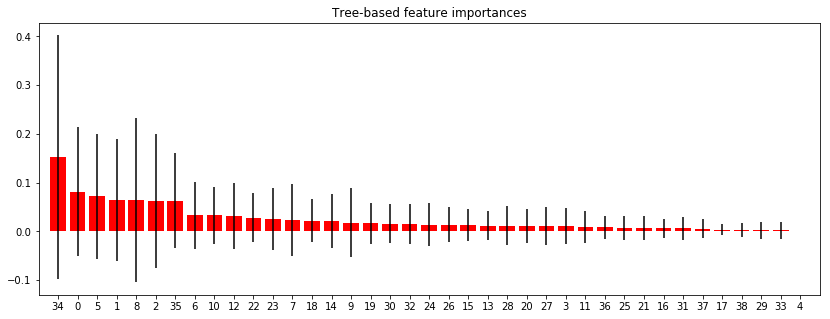

Feature ranking:
 1. StringSimilarityFeature                            0.152424 0.2498 -0.0974  0.4022
 2. ContextCoherenceFeature$Bigram                     0.081549 0.1328 -0.0512  0.2143
 3. ApproximateContextCoherenceFeature$Trigram         0.071661 0.1283 -0.0566  0.1999
 4. ContextCoherenceFeature$Trigram                    0.064601 0.1248 -0.0602  0.1894
 5. DistanceFeature$Levenstein                         0.064377 0.1691 -0.1047  0.2335
 6. ContextCoherenceFeature$Fourgram                   0.062646 0.1381 -0.0754  0.2007
 7. LanguagePopularityFeature                          0.062547 0.0973 -0.0348  0.1599
 8. ApproximateContextCoherenceFeature$Fourgram        0.033424 0.0688 -0.0354  0.1022
 9. DistanceFeature$LCS                                0.033349 0.0585 -0.0251  0.0918
10. DistanceFeature$Jaro-Winkler                       0.031903 0.0674 -0.0355  0.0993
11. DistanceFeature$ngram-binary-bigram                0.027989 0.0500 -0.0221  0.0780
12. DistanceFeature$ngram-

In [156]:
eval_feat_importances(model.ExtraTreesModel, 'GB-top10.t200')

<class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
ExtraTreesRegressor

0.025641025641


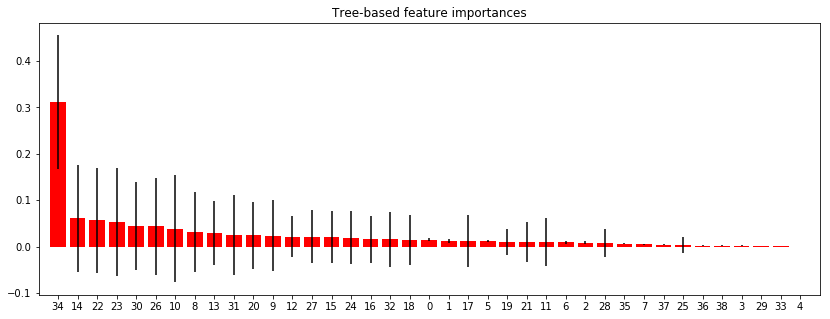

Feature ranking:
 1. StringSimilarityFeature                            0.311547 0.1435  0.1681  0.4550
 2. DistanceFeature$ngram-Jaccard-bigram               0.061316 0.1152 -0.0538  0.1765
 3. DistanceFeature$ngram-binary-bigram                0.056543 0.1135 -0.0569  0.1700
 4. DistanceFeature$ngram-binary-trigram               0.052970 0.1165 -0.0635  0.1694
 5. DistanceFeature$ngram-comprehensive-bigram         0.044524 0.0956 -0.0510  0.1401
 6. DistanceFeature$ngram-positional-bigram            0.043590 0.1051 -0.0615  0.1487
 7. DistanceFeature$LCS                                0.038475 0.1157 -0.0772  0.1542
 8. DistanceFeature$Levenstein                         0.031345 0.0859 -0.0546  0.1173
 9. DistanceFeature$ngram-Jaccard-unigram              0.029084 0.0692 -0.0401  0.0983
10. DistanceFeature$ngram-comprehensive-trigram        0.024465 0.0860 -0.0616  0.1105
11. DistanceFeature$qgram-fourgram                     0.024056 0.0719 -0.0478  0.0959
12. DistanceFeature$Damera

In [155]:
eval_feat_importances(model.ExtraTreesModel, 'ET-top10.t100')

RandomForestRegressor

0.025641025641


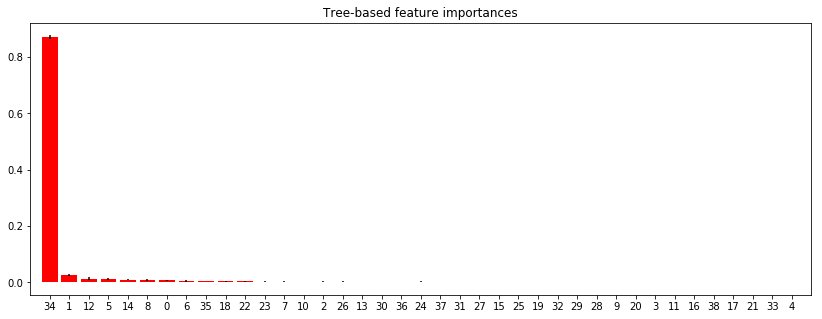

Feature ranking:
 1. StringSimilarityFeature                            0.869727 0.0070  0.8627  0.8767
 2. ContextCoherenceFeature$Trigram                    0.026065 0.0041  0.0219  0.0302
 3. DistanceFeature$Jaro-Winkler                       0.012469 0.0050  0.0075  0.0175
 4. ApproximateContextCoherenceFeature$Trigram         0.012119 0.0031  0.0091  0.0152
 5. DistanceFeature$ngram-Jaccard-bigram               0.009263 0.0026  0.0066  0.0119
 6. DistanceFeature$Levenstein                         0.008289 0.0022  0.0061  0.0105
 7. ContextCoherenceFeature$Bigram                     0.006887 0.0021  0.0048  0.0090
 8. ApproximateContextCoherenceFeature$Fourgram        0.005001 0.0026  0.0024  0.0076
 9. LanguagePopularityFeature                          0.004541 0.0006  0.0040  0.0051
10. DistanceFeature$qgram-bigram                       0.003829 0.0021  0.0018  0.0059
11. DistanceFeature$ngram-binary-bigram                0.003499 0.0005  0.0030  0.0040
12. DistanceFeature$ngram-

In [42]:
eval_feat_importances(model.RandomForestModel, 'RF-top3.t10.balanced')

RandomForestRegressor

0.025641025641


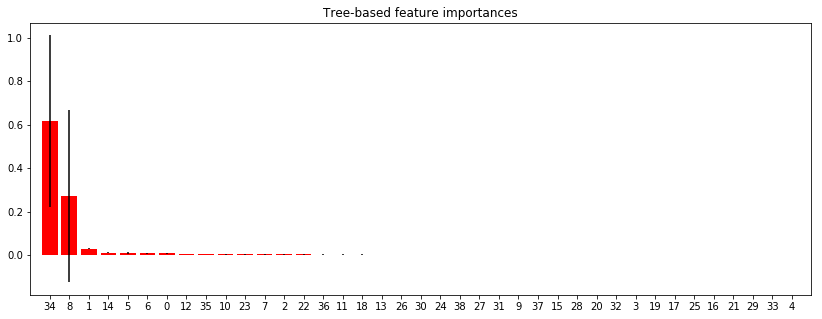

Feature ranking:
 1. StringSimilarityFeature                            0.616022 0.3938  0.2222  1.0099
 2. DistanceFeature$Levenstein                         0.271472 0.3975 -0.1260  0.6689
 3. ContextCoherenceFeature$Trigram                    0.030043 0.0016  0.0284  0.0317
 4. DistanceFeature$ngram-Jaccard-bigram               0.010887 0.0025  0.0083  0.0134
 5. ApproximateContextCoherenceFeature$Trigram         0.009116 0.0031  0.0060  0.0122
 6. ApproximateContextCoherenceFeature$Fourgram        0.007988 0.0023  0.0057  0.0103
 7. ContextCoherenceFeature$Bigram                     0.007690 0.0013  0.0064  0.0090
 8. DistanceFeature$Jaro-Winkler                       0.004571 0.0008  0.0038  0.0054
 9. LanguagePopularityFeature                          0.004175 0.0013  0.0029  0.0054
10. DistanceFeature$LCS                                0.003007 0.0007  0.0023  0.0037
11. DistanceFeature$ngram-binary-trigram               0.002858 0.0016  0.0012  0.0045
12. ApproximateContextCohe

In [43]:
eval_feat_importances(model.RandomForestModel, 'RF-top10.t10.balanced')